# OC IML Projet 5 : Catégorisez automatiquement des questions

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique
développez *un système de suggestion de tag* pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


Ce notebook contient : 
- Exploration des données



## import

In [989]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import string
from string import punctuation 

import re

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import scipy.stats as st

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection

from skmultilearn.problem_transform import BinaryRelevance


import time

[nltk_data] Downloading package punkt to /Users/gregory/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregory/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gregory/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Definitions

In [331]:
# source paths
PATH_SOURCE_QUESTIONS = '../../data/QueryResults.csv' 
df_results = None

## Useful functions

In [3]:
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

In [4]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

In [269]:
def find_tags_from_topic_first_top(iloc_topic, df_topics_tags, no_max=10):
    '''
    Find best no_max Tags from Topics by giving Topic number as input.
    (By default no_max = 10)
    Uses table linking Tags & Topics 
    
    inputs : 
    - iloc_topic
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    - no_max : number of best Tags to output
    
    returns the list of no_max Topics numbers (int)
    '''
    return list(df_topics_tags.sort_values(by="Topic_{}".format(iloc_topic), 
                                           ascending=False).head(no_max).index)

In [280]:
def find_tags_from_dtopics(d_topics, df_topics_tags, no_max=10):
    '''
    Find best no_max Tags from Topics by giving Topic number as input.
    (By default no_max = 10)
    Uses table linking Tags & Topics 
    
    inputs : 
    - d_topics : topics distribution from LDA
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    - no_max : number of best Tags to output
    
    returns the list of no_max Topics numbers (int)
    '''
    
    # multiply topics each columns of df_topics_tags by distrib dtopics vector:
    arr_tags = df_topics_tags.values*d_topics # table (tags(row)*Topics(col))
    # sum each row (by Tags)
    sum_distrib_tags = arr_tags.sum(axis=1) # vector (n Tags)
    # create dataframe to link with tags
    df_sum_tags = pd.DataFrame(data=sum_distrib_tags, columns=["d_sum"], 
                           index=df_topics_tags.index)
    # return no_max Tags with best score
    return list(df_sum_tags.sort_values(by="d_sum", 
                                        ascending=False).head(no_max).index)


In [270]:
def find_pred_tags_from_quest(quest_iloc,
                              df_topics_pred,
                              topic_dict,
                              df_topics_tags,
                              freq_min=0.1):
    '''
    Find predicted tags from the question number.
    
    inputs : 
    - quest_iloc : indice question (iloc)
    - df_topics_pred : table of Topics distribution by question 
    - topic_dict contains list of keywords for each topics
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    '''

    list_topic_id = find_topics(quest_iloc=quest_iloc, freq_min=freq_min, 
                                df_topics_pred=df_topics_pred,
                                topic_dict=topic_dict)

    return find_tags_from_topic_first_top(iloc_topic=list_topic_id[0],
                                df_topics_tags=df_topics_tags)

In [7]:
# prepare dictionnary of translation to suppress ponctuation
replace_punctuation = str.maketrans(string.punctuation,
                                    ' '*len(string.punctuation))
def cleaning_text(questions_curr):

    # lower case
    questions_curr = ' '.join([w.lower() for w in \
                               nltk.word_tokenize(questions_curr) \
                              if not w.lower() in list(sw)])
    # delete newlines
    questions_curr = re.sub(r'\s+', ' ', questions_curr)
    # delete single quotes
    questions_curr = re.sub(r"\'", " ", questions_curr)
    # delete tags
    questions_curr = re.sub('<[^<]+?>',' ', questions_curr)
    # delete numbers (forming group = word with only numbers 
    # example : delete "123" but not "a123")
    questions_curr = re.sub(r'\b\d+\b','', questions_curr) 
    # delete ponctuation (replace by space)
    questions_curr = questions_curr.translate(replace_punctuation)

    return questions_curr

#[stemmer.stem(w) for w in tokens if not w in list(sw)]

In [271]:
def find_tags_from_text_first_top(text, tf_vectorizer, lda_model, 
                        df_topics_tags, no_max=10):
    '''
    Predict tags from text using tf, lda and tags2topic table
    
    tf vectorizer, lda and table must be input.
    '''
    # clean the text
    text_cleaned = cleaning_text(text)

    # calculate feature from text with tf already fitted
    feat_curr =  tf_vectorizer.transform([text_cleaned])

    # calculate topic distrib with lda model already fitted
    topic_distrib_pred = lda_model.transform(feat_curr)

    # find best topic from table df_topics_tags
    return find_tags_from_topic_first_top(topic_distrib_pred.argmax(), 
                                df_topics_tags=df_topics_tags, 
                                no_max=no_max)

In [281]:
def find_tags_from_text(text, tf_vectorizer, lda_model, 
                        df_topics_tags, no_max=10):
    '''
    Predict tags from text using tf, lda and tags2topic table
    
    tf vectorizer, lda and table must be input.
    '''
    # clean the text
    text_cleaned = cleaning_text(text)

    # calculate feature from text with tf already fitted
    feat_curr =  tf_vectorizer.transform([text_cleaned])

    # calculate topic distrib with lda model already fitted
    topic_distrib_pred = lda_model.transform(feat_curr)

    # find best topic from table df_topics_tags
    return find_tags_from_dtopics(topic_distrib_pred, df_topics_tags, 
                                  no_max=no_max)

In [9]:
stemmer = EnglishStemmer()

def stem_tokens(tokens, stemmer):
    '''
    Stem words in tokens.
    and suppress word < 3 characters
    '''
    stemmed = []
    for item in tokens:
        if re.match('[a-zA-Z0-9]{3,}',item):
            stemmed.append(stemmer.stem(item))
    return stemmed

def myTokenizer(text):
    '''
    Create tokens from text
    '''
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [10]:
def apply_extract_tag(text_raw, num=0):
    list_tags = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', text_raw)
    try:
        return list_tags[num]
    except:
        return np.nan

In [11]:
def find_topics(quest_iloc, df_topics_pred, topic_dict, freq_min=0.1):
    '''
    find & display topics about current question (indice loc to be specified)
    '''
    print("Cleaned question n°{}:".format(quest_iloc))
    print(token_dict[df_quest_cleaned.iloc[quest_iloc].name])
    print("\nTags : ", df_quest_cleaned.iloc[quest_iloc].Tags)
    print("")
    fig = plt.figure(figsize=(8, 6))
    df_topics_pred.iloc[quest_iloc].plot()
    #for topic_id_curr in np.nonzero(
    #    df_topics_pred.iloc[quest_iloc] > freq_min)[0]:
    list_topic_labels = df_topics_pred.\
        iloc[quest_iloc][df_topics_pred.iloc[quest_iloc] > freq_min].\
        sort_values(ascending=False).index
    print(list_topic_labels)
    list_topic_id =[]
    for label_curr in list_topic_labels:
        list_topic_id.append(int(re.findall(r"\d+", label_curr)[0]))
    print(list_topic_id)
    for topic_id_curr in list_topic_id:
        print("Topic {} : {}".format(topic_id_curr, 
                                     topic_dict[topic_id_curr]))
    return list(list_topic_id)

In [12]:
def display_topics(model, feature_names, no_top_words):
    '''
    function to create & display topic dictionnary from lda model 
    '''
    topic_dict = dict()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        str_topic = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(str_topic)
        topic_dict[topic_idx] = str_topic
    return topic_dict 

In [13]:
def score_eval_tags(tags_real, tags_pred, nb_tags_eval_max=10):
    '''
    For a list of real tags, estimate the proportion of good predicted tags
    Example : 
    real : <java><php><sql>
    predicted : <sql><tag1><tag2><tag3> 
    => score = 1/3 = 0.333
    '''
    coeff_score = 1/len(tags_real)
    score = 0
    for tags_real_curr in tags_real:
        if tags_real_curr in tags_pred[:nb_tags_eval_max]:
            score += coeff_score
            continue
    return score

In [14]:
def find_nb_no_tags(my_array_binary):
    '''
    Counts number of no-Tags output
    '''
    nb_zeros = 0
    nb_rows = my_array_binary.shape[0]
    for idx in range(0, nb_rows):
        if sum(my_array_binary[idx,:]) == 0:
            #print('Error : row n°{} is empty!'.format(idx))
            nb_zeros += 1
    print("Nb. no Tags samples : {} over {} rows [{:.2f}%]".\
          format(nb_zeros, nb_rows, 100*nb_zeros/nb_rows))
    return nb_zeros

In [15]:
def find_nb_no_uniquetag(list_tags):
    '''
    Counts number of no-Tags output with list_tags strings as input
    '''
    nb_zeros = 0
    nb_rows = len(list_tags)
    for tag_curr in list_tags:
        if (tag_curr is None)|(tag_curr is np.nan)|(tag_curr == '')|(tag_curr == []):
            #print('Error : row n°{} is empty!'.format(idx))
            nb_zeros += 1
        #print(tag_curr)
    print("Nb. no Tags samples : {} over {} rows [{:.2f}%]".\
          format(nb_zeros, nb_rows, 100*nb_zeros/nb_rows))
    return nb_zeros

In [16]:
def create_tags_list_of_list(list_str_tags, list_tags_most_used=None):
    '''
    Create a list of list of tags from series/list of original strings of tags
    per questions 
    
    example : input : [<tag1><tag2><tag3>] output : [['tag1','tag2','tag3']]
    '''
    list_list_tags = []
    for idx, str_tags in enumerate(list_str_tags):
        list_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', str_tags)
        
        list_tags_ok = []
        
        for tag_curr in list_curr:
            if list_tags_most_used is None:
                list_tags_ok.append(tag_curr)
            else:
                if tag_curr in list_tags_most_used:
                    list_tags_ok.append(tag_curr)
                
        if list_tags_ok == []:
            print("Error iloc :  ", idx)
            
        list_list_tags.append(list_tags_ok)
    return list_list_tags

In [282]:
def predict_tags_from_list_texts(list_texts, tf_vectorizer,
                                    lda_model, 
                                    df_topics_tags,
                                    no_max):
    '''
    Predict a list of list of tags from list of text
    
    no_max determined the maximum number of tags predicted for each text in
    input.
    '''
    list_predicted_tags = []
    for text_curr in list_texts:
        # predict tags
        tags_pred = find_tags_from_text(text=text_curr, 
                                    tf_vectorizer=tf_vectorizer,
                                    lda_model=lda_model, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=no_max)
        list_predicted_tags.append(tags_pred)
        
    return list_predicted_tags

In [620]:
def evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          timing_fit, timing_pred):
    dict_scores = dict()
    dict_scores["acc_train"] = accuracy_score(enc_lda_y_train, 
                                              enc_lda_ypred_train)
    dict_scores["acc_test"] = accuracy_score(enc_lda_y_test, enc_lda_ypred_test)
    
    dict_scores["pre_train"] = precision_score(enc_lda_y_train, 
                                               enc_lda_ypred_train, 
                                               average='micro')
    dict_scores["pre_test"] = precision_score(enc_lda_y_test, 
                                              enc_lda_ypred_test, 
                                              average='micro')
    
    dict_scores["rec_train"] = recall_score(enc_lda_y_train, 
                                            enc_lda_ypred_train, 
                                            average='micro')
    dict_scores["rec_test"] = recall_score(enc_lda_y_test, 
                                           enc_lda_ypred_test, 
                                           average='micro')
    
    dict_scores["f1_train"] = f1_score(enc_lda_y_train, enc_lda_ypred_train, 
                                       average='micro')
    dict_scores["f1_test"] = f1_score(enc_lda_y_test, enc_lda_ypred_test, 
                                      average='micro')
    
    dict_scores["notags_train"] = find_nb_no_tags(enc_lda_ypred_train) / \
        enc_lda_ypred_train.shape[0]
    
    dict_scores["notags_test"] = find_nb_no_tags(enc_lda_ypred_test) / \
        enc_lda_ypred_test.shape[0]
    
    dict_scores["t_fit_train"] = timing_fit
    dict_scores["t_pred_test"] = timing_pred
    
    return pd.Series(data = dict_scores)

In [336]:
def add_score(df_results, series_scores, model_name):
    
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

## Loading

In [17]:
# loading each sources
df_quest = pd.read_csv(PATH_SOURCE_QUESTIONS, sep=',')

### Questions/Answers

In [18]:
df_quest.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
0,50000002,2,NaN,49999948.0,2018-04-24 11:00:00,NaN,2,NaN,<p>You need to have a pointer to the <code>ma...,1983495.0,NaN,1983495.0,NaN,2018-04-24 12:14:36,2018-04-24 12:14:36,NaN,NaN,NaN,4,NaN,NaN,NaN
1,50000003,2,NaN,49995279.0,2018-04-24 11:00:00,NaN,1,NaN,<p>The old state is discarded. If you want to ...,506441.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:00,NaN,NaN,NaN,3,NaN,NaN,NaN
2,50000004,2,NaN,49999911.0,2018-04-24 11:00:01,NaN,0,NaN,<p>If you are trying to achieve the above outp...,6155965.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:01,NaN,NaN,NaN,6,NaN,NaN,NaN
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,NaN,2018-04-24 11:03:32,2018-04-24 13:15:50,How to insert an entry to a table only if it d...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,NaN,NaN,2018-05-01 13:24:04,System DMV's missing from SQL Server 2017 mast...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN


In [19]:
df_quest["Id"].nunique()

50000

,nb_missing,ratio
Id,0,0.000
PostTypeId,0,0.000
LastActivityDate,0,0.000
CommentCount,0,0.000
CreationDate,0,0.000
Score,0,0.000
Body,24,0.048
OwnerUserId,508,1.016
ParentId,21280,42.560
ViewCount,28792,57.584


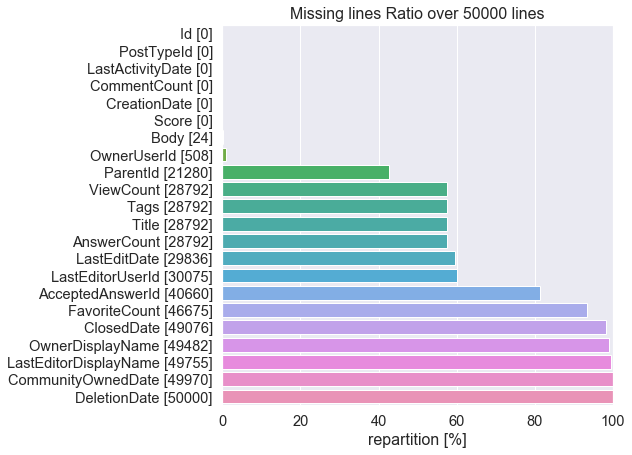

In [20]:
display_missing(df_quest)

### Filter questions

Only Questions don't have ParentId.

We filter questions with no ParentId and with non-Nan Body

In [21]:
df_quest_cleaned = df_quest[df_quest["ParentId"].isna()]
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned["Body"].notna()]

,nb_missing,ratio
Id,0,0.000000
LastActivityDate,0,0.000000
Score,0,0.000000
CommentCount,0,0.000000
Body,0,0.000000
PostTypeId,0,0.000000
CreationDate,0,0.000000
ViewCount,48,0.225819
Title,48,0.225819
AnswerCount,48,0.225819


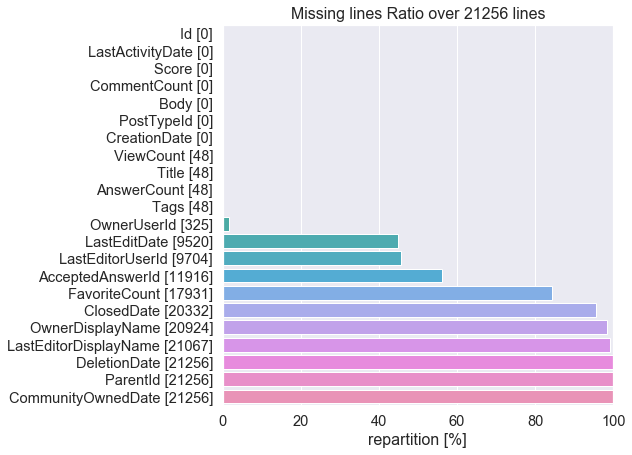

In [22]:
display_missing(df_quest_cleaned)

In [23]:
df_quest_cleaned[df_quest_cleaned.Title.isna()]

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
655,50000860,4,NaN,NaN,2018-04-24 11:44:34,NaN,0,NaN,osgEarth is a geospatial SDK and terrain engin...,1332041.0,NaN,1332041.0,NaN,2018-04-25 07:25:46,2018-04-25 07:25:46,NaN,NaN,NaN,0,NaN,NaN,NaN
2576,50003399,5,NaN,NaN,2018-04-24 13:49:51,NaN,0,NaN,<p>This is an ambiguous tag that should not be...,1356107.0,NaN,1356107.0,NaN,2018-04-26 12:02:53,2018-04-26 12:02:53,NaN,NaN,NaN,0,NaN,NaN,NaN
2577,50003400,4,NaN,NaN,2018-04-24 13:49:51,NaN,0,NaN,DO NOT USE THIS TAG! Please find a more releva...,1481116.0,NaN,1356107.0,NaN,2018-04-26 12:06:27,2018-04-26 12:06:27,NaN,NaN,NaN,0,NaN,NaN,NaN
8467,50011191,4,NaN,NaN,2018-04-24 21:49:32,NaN,0,NaN,Use this tag for questions specific to Lightwe...,5862071.0,NaN,5862071.0,NaN,2018-04-24 21:49:32,2018-04-24 21:49:32,NaN,NaN,NaN,0,NaN,NaN,NaN
9636,50012751,5,NaN,NaN,2018-04-25 01:22:51,NaN,0,NaN,"<p><a href=""https://cloud.google.com/profiler/...",848626.0,NaN,848626.0,NaN,2018-04-25 10:21:23,2018-04-25 10:21:23,NaN,NaN,NaN,0,NaN,NaN,NaN
9637,50012752,4,NaN,NaN,2018-04-25 01:22:51,NaN,0,NaN,Google Cloud Profiler (aka Stackdriver Profile...,848626.0,NaN,848626.0,NaN,2018-04-26 04:06:31,2018-04-26 04:06:31,NaN,NaN,NaN,0,NaN,NaN,NaN
12039,50015982,5,NaN,NaN,2018-04-25 07:02:19,NaN,0,NaN,<p>Full details on downloading and using F#-Ch...,4288666.0,NaN,4288666.0,NaN,2018-04-25 12:16:54,2018-04-25 12:16:54,NaN,NaN,NaN,0,NaN,NaN,NaN
12040,50015983,4,NaN,NaN,2018-04-25 07:02:19,NaN,0,NaN,The F# Charting library implements charting su...,4288666.0,NaN,4288666.0,NaN,2018-04-25 22:24:30,2018-04-25 22:24:30,NaN,NaN,NaN,0,NaN,NaN,NaN
17297,50022969,5,NaN,NaN,2018-04-25 12:55:35,NaN,0,NaN,<p>Amazon Transcribe is an automatic speech re...,123378.0,NaN,123378.0,NaN,2018-04-25 18:45:32,2018-04-25 18:45:32,NaN,NaN,NaN,0,NaN,NaN,NaN
17298,50022970,4,NaN,NaN,2018-04-25 12:55:35,NaN,0,NaN,Amazon Transcribe is a speech recognition serv...,123378.0,NaN,123378.0,NaN,2018-04-26 05:32:48,2018-04-26 05:32:48,NaN,NaN,NaN,0,NaN,NaN,NaN


In [24]:
df_quest_cleaned[df_quest_cleaned.Id == 50060292].Body.tolist()

['<p>This library is deprecated and is no longer being used. Use <a href="/questions/tagged/boost-log" class="post-tag" title="show questions tagged &#39;boost-log&#39;" rel="tag">boost-log</a> instead. </p>\n\n<p><a href="https://meta.stackoverflow.com/questions/298315/burninate-boost-logging">Burninate boost-logging</a> </p>\n']

In [25]:
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned.Title.notna()]

,nb_missing,ratio
Id,0,0.000000
LastActivityDate,0,0.000000
AnswerCount,0,0.000000
Title,0,0.000000
ViewCount,0,0.000000
Score,0,0.000000
Body,0,0.000000
CreationDate,0,0.000000
PostTypeId,0,0.000000
CommentCount,0,0.000000


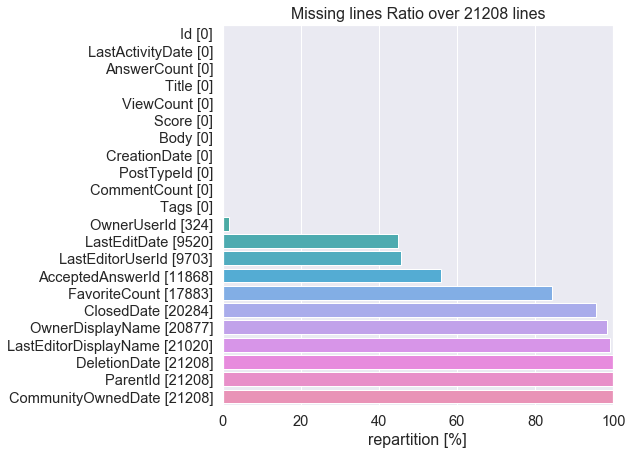

In [26]:
display_missing(df_quest_cleaned)

In [27]:
df_quest_cleaned[df_quest_cleaned["OwnerUserId"].isna()].head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
117,50000152,1,50000270.0,NaN,2018-04-24 11:07:30,NaN,1,33.0,<p>I'm working on a blog. On its first page I ...,NaN,user9690627,3848833.0,NaN,2018-04-24 12:19:36,2018-04-24 12:19:36,Django - Combining Multiple Variables,<python><django>,1.0,0,NaN,NaN,NaN
140,50000185,1,50000460.0,NaN,2018-04-24 11:09:32,NaN,1,95.0,<p>I'm trying to write a PHP code that's a bit...,NaN,user9474945,4248328.0,NaN,2018-04-24 11:10:22,2018-04-24 15:47:15,Php date move to next month,<php>,4.0,2,NaN,NaN,NaN
179,50000239,1,50003124.0,NaN,2018-04-24 11:12:02,NaN,0,42.0,<p>I'm trying to append into the html code a j...,NaN,user9557101,NaN,user9557101,2018-04-24 11:29:35,2018-04-24 13:37:33,how to append a javascript function with 2 var...,<javascript><laravel>,1.0,3,NaN,NaN,NaN
711,50000932,1,NaN,NaN,2018-04-24 11:48:21,NaN,0,882.0,<p>I have some problems with 'entityManagerFac...,NaN,user7866438,3535298.0,NaN,2018-04-24 12:49:52,2018-04-24 12:49:52,Parameter 0 of constructor in com.springboot.D...,<java><hibernate><spring-boot><spring-data-jpa...,0.0,5,NaN,NaN,NaN
1291,50001710,1,NaN,NaN,2018-04-24 12:28:33,NaN,0,340.0,<p>i have a bottom navigation in main activity...,NaN,user9585742,7666442.0,NaN,2018-04-24 12:36:36,2018-04-24 12:36:36,putting recycler view above bottom navigation,<java><android><android-layout>,2.0,4,NaN,NaN,NaN


## Preparation data

### Tags

#### Nb Tags per Question

In [28]:
def apply_nb_tags(str_tags):
    return len(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', str_tags))

df_quest_cleaned["nb_Tags"] = df_quest_cleaned["Tags"].apply(apply_nb_tags)


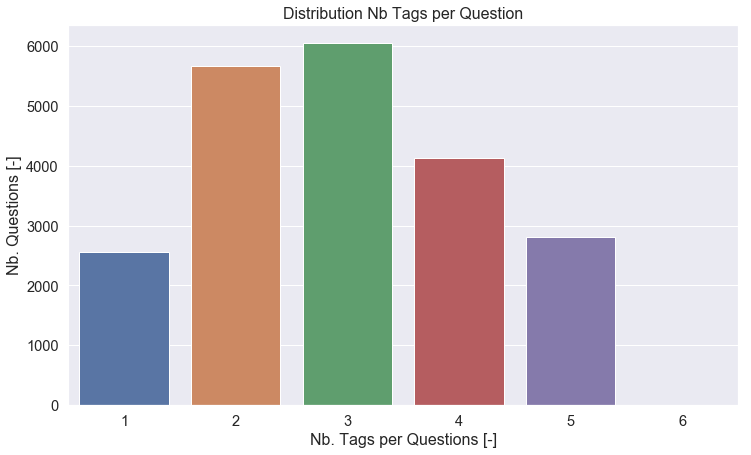

In [29]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution Nb Tags per Question")
#ax = sns.distplot(df_quest_cleaned["nb_Tags"], kde=False, bins=6);
ax = sns.countplot(data=df_quest_cleaned, x="nb_Tags");
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. Tags per Questions [-]")
ax.set_ylabel("Nb. Questions [-]");
#ax.set_xlim([0,25])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


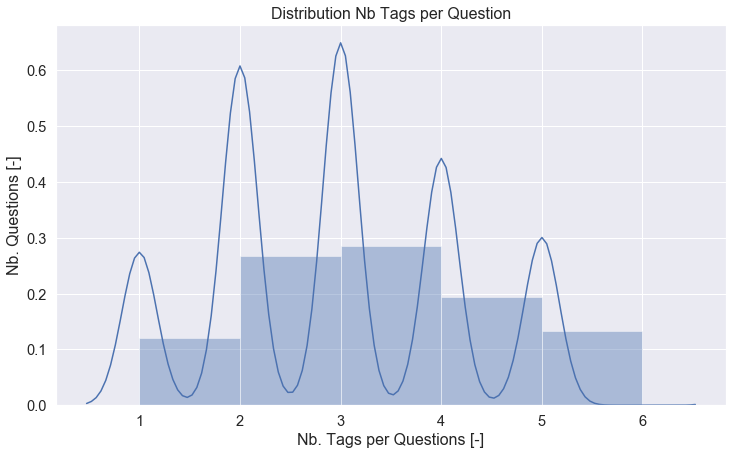

In [30]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution Nb Tags per Question")
ax = sns.distplot(df_quest_cleaned["nb_Tags"], bins=5);
#ax = sns.countplot(data=df_quest_cleaned, x="nb_Tags");
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. Tags per Questions [-]")
ax.set_ylabel("Nb. Questions [-]");
#ax.set_xlim([0,25])

Only 1 Question with 6 Tags : 

In [31]:
df_quest_cleaned[df_quest_cleaned["nb_Tags"] == 6].shape[0]

1

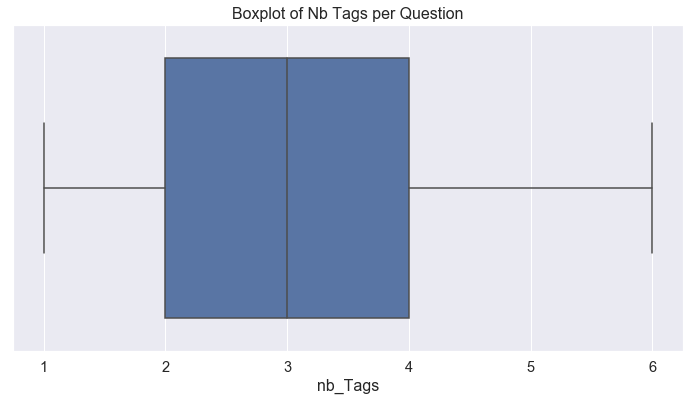

In [32]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot of Nb Tags per Question")
ax = sns.boxplot(df_quest_cleaned["nb_Tags"]);
#ax.set_xlim([0,20])
#ax.set_xlabel("nb. Occurences")

#### Unique Tags

In [33]:
# extract all tags
list_tags_raw=[]
for idx in range(0, df_quest_cleaned.shape[0]):
    #print("start...",idx)
    list_tags_raw = list_tags_raw+(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_quest_cleaned.iloc[idx].Tags))
# list of unique tags over all questions (no limitation at most frequent tags)
list_unique_tags = list(np.unique(list_tags_raw)) 
print('Total Number of Tags:', len(list_tags_raw))
print("Number of Unique Tags:",len(list_unique_tags))
list_unique_tags[:10]

Total Number of Tags: 62572
Number of Unique Tags: 8765


['.app',
 '.htaccess',
 '.lib',
 '.net',
 '.net-1.1',
 '.net-4.0',
 '.net-4.5',
 '.net-4.6',
 '.net-4.6.1',
 '.net-4.6.2']

In [34]:
df_Tags = pd.DataFrame(list_tags_raw, columns=["Tag"])
df_Tags = pd.DataFrame(df_Tags.Tag.value_counts())
df_Tags.head(10)

,Tag
javascript,2229
python,2180
java,1688
c#,1183
android,1137
php,1092
html,955
css,665
r,660
jquery,639


Text(0, 0.5, 'Normalized distribution [-]')

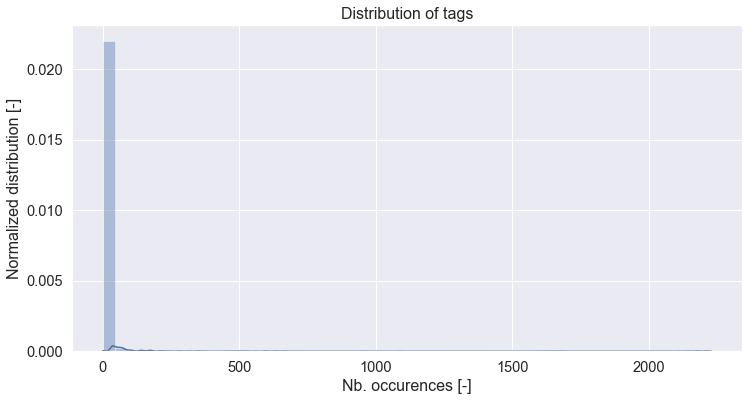

In [35]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of tags")
#ax = sns.distplot(df_Tags[df_Tags["Tag"] <= 100], kde=False);
ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. occurences [-]")
ax.set_ylabel("Normalized distribution [-]")

(0, 25)

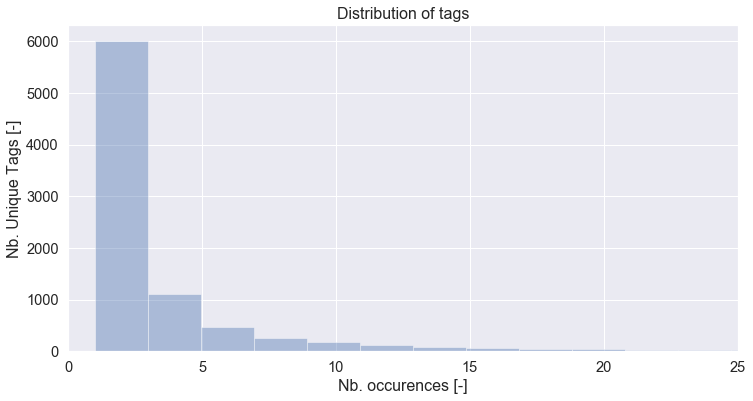

In [36]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of tags")
ax = sns.distplot(df_Tags[df_Tags["Tag"] <= 100], kde=False);
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. occurences [-]")
ax.set_ylabel("Nb. Unique Tags [-]")
ax.set_xlim([0,25])

(0.9, 1)

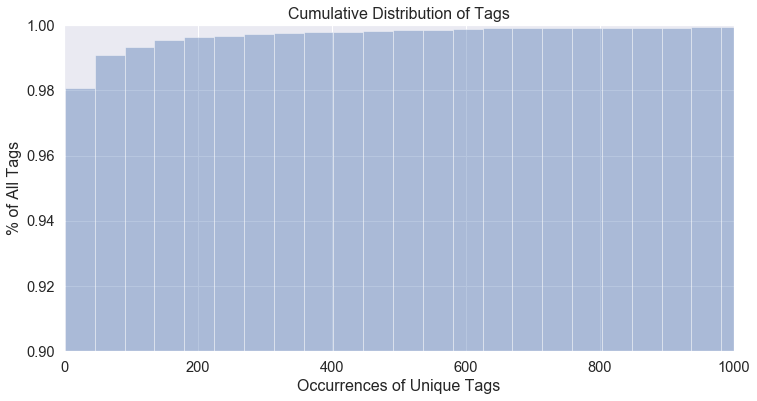

In [37]:
fig = plt.figure(figsize=(12, 6))
plt.title("Cumulative Distribution of Tags")
ax = sns.distplot(df_Tags["Tag"], kde=True,
                 hist_kws={'cumulative': True});
ax.set_xlabel("Occurrences of Unique Tags")
ax.set_ylabel("% of All Tags");
ax.set_xlim([0, 1000])
ax.set_ylim([0.9, 1])

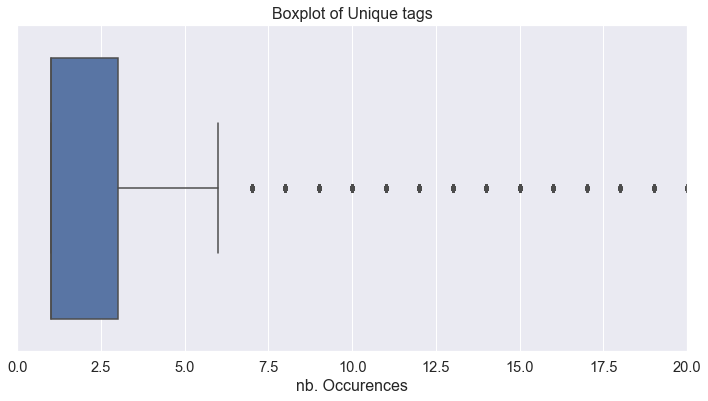

In [38]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot of Unique tags")
ax = sns.boxplot(df_Tags["Tag"]);
ax.set_xlim([0,20])
ax.set_xlabel("nb. Occurences");

#### Extract Tags

In [39]:
df_quest_cleaned["Tag_0"] = df_quest_cleaned.Tags.apply(apply_extract_tag)
df_quest_cleaned["Tag_1"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(1,))
df_quest_cleaned["Tag_2"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(2,))
df_quest_cleaned["Tag_3"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(3,))
df_quest_cleaned["Tag_4"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(4,))
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,nb_Tags,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN,3,c#,sql,sql-server,NaN,NaN
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN,2,sql-server,sql-server-data-tools,NaN,NaN,NaN
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,<javascript><php><ajax>,1.0,4,NaN,NaN,NaN,3,javascript,php,ajax,NaN,NaN
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,<android><amazon-s3><file-upload><multipart>,1.0,0,NaN,NaN,NaN,4,android,amazon-s3,file-upload,multipart,NaN
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,<sql><db2><crosstab>,1.0,0,NaN,NaN,NaN,3,sql,db2,crosstab,NaN,NaN


#### Most used Tags

To have a balance between number of Tags to predict and their utilization 

In [40]:
list_nb_tags_used_min = [160, 100, 76, 40]

list_list_most_used =[]
list_nb_tags_unique_most_used = []
list_pc_tags =[]
for nb_tags_used_min in list_nb_tags_used_min:
    
    list_list_most_used.append(list(df_Tags[df_Tags["Tag"] >= \
                                            nb_tags_used_min].index))
    list_nb_tags_unique_most_used.append(
        df_Tags[df_Tags["Tag"]>=nb_tags_used_min].shape[0])
    
    list_pc_tags.append(100*df_Tags[df_Tags["Tag"]>=nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0])
    
    print('Nb Tags used < {} times : {} over {} Tags [{:.2f}%]'.\
          format(nb_tags_used_min,
                 df_Tags[df_Tags["Tag"]<nb_tags_used_min].shape[0], 
                 df_Tags.shape[0],
                 100*df_Tags[df_Tags["Tag"]<nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0]))

    print('Nb Tags used >= {} times : {} over {} Tags [{:.2f}%]'.\
          format(nb_tags_used_min,
                 df_Tags[df_Tags["Tag"]>=nb_tags_used_min].shape[0], 
                 df_Tags.shape[0],
                 100*df_Tags[df_Tags["Tag"]>=nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0]))

df_most = pd.DataFrame(data=list_nb_tags_used_min, columns=["nb_min_used"])
df_most["nb_most_used_tags"] = list_nb_tags_unique_most_used
df_most["pc_of_unique_tags"] = list_pc_tags
df_most

Nb Tags used < 160 times : 8714 over 8765 Tags [99.42%]
Nb Tags used >= 160 times : 51 over 8765 Tags [0.58%]
Nb Tags used < 100 times : 8692 over 8765 Tags [99.17%]
Nb Tags used >= 100 times : 73 over 8765 Tags [0.83%]
Nb Tags used < 76 times : 8665 over 8765 Tags [98.86%]
Nb Tags used >= 76 times : 100 over 8765 Tags [1.14%]
Nb Tags used < 40 times : 8564 over 8765 Tags [97.71%]
Nb Tags used >= 40 times : 201 over 8765 Tags [2.29%]


,nb_min_used,nb_most_used_tags,pc_of_unique_tags
0,160,51,0.581860
1,100,73,0.832858
2,76,100,1.140901
3,40,201,2.293212


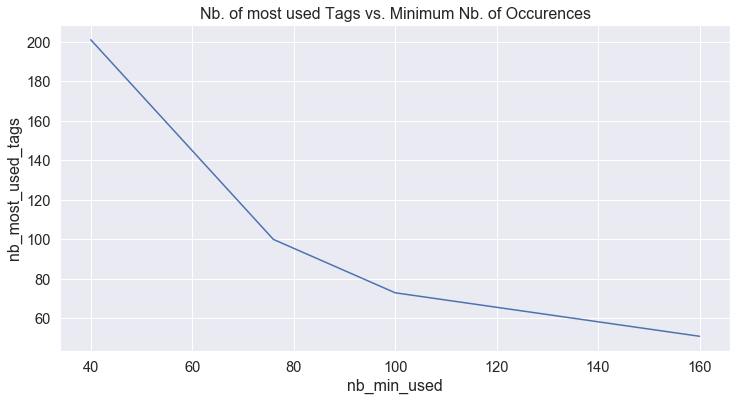

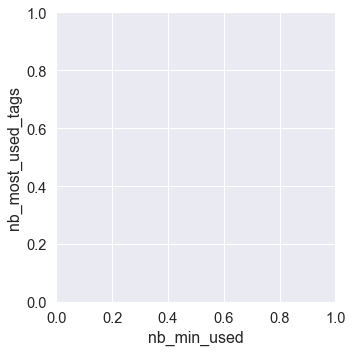

In [41]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb. of most used Tags vs. Minimum Nb. of Occurences")
ax = fig.gca()
sns.relplot(ax=ax, x="nb_min_used", y="nb_most_used_tags", data=df_most, 
            kind='line', markers=True)


#ax.set_xlim([0,20])
#ax.set_xlabel("nb. Occurences");

In [42]:
#list_tags_most_used = list(df_Tags[df_Tags["Tag"]>=nb_tags_used_min].index)
print("10 most used Tags:")
list_list_most_used[0][:10]

10 most used Tags:


['javascript',
 'python',
 'java',
 'c#',
 'android',
 'php',
 'html',
 'css',
 'r',
 'jquery']

In [43]:
len(list_list_most_used)

4

In [44]:
def check_Tags_most_used(text, list_most_used):
    '''
    Check if Tag string "text" is a most used Tag
    '''
    if text in list_most_used:
        return True
    return False


list_pc_quest=[]
for idx, list_most_used_curr in enumerate(list_list_most_used):
    df_quest_cleaned["flag_Tag_0"] = df_quest_cleaned["Tag_0"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_1"] = df_quest_cleaned["Tag_1"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_2"] = df_quest_cleaned["Tag_2"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_3"] = df_quest_cleaned["Tag_3"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_4"] = df_quest_cleaned["Tag_4"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_most_Tagged_{}"\
                     .format(list_nb_tags_used_min[idx])] = \
    df_quest_cleaned["flag_Tag_0"] | \
    df_quest_cleaned["flag_Tag_1"] | df_quest_cleaned["flag_Tag_2"] | \
    df_quest_cleaned["flag_Tag_3"] | df_quest_cleaned["flag_Tag_4"]
    
    list_pc_quest.append(100*df_quest_cleaned[\
        df_quest_cleaned["flag_most_Tagged_{}".\
        format(list_nb_tags_used_min[idx])] == True].shape[0] / \
        df_quest_cleaned.shape[0])
    

In [45]:
df_most["pc_of_quest"] = list_pc_quest
df_most

,nb_min_used,nb_most_used_tags,pc_of_unique_tags,pc_of_quest
0,160,51,0.581860,76.914372
1,100,73,0.832858,80.879857
2,76,100,1.140901,83.666541
3,40,201,2.293212,88.494908


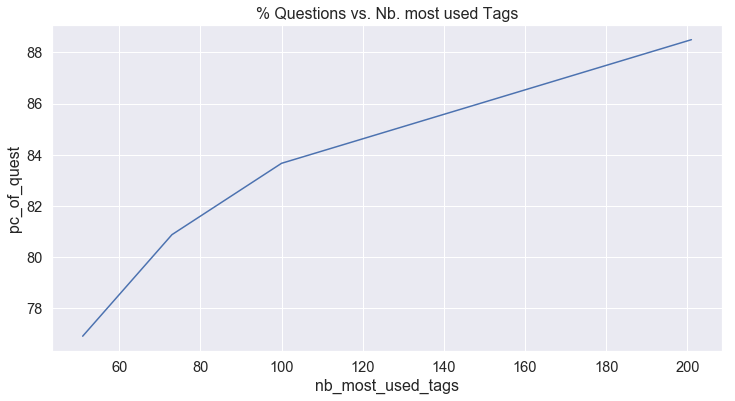

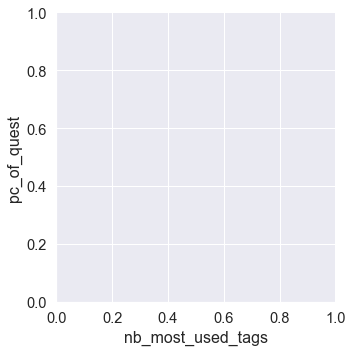

In [46]:
fig = plt.figure(figsize=(12, 6))
plt.title("% Questions vs. Nb. most used Tags")
ax = fig.gca()
sns.relplot(ax=ax, x="nb_most_used_tags", y="pc_of_quest", data=df_most, 
            kind='line', markers=True)

In [47]:
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_2,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged_160,flag_most_Tagged_100,flag_most_Tagged_76,flag_most_Tagged_40
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,sql-server,NaN,NaN,True,True,True,False,False,True,True,True,True
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,NaN,NaN,NaN,True,False,False,False,False,True,True,True,True
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,ajax,NaN,NaN,True,True,True,False,False,True,True,True,True
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,file-upload,multipart,NaN,True,True,False,False,False,True,True,True,True
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,crosstab,NaN,NaN,True,False,False,False,False,True,True,True,True


In [48]:
df_quest_cleaned["flag_most_Tagged_40"].value_counts(dropna=False)

True     18768
False     2440
Name: flag_most_Tagged_40, dtype: int64

In [49]:
df_quest_cleaned["flag_most_Tagged_76"].value_counts(dropna=False)

True     17744
False     3464
Name: flag_most_Tagged_76, dtype: int64

In [50]:
df_quest_cleaned["flag_most_Tagged_160"].value_counts(dropna=False)

True     16312
False     4896
Name: flag_most_Tagged_160, dtype: int64

In [51]:
#df_quest_cleaned = df_quest_cleaned[df_quest_cleaned["flag_most_Tagged"] == 
#                                    True]

### Title & Body concatenation

In [52]:
df_quest_cleaned["Text"] = df_quest_cleaned["Title"] + " " + df_quest_cleaned["Body"]
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged_160,flag_most_Tagged_100,flag_most_Tagged_76,flag_most_Tagged_40,Text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,NaN,NaN,True,True,True,False,False,True,True,True,True,How to insert an entry to a table only if it d...
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,NaN,NaN,True,False,False,False,False,True,True,True,True,System DMV's missing from SQL Server 2017 mast...
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,NaN,NaN,True,True,True,False,False,True,True,True,True,how to insert data in databse without page rel...
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,multipart,NaN,True,True,False,False,False,True,True,True,True,How to upload image using multipart in Amazon ...
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,NaN,NaN,True,False,False,False,False,True,True,True,True,DB2 SQL CROSSTAB <p>I would like to output a t...


In [53]:
df_quest_cleaned.head(1)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged_160,flag_most_Tagged_100,flag_most_Tagged_76,flag_most_Tagged_40,Text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,NaN,NaN,True,True,True,False,False,True,True,True,True,How to insert an entry to a table only if it d...


In [54]:
df_quest_cleaned.head(1).Title.tolist()

['How to insert an entry to a table only if it does not exist']

In [55]:
df_quest_cleaned.head(1).Body.tolist()

["<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"]

In [56]:
df_quest_cleaned.head(1).Text.tolist()

["How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"]

##### Create questions dictionnary

In [57]:
questions = df_quest_cleaned.filter(items=["Text"]).to_dict()
questions = questions["Text"]
print('{} questions'.format(len(questions)))

21208 questions


In [58]:
questions[4]

'System DMV\'s missing from SQL Server 2017 master.dacpac in SSDT 2015 <p>I have Ola Hallengren\'s excellent Maintenance Solution scripts incorporated in to a DBA tools database project.  This is maintained using SSDT 2015 with a target platform of SQL Server 2012.  The project includes references to the built-in system databases master &amp; msdb.  The project builds successfully.</p>\n\n<p>Ola has recently <a href="https://ola.hallengren.com/versions.html" rel="nofollow noreferrer">updated</a> his scripts and they now include references to new SQL Server 2017 DMV\'s, so incorporating the updated scripts into my database project generated unresolved reference errors for the new DMV\'s.  </p>\n\n<pre><code>SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_os_host_info]\nSQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_db_log_stats]\n</code></pre>\n\n<p>Although I don\'t have SQL Server 2017 installed a

### Words in questions

In [59]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats_corpora():
    '''
    Statistics about words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par question
    for id_curr,questions_curr in questions.items():        
        try:
            corpora[id_curr] += tokenizer.tokenize(questions_curr.lower())
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

# Récupération des comptages
freq, stats, corpora = freq_stats_corpora()
df_stats = pd.DataFrame.from_dict(stats, orient='index')

# Affichage des fréquences
#df.sort(columns='total', ascending=False)
#df = df.sort_values(by=['total'], ascending=False)
#df.head(50).plot(kind='bar', color="#f56900", title='Top 50 Rappeurs par nombre de mots')

In [60]:
df_stats.head()

,total,unique
3,82,49
4,424,192
9,355,89
10,31,24
12,70,39


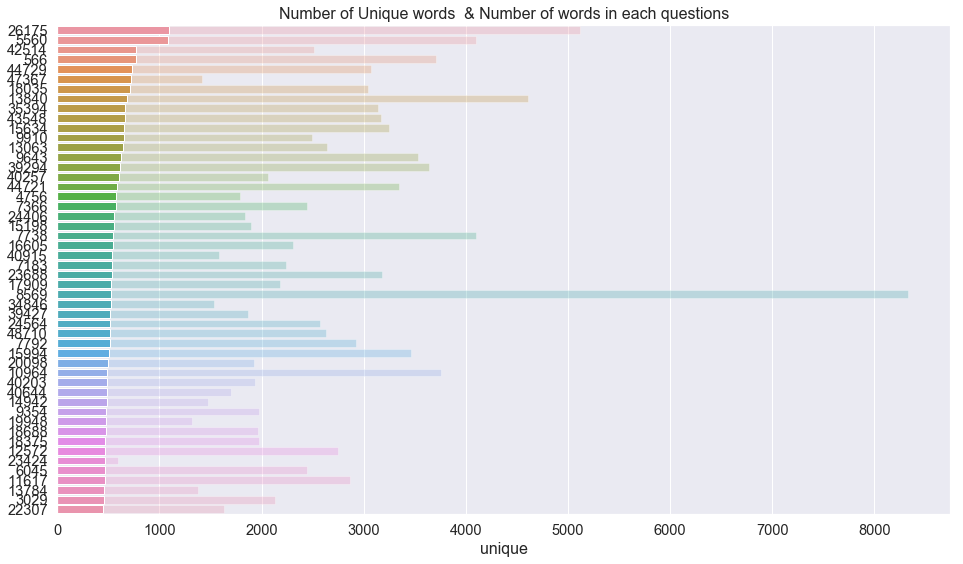

In [61]:
fig = plt.figure(figsize=(16, 9))
plt.title("Number of Unique words  & Number of words in each questions")
df_plot = df_stats.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [62]:
df_plot.T

,26175,5560,42514,566,44729,47367,18035,13840,35394,43548,15634,9910,...,14942,9354,19948,18688,18375,12572,23424,6045,11617,13784,3029,22307
total,5119,4100,2515,3708,3076,1420,3042,4610,3139,3172,3243,2492,...,1479,1974,1317,1964,1974,2753,595,2447,2869,1381,2130,1633
unique,1096,1087,770,767,733,719,712,683,667,664,649,648,...,483,479,475,473,470,468,467,467,465,455,453,451


In [63]:
len(df_quest_cleaned.loc[14942].Body)

9799

In [64]:
df_quest_cleaned.loc[14942].Body

"<p>My outer <code>RecyclerView</code> crashes either with</p>\n\n<pre><code>IllegalArgumentException: Scrapped or attached views may not be recycled. isScrap:false isAttached:true...\n</code></pre>\n\n<p>or</p>\n\n<pre><code>IllegalStateException: The specified child already has a parent. You must call removeView() on the child's parent first.\n</code></pre>\n\n<p>Like the title suggests I have an <code>RecyclerView</code> in the list item layout of the first <code>RecyclerView</code>. This layout is used to display messages and the \ninner <code>RecyclerView</code> to display attachments that come with the message. The inner <code>RecyclerViews</code> visibility is set to either <code>GONE</code> or <code>VISIBLE</code> depending whether the message has any attachments or not. The simplified outer list item layout looks like this</p>\n\n<pre><code>ConstraintLayout\n    TextView\n    TextView\n    TextView\n    RecyclerView\n</code></pre>\n\n<p>And the part of the adapter that handles

In [65]:
tokenizer.tokenize(df_quest_cleaned.loc[14942].Body)

['p',
 'My',
 'outer',
 'code',
 'RecyclerView',
 'code',
 'crashes',
 'either',
 'with',
 'p',
 'pre',
 'code',
 'IllegalArgumentException',
 'Scrapped',
 'or',
 'attached',
 'views',
 'may',
 'not',
 'be',
 'recycled',
 'isScrap',
 'false',
 'isAttached',
 'true',
 'code',
 'pre',
 'p',
 'or',
 'p',
 'pre',
 'code',
 'IllegalStateException',
 'The',
 'specified',
 'child',
 'already',
 'has',
 'a',
 'parent',
 'You',
 'must',
 'call',
 'removeView',
 'on',
 'the',
 'child',
 's',
 'parent',
 'first',
 'code',
 'pre',
 'p',
 'Like',
 'the',
 'title',
 'suggests',
 'I',
 'have',
 'an',
 'code',
 'RecyclerView',
 'code',
 'in',
 'the',
 'list',
 'item',
 'layout',
 'of',
 'the',
 'first',
 'code',
 'RecyclerView',
 'code',
 'This',
 'layout',
 'is',
 'used',
 'to',
 'display',
 'messages',
 'and',
 'the',
 'inner',
 'code',
 'RecyclerView',
 'code',
 'to',
 'display',
 'attachments',
 'that',
 'come',
 'with',
 'the',
 'message',
 'The',
 'inner',
 'code',
 'RecyclerViews',
 'code',
 'v

### Stops words

In [66]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus
# de questions
freq_totale = nltk.Counter()
for k, v in questions.items():
    freq_totale += freq[k]



In [67]:
freq_totale.most_common(50)

[('p', 202005),
 ('code', 131321),
 ('the', 121239),
 ('gt', 118769),
 ('i', 115208),
 ('lt', 106133),
 ('to', 86611),
 ('a', 82889),
 ('pre', 67216),
 ('in', 50576),
 ('is', 48381),
 ('0', 45769),
 ('and', 43771),
 ('this', 39396),
 ('1', 39346),
 ('of', 33180),
 ('it', 29148),
 ('for', 27661),
 ('if', 23332),
 ('class', 23294),
 ('that', 21850),
 ('with', 21757),
 ('2', 21554),
 ('my', 20638),
 ('data', 19884),
 ('com', 19661),
 ('have', 19599),
 ('from', 19443),
 ('on', 18727),
 ('but', 18357),
 ('not', 18253),
 ('as', 16884),
 ('at', 16517),
 ('div', 16493),
 ('strong', 15914),
 ('id', 15655),
 ('new', 15235),
 ('name', 15108),
 ('https', 14915),
 ('3', 14266),
 ('can', 14217),
 ('how', 14163),
 ('string', 14120),
 ('java', 14100),
 ('t', 13946),
 ('get', 13191),
 ('error', 13092),
 ('using', 12703),
 ('li', 12519),
 ('file', 12417)]

In [68]:
# Deuxièmement on décide manière un peu arbitraire du nombre de mots les plus 
# fréquents à supprimer. On pourrait afficher un graphe d'évolution du nombre 
# de mots pour se rendre compte et avoir une meilleure heuristique. 
# On créé notre set de stopwords final qui cumule ainsi les 100 mots les plus 
# fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent 
# dans la librairie NLTK
most_freq = freq_totale.most_common(100)
sw = set()
for tuple_freq in most_freq:
    sw.add(tuple_freq[0])
    
sw.update(tuple(nltk.corpus.stopwords.words('english')))
sw

{'0',
 '1',
 '10',
 '2',
 '3',
 '4',
 '5',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'android',
 'any',
 'app',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'class',
 'code',
 'com',
 'couldn',
 "couldn't",
 'd',
 'data',
 'did',
 'didn',
 "didn't",
 'div',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'error',
 'false',
 'few',
 'file',
 'for',
 'from',
 'function',
 'further',
 'get',
 'gt',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'href',
 'html',
 'https',
 'i',
 'id',
 'if',
 'image',
 'import',
 'in',
 'int',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'java',
 'js',
 'just',
 'li',
 'like',
 'll',
 'l

In [69]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [70]:
def freq_stats_corpora2():
    '''
    Statistics about significant words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        #print(id_curr)
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += [w for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq2, stats2, corpora2 = freq_stats_corpora2()

In [71]:
df_stats2 = pd.DataFrame.from_dict(stats2, orient='index')
df_stats2.head()

,total,unique
3,35,24
4,211,119
9,141,50
10,12,9
12,34,23


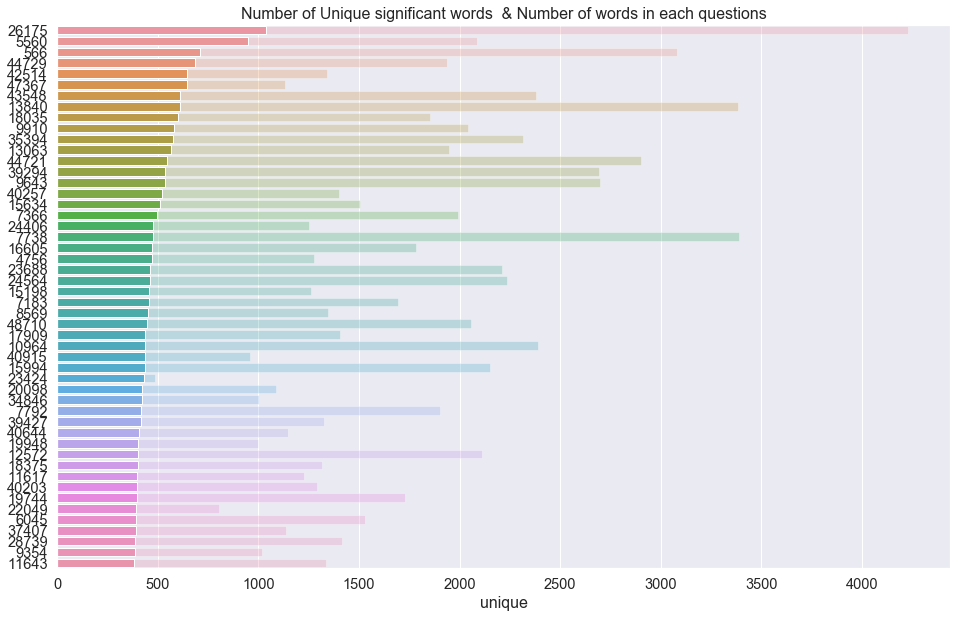

In [72]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique significant words  & Number of words in each questions")
df_plot = df_stats2.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [73]:
df_plot.head()

,total,unique
26175,4227,1035
5560,2087,949
566,3080,708
44729,1937,682
42514,1340,646


In [74]:
df_stats2.loc[26175]

total     4227
unique    1035
Name: 26175, dtype: int64

In [75]:
df_stats.loc[26175]

total     5119
unique    1096
Name: 26175, dtype: int64

### Stems of words in questions

In [76]:
def freq_stats_corpora3():
    '''
    Statistics about stems of words in questions
    '''
    corpora = defaultdict(list)
    stemmer = EnglishStemmer()
    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += \
                [stemmer.stem(w) for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq3, stats3, corpora3 = freq_stats_corpora3()

df_stats3 = pd.DataFrame.from_dict(stats3, orient='index')
df_stats3.head()

,total,unique
3,35,23
4,211,108
9,141,50
10,12,9
12,34,23


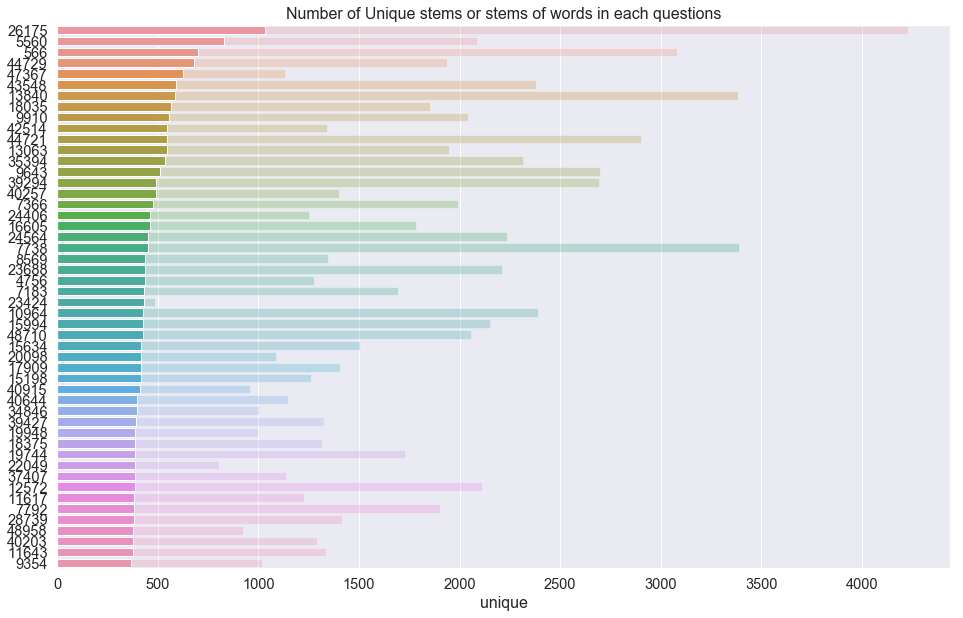

In [77]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique stems or stems of words in each questions")
df_plot = df_stats3.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [78]:
df_plot.head()

,total,unique
26175,4227,1030
5560,2087,829
566,3080,701
44729,1937,681
47367,1132,626


### Cleaning Text

In [79]:
token_dict = dict()
# for each questions, prepare token : lower, no ponctuation
for id_curr, questions_curr in questions.items():
    try:
        # save cleaned text into dict output
        token_dict[id_curr] = cleaning_text(questions_curr) 
    except:
        print('Question {} : Error body empty'.format(id_curr))

Cleaning Example : 

In [80]:
questions[3]

"How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [81]:
token_dict[3]

'insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    '

In [82]:
#df_token = pd.DataFrame(token_dict)
df_token = pd.DataFrame.from_dict(token_dict, orient='index', columns=["token_text"])
df_token.head()

,token_text
3,insert entry table exist table looks sql ser...
4,system dmv s missing sql server master dacpa...
9,insert databse without page reload insert ...
10,upload multipart amazon s3 upload amazon s3 ...
12,db2 sql crosstab would output table transf...


In [83]:
df_token.shape

(21208, 1)

In [84]:
df_quest_cleaned.shape

(21208, 38)

In [85]:
np.all(df_quest_cleaned.index == df_token.index)

True

In [86]:
df_quest_cleaned["token_text"] = df_token["token_text"]
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged_160,flag_most_Tagged_100,flag_most_Tagged_76,flag_most_Tagged_40,Text,token_text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,NaN,True,True,True,False,False,True,True,True,True,How to insert an entry to a table only if it d...,insert entry table exist table looks sql ser...
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,NaN,True,False,False,False,False,True,True,True,True,System DMV's missing from SQL Server 2017 mast...,system dmv s missing sql server master dacpa...
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,NaN,True,True,True,False,False,True,True,True,True,how to insert data in databse without page rel...,insert databse without page reload insert ...
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,NaN,True,True,False,False,False,True,True,True,True,How to upload image using multipart in Amazon ...,upload multipart amazon s3 upload amazon s3 ...
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,NaN,True,False,False,False,False,True,True,True,True,DB2 SQL CROSSTAB <p>I would like to output a t...,db2 sql crosstab would output table transf...


### Separation train/test

In [99]:
train_percent = 0.8
np.random.seed(0)
indices_permut = np.random.permutation(df_quest_cleaned.shape[0])
df_quest_cleaned['Train'] = False
indices_permut_train = indices_permut[0:np.int(len(indices_permut)*train_percent)]
df_quest_cleaned['Train'].iloc[indices_permut_train] = True
df_quest_cleaned['Train'].value_counts()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


True     16966
False     4242
Name: Train, dtype: int64

In [100]:
list_tags_raw_train=[]
for idx in range(0, 
                 df_quest_cleaned[df_quest_cleaned['Train'] == True].shape[0]):

    list_tags_raw_train = list_tags_raw_train + \
                            (re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                            df_quest_cleaned.iloc[idx].Tags))
list_tags_train = np.unique(list_tags_raw_train).tolist()

list_tags_raw_test=[]
for idx in range(0, 
                 df_quest_cleaned[df_quest_cleaned['Train'] == False].shape[0]):

    list_tags_raw_test = list_tags_raw_test + \
                            (re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                            df_quest_cleaned.iloc[idx].Tags))
list_tags_test = np.unique(list_tags_raw_test).tolist()

In [101]:
len(list_tags_train)

7820

In [102]:
len(list_tags_test)

3416

#### Check tags

##### For all  tags  :

In [103]:
print('Nb Tags in test but not in train :')
len(set(list(list_tags_test)).difference(set(list(list_tags_train))))

Nb Tags in test but not in train :


0

In [104]:
print('Nb Tags in train but not in test :')
len(set(list(list_tags_train)).difference(set(list(list_tags_test))))

Nb Tags in train but not in test :


4404

##### For most used Tags :

Check if some Tags, most used from Test set are not into most used from Train set

In [114]:
for idx, list_most_used_curr in enumerate(list_list_most_used):


    list_tags_most_test = set(list_tags_test).\
        intersection(set(list_most_used_curr))
    
    list_tags_most_train = set(list_tags_train).\
        intersection(set(list_most_used_curr))
    print("For {} most used Tags".\
          format(df_most["nb_most_used_tags"].iloc[idx]))
    print('Tags most used in Test not in Train set ?')
    print(list_tags_most_test.difference(list_tags_most_train))
    #list_tags_most_test.difference(list_tags_most_train)   

For 51 most used Tags
Tags most used in Test not in Train set ?
set()
For 73 most used Tags
Tags most used in Test not in Train set ?
set()
For 100 most used Tags
Tags most used in Test not in Train set ?
set()
For 201 most used Tags
Tags most used in Test not in Train set ?
set()


#### List of list of all Tags

In [283]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_all_tags_train = \
    create_tags_list_of_list(
    df_quest_cleaned[df_quest_cleaned.Train == True]["Tags"],
                            list_tags_most_used=None)
print(list_list_all_tags_train[:10])

print('\nFor test set...')  
list_list_all_tags_test = \
    create_tags_list_of_list(
    df_quest_cleaned[df_quest_cleaned.Train == False]["Tags"],
                            list_tags_most_used=None)
print(list_list_all_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server', 'sql-server-data-tools'], ['javascript', 'php', 'ajax'], ['android', 'amazon-s3', 'file-upload', 'multipart'], ['sql', 'db2', 'crosstab'], ['php', 'laravel'], ['python', 'anaconda', 'conda', 'spacy'], ['java', 'jackson'], ['javascript', 'json', 'reactjs', 'object'], ['android']]

For test set...
[['ios', 'objective-c'], ['ios', 'swift', 'storekit'], ['c++', 'qt', 'qt5', 'qchart', 'qchartview'], ['excel', 'vba', 'excel-vba'], ['android', 'gradle', 'fastlane'], ['sql-server', 'sql-server-2008'], ['c#', 'asp.net', 'bootstrap-4'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript', 'angular-routing', 'angular-router']]


#### Encode Multi label 
- First fit over all tags (train & test)
- Transform of list of list into encoded matrix  for :
    - Train real
    - Test real

In [296]:
mlb_lda = MultiLabelBinarizer()
mlb_lda.fit_transform(list_list_all_tags_train + list_list_all_tags_test)
# real
enc_lda_y_train = mlb_lda.transform(list_list_all_tags_train)
print("Train real shape:", enc_lda_y_train.shape)
enc_lda_y_test = mlb_lda.transform(list_list_all_tags_test)
print("Test real shape:", enc_lda_y_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)
Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


## Models unsupervised

In [636]:
no_top_words = 10

In [637]:
def find_doc_freq_word(word_curr, token_dict=token_dict):
    '''
    Calculate document frequency of a word into token_dict
    '''
    tf_vectorizer_special = CountVectorizer(vocabulary=[word_curr])
    tf_special = tf_vectorizer_special.fit_transform(token_dict.values())
    return tf_special.count_nonzero()/len(token_dict)

In [638]:
def find_doc_freq_list_words(list_words, token_dict=token_dict):
    '''
    Calculate document frequency of a list of words into token_dict
    '''
    nb_docs = len(token_dict)
    tf_vectorizer_special = CountVectorizer(vocabulary=list_words)
    tf_special = tf_vectorizer_special.fit_transform(token_dict.values())
    
    freqs_dict = []
    for id_list, word_curr in enumerate(list_words):
        freq_curr = np.nonzero(tf_special[:,id_list].todense())[0]\
            .shape[0]/nb_docs
        freqs_dict.append(freq_curr)
        print("{} = {}".format(word_curr, freq_curr))
    return freqs_dict

special_words = ["sql","c#","apple","ios","microsoft", "windows",
                 "android","google","javascript","php","css","html"]

print("Document Frequencies for")
doc_freqs = find_doc_freq_list_words(special_words)
print("max df = ",np.max(doc_freqs))

Document Frequencies for
sql = 0.05398906073179932
c# = 0.0
apple = 0.007167106752168993
ios = 0.016503206337231232
microsoft = 0.01952093549603923
windows = 0.03456242927197284
android = 0.023764617125612977
google = 0.041399471897397205
javascript = 0.04658619388909845
php = 0.04960392304790645
css = 0.04045643153526971
html = 0.06393813655224444
max df =  0.06393813655224444


### LDA 50 topics

#### Features
max_df=0.11, min_df=10

In [639]:
# init features
tf_vectorizer_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000, 
                                tokenizer=myTokenizer)
tf_1 = tf_vectorizer_1.fit_transform(df_quest_cleaned[df_quest_cleaned.Train ==\
                                                 True]["token_text"])


#### Optim Fit



Train set used only

In [649]:
#Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 30, 'n_components': 50}
#Best Log Likelihood Score:  -2332613.6264004773
#Model Perplexity:  362.02631743586585

# Define Search Param
search_params = {'n_components': [50], 
                 'learning_decay': [.7],
                 'max_iter': [5]}# Init the Model

In [650]:
# init model to optimize
lda_for_gcv_1 = LatentDirichletAllocation(learning_method='online',
                                          learning_offset=50., 
                                          random_state=0,
                                          n_jobs=-1)
# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params)

# Do the Grid Search
t_lda_0 = time.time()
gcv_lda_1.fit(tf_1)
t_lda_1 = time.time()
print("timing total: {} s".format(t_lda_1-t_lda_0))

timing total: 196.342444896698 s


In [651]:
gcv_lda_1.best_params_

{'learning_decay': 0.7, 'max_iter': 5, 'n_components': 50}

In [652]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 5, 'n_components': 50}
Best Log Likelihood Score:  -2348414.9085928295
Model Perplexity:  370.6479546528253


In [653]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0
mean_fit_time,42.1696
std_fit_time,7.95631
mean_score_time,1.69888
std_score_time,0.614529
param_learning_decay,0.7
param_max_iter,5
param_n_components,50
params,"{'learning_decay': 0.7, 'max_iter': 5, 'n_comp..."
split0_test_score,-2.41301e+06
split1_test_score,-2.34245e+06


Topics : 

In [654]:
# create & display topic dictionnary 
topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
url page rout domain websit aw sign redirect web load
Topic 1:
let map state convert func nil kafka decod dictionari topic
Topic 2:
check video buffer char mat arr printf edg durat camera
Topic 3:
server connect client port host http resourc socket ssl servic
Topic 4:
system generat window applic net version microsoft project program framework
Topic 5:
compon this react angular locat const param export prop state
Topic 6:
variabl question paramet pass someth answer seem function case possibl
Topic 7:
php queri sql databas echo mysql connect nbsp conn mysqli
Topic 8:
parent child play root tree children weight curl audio distanc
Topic 9:
input field custom control valid enter requir contact firstnam placehold
Topic 10:
java org apach lang spark util invok worker scala reflect
Topic 11:
array access length token pdf region push author loop foreach
Topic 12:
item link menu action href grid nav temp toggl dropdown
Topic 13:
order product group price descript join role quantiti amo

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [655]:
tf_all_1 = tf_vectorizer_1.transform(df_quest_cleaned["token_text"])

In [656]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [657]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [658]:
df_topics_pred_1.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
3,0.000833,0.000833,0.000833,0.044116,0.000833,0.000833,0.000833,0.134839,0.000833,0.000833,0.000833,0.000833,...,0.000833,0.000833,0.042941,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,0.010715,0.000172,0.000172,0.085942,0.457969,0.000172,0.000172,0.153159,0.000172,0.000172,0.000172,0.000172,...,0.000172,0.000172,0.000172,0.000172,0.024667,0.000172,0.000172,0.000172,0.000172,0.012626,0.000172,0.000172
9,0.028361,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.063893,0.000174,0.000174,0.000174,0.000174,...,0.777587,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174
10,0.200384,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,...,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857
12,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.337870,0.001818,0.001818,0.001818,0.001818,...,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.092854,0.001818,0.001818,0.001818


In [659]:
df_topics_pred_1.shape

(21208, 50)

In [660]:
df_quest_cleaned.shape

(21208, 40)

In [661]:
df_model_1.shape

(21208, 90)

In [662]:
df_model_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.000833,0.000833,0.042941,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000172,0.000172,0.000172,0.000172,0.024667,0.000172,0.000172,0.000172,0.000172,0.012626,0.000172,0.000172
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.777587,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.092854,0.001818,0.001818,0.001818


Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_20', 'Topic_24', 'Topic_7'], dtype='object')
[20, 24, 7]
Topic 20 : option git master insert branch append merg commit featur exist
Topic 24 : tabl row column entiti datafram insert book panda datat nan
Topic 7 : php queri sql databas echo mysql connect nbsp conn mysqli


[20, 24, 7]

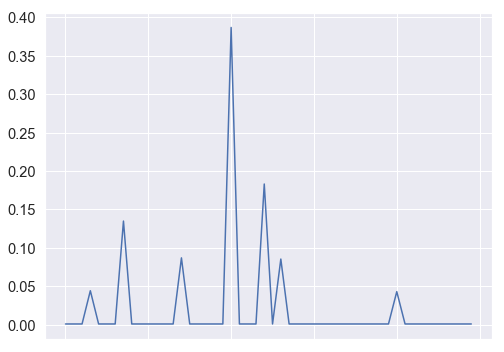

In [663]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source second due output javascript eventlistener first page   scene  m figuring web development n t lot knowledge hope could help out      concept page choose due clicking change second page      linked first page   store source chosen variable result        result          document getelementbyid      choice1       addeventlistener      click            elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice2       addeventlistener      click            elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice3       addeventlistener      click            elem  document getelementbyid      choice3        result   window getcomputedstyle   elem   null    getpropertyvalue      backg

[21, 45]

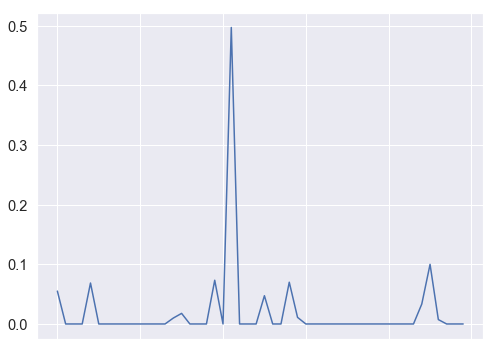

In [664]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
fabric wo n t let link firebase   firebase project  m trying link fabric      go fabric     firebase     integration select   says    already linked          go firebase console     project settings     integrations     fabric   n t see linked   see apps linked   one  m trying link right now      idea could happening   old firebase         fabric link   least see able remove    s nothing   fabric think already linked    s clearly    

Tags :  <firebase><google-fabric>

Index(['Topic_37', 'Topic_5', 'Topic_12', 'Topic_45', 'Topic_4'], dtype='object')
[37, 5, 12, 45, 4]
Topic 37 : implement bind set refer plot mode possibl place interfac yes
Topic 5 : compon this react angular locat const param export prop state
Topic 12 : item link menu action href grid nav temp toggl dropdown
Topic 45 : differ match output two comment anoth express current even ad
Topic 4 : system generat window applic net version microsoft project program framework


[37, 5, 12, 45, 4]

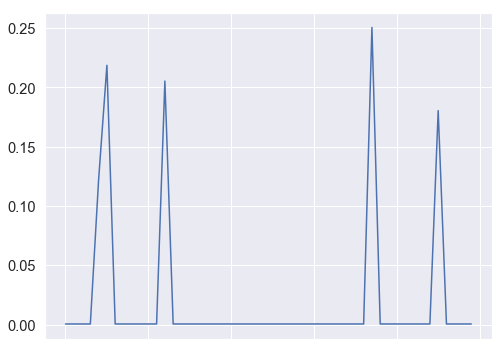

In [665]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Link Tags & Topics

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [666]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, 
                                  data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_tags_topics_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_tags_topics_1 = time.time()
print("timing total: {} s".format(t_tags_topics_1-t_tags_topics_0))


timing total: 261.7940261363983 s


In [667]:
df_topics_tags = df_topics_tags_raw.copy()

In [668]:
df_topics_tags.shape

(8765, 50)

In [669]:
df_topics_tags.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
.app,0.000513,0.000513,0.000513,0.000513,0.127949,0.000513,0.256578,0.000513,0.000513,0.000513,0.000513,0.000513,...,0.000513,0.000513,0.000513,0.000513,0.028941,0.126399,0.000513,0.184207,0.000513,0.000513,0.000513,0.000513
.htaccess,7.716764,0.393978,0.349434,1.727639,0.213272,0.079797,2.332526,2.537274,0.068585,0.178172,0.373027,0.562502,...,0.280921,0.105035,0.339281,0.117180,0.099388,0.542643,0.120392,1.536199,0.085437,0.270533,0.879846,0.056521
.lib,0.000189,0.000189,0.000189,0.000189,0.063971,0.027342,0.000189,0.000189,0.000189,0.000189,0.000189,0.000189,...,0.000189,0.000189,0.000189,0.000189,0.016752,0.000189,0.000189,0.000189,0.000189,0.000189,0.000189,0.040449
.net,1.717008,2.033194,1.190519,5.991421,17.072911,1.325764,15.413027,1.661244,0.318059,2.902198,0.290104,1.028116,...,1.391549,1.537736,1.197419,0.877826,2.304516,4.171756,3.588368,7.398278,0.582428,5.805526,1.717774,3.895626
.net-1.1,0.001111,0.001111,0.001111,0.001111,0.454990,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,...,0.001111,0.001111,0.001111,0.055604,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111


In [670]:
df_model_1[df_model_1["Train"] == True].shape

(16966, 90)

In [671]:
df_model_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.000833,0.000833,0.042941,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000172,0.000172,0.000172,0.000172,0.024667,0.000172,0.000172,0.000172,0.000172,0.012626,0.000172,0.000172
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.777587,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.092854,0.001818,0.001818,0.001818


In [672]:
df_model_1_topics.shape

(16966, 50)

In [673]:
df_model_1_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
3,0.000833,0.000833,0.000833,0.044116,0.000833,0.000833,0.000833,0.134839,0.000833,0.000833,0.000833,0.000833,...,0.000833,0.000833,0.042941,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,0.010715,0.000172,0.000172,0.085942,0.457969,0.000172,0.000172,0.153159,0.000172,0.000172,0.000172,0.000172,...,0.000172,0.000172,0.000172,0.000172,0.024667,0.000172,0.000172,0.000172,0.000172,0.012626,0.000172,0.000172
9,0.028361,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.063893,0.000174,0.000174,0.000174,0.000174,...,0.777587,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174
10,0.200384,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,...,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857
12,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.337870,0.001818,0.001818,0.001818,0.001818,...,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.092854,0.001818,0.001818,0.001818


In [674]:
df_topics_tags.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
.app,0.000513,0.000513,0.000513,0.000513,0.127949,0.000513,0.256578,0.000513,0.000513,0.000513,0.000513,0.000513,...,0.000513,0.000513,0.000513,0.000513,0.028941,0.126399,0.000513,0.184207,0.000513,0.000513,0.000513,0.000513
.htaccess,7.716764,0.393978,0.349434,1.727639,0.213272,0.079797,2.332526,2.537274,0.068585,0.178172,0.373027,0.562502,...,0.280921,0.105035,0.339281,0.117180,0.099388,0.542643,0.120392,1.536199,0.085437,0.270533,0.879846,0.056521
.lib,0.000189,0.000189,0.000189,0.000189,0.063971,0.027342,0.000189,0.000189,0.000189,0.000189,0.000189,0.000189,...,0.000189,0.000189,0.000189,0.000189,0.016752,0.000189,0.000189,0.000189,0.000189,0.000189,0.000189,0.040449
.net,1.717008,2.033194,1.190519,5.991421,17.072911,1.325764,15.413027,1.661244,0.318059,2.902198,0.290104,1.028116,...,1.391549,1.537736,1.197419,0.877826,2.304516,4.171756,3.588368,7.398278,0.582428,5.805526,1.717774,3.895626
.net-1.1,0.001111,0.001111,0.001111,0.001111,0.454990,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,...,0.001111,0.001111,0.001111,0.055604,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111


##### Normalisation by Topics

In [675]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
.app,4.601377e-07,6.073851e-07,1.322070e-06,3.509194e-07,0.000076,3.998909e-07,6.838537e-05,4.917600e-07,1.512510e-06,5.884413e-07,8.404649e-07,6.942228e-07,...,5.162300e-07,6.457166e-07,8.826825e-07,1.070552e-06,0.000041,1.088382e-04,6.510034e-07,6.461088e-05,1.967843e-06,5.778755e-07,8.123180e-07,3.948936e-07
.htaccess,6.924009e-03,4.666285e-04,9.008548e-04,1.182211e-03,0.000127,6.222460e-05,6.216852e-04,2.433073e-03,2.022844e-04,2.044457e-04,6.113566e-04,7.614788e-04,...,2.827887e-04,1.322552e-04,5.839813e-04,2.446221e-04,0.000142,4.672523e-04,1.528321e-04,5.388232e-04,3.278469e-04,3.048523e-04,1.393693e-03,4.352365e-05
.lib,1.692960e-07,2.234719e-07,4.864221e-07,1.291118e-07,0.000038,2.132124e-05,5.028843e-08,1.809306e-07,5.564895e-07,2.165020e-07,3.092277e-07,2.554216e-07,...,1.899337e-07,2.375750e-07,3.247605e-07,3.938825e-07,0.000024,1.624655e-07,2.395201e-07,6.617941e-08,7.240177e-07,2.126146e-07,2.988717e-07,3.114772e-05
.net,1.540617e-03,2.408117e-03,3.069203e-03,4.099886e-03,0.010175,1.033813e-03,4.108014e-03,1.593020e-03,9.380820e-04,3.330158e-03,4.754535e-04,1.391796e-03,...,1.400800e-03,1.936237e-03,2.061034e-03,1.832530e-03,0.003296,3.592163e-03,4.555278e-03,2.594952e-03,2.234947e-03,6.541999e-03,2.720989e-03,2.999797e-03
.net-1.1,9.969651e-07,1.316001e-06,2.864486e-06,7.603253e-07,0.000271,8.664302e-07,2.961430e-07,1.065480e-06,3.277105e-06,1.274956e-06,1.821007e-06,1.504149e-06,...,1.118498e-06,1.399053e-06,1.912479e-06,1.160781e-04,0.000002,9.567415e-07,1.410507e-06,3.897232e-07,4.263660e-06,1.252064e-06,1.760022e-06,8.556027e-07


In [676]:
np.sum(df_topics_tags_norm, axis=0)

Topic_0     1.0
Topic_1     1.0
Topic_2     1.0
Topic_3     1.0
Topic_4     1.0
Topic_5     1.0
Topic_6     1.0
Topic_7     1.0
Topic_8     1.0
Topic_9     1.0
Topic_10    1.0
Topic_11    1.0
Topic_12    1.0
Topic_13    1.0
Topic_14    1.0
Topic_15    1.0
Topic_16    1.0
Topic_17    1.0
Topic_18    1.0
Topic_19    1.0
Topic_20    1.0
Topic_21    1.0
Topic_22    1.0
Topic_23    1.0
Topic_24    1.0
Topic_25    1.0
Topic_26    1.0
Topic_27    1.0
Topic_28    1.0
Topic_29    1.0
Topic_30    1.0
Topic_31    1.0
Topic_32    1.0
Topic_33    1.0
Topic_34    1.0
Topic_35    1.0
Topic_36    1.0
Topic_37    1.0
Topic_38    1.0
Topic_39    1.0
Topic_40    1.0
Topic_41    1.0
Topic_42    1.0
Topic_43    1.0
Topic_44    1.0
Topic_45    1.0
Topic_46    1.0
Topic_47    1.0
Topic_48    1.0
Topic_49    1.0
dtype: float64

In [677]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(8765, 50)

#### Predict tags : Topics Distrib method
Method : 
For each texts of document : 
    - evaluate Topics distrib from LDA
    - for each Topics, multiply by Tags distrib per Topics from table Tags & Topics
    - sum for each Tags to have a score per Tags
    - keeps the nth first ranking Tags 

In [680]:
# example 1st question
text_test = df_quest_cleaned.iloc[0]["Text"]
print(text_test)
# clean the text
text_cleaned = cleaning_text(text_test)

# calculate feature from text
feat_curr =  tf_vectorizer_1.transform([text_cleaned])

# calculate topic distrib
topic_distrib_pred = best_lda_model_1.transform(feat_curr)

How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>

<pre><code>wordId     word      
----------------
1214       pen           
1215       men    
1216       cat  
</code></pre>

<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>



In [681]:
arr_tags = df_topics_tags.values*topic_distrib_pred
arr_tags.shape

(8765, 50)

In [682]:
sum_distrib_tags = arr_tags.sum(axis=1)
sum_distrib_tags.shape

(8765,)

In [683]:
df_sum_tags = pd.DataFrame(data=sum_distrib_tags, columns=["d_sum"], 
                           index=df_topics_tags.index)
df_sum_tags.head()

,d_sum
.app,0.000001
.htaccess,0.000702
.lib,0.000001
.net,0.002238
.net-1.1,0.000002


In [684]:
'''
['php',
 'javascript',
 'python',
 'mysql',
 'html',
 'laravel',
 'vue.js',
 'java',
 'wordpress',
 'sql']
'''
print("\nReal Tags: ", df_quest_cleaned.iloc[0]["Tags"])
print("\nPredicted Tags: ",df_sum_tags.sort_values(by="d_sum", 
                                                 ascending=False).head(10).index)


Real Tags:  <c#><sql><sql-server>

Predicted Tags:  Index(['python', 'javascript', 'php', 'git', 'sql', 'mysql', 'java', 'c#',
       'sql-server', 'html'],
      dtype='object')


In [685]:
find_tags_from_dtopics(topic_distrib_pred, df_topics_tags, no_max=10)

['python',
 'javascript',
 'php',
 'git',
 'sql',
 'mysql',
 'java',
 'c#',
 'sql-server',
 'html']

In [686]:
# example  question
text_test = df_quest_cleaned.iloc[0]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[0]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)


How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>

<pre><code>wordId     word      
----------------
1214       pen           
1215       men    
1216       cat  
</code></pre>

<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>

Tags :  <c#><sql><sql-server>


['python',
 'javascript',
 'php',
 'git',
 'sql',
 'mysql',
 'java',
 'c#',
 'sql-server',
 'html']

In [687]:
# example  question
text_test = df_quest_cleaned.iloc[18]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[18]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)


Display name of properties when looping through errors <p>I am new to Spring so bear with me!</p>

<p>I am trying to adjust the display name of properties of an entity in Spring boot.</p>

<p>I have a form with the following inside to display all errors:</p>

<pre><code>&lt;ul&gt;
    &lt;li th:each="e : ${#fields.detailedErrors()}" th:class="${e.global}? globalerr : fielderr"&gt;
        &lt;span th:text="${e.global}? '*' : ${e.fieldName}"&gt;The field name&lt;/span&gt;
        &lt;span th:text="${e.message}"&gt;The error message&lt;/span&gt;
    &lt;/li&gt;
&lt;/ul&gt;
</code></pre>

<p>That results in the following message upon invalid input:</p>

<blockquote>
  <p>Error Saving New User - Please Try Again
  lastName must not be empty <br>
  firstName size must be between 1 and 30<br>
  lastName size must be between 1 and 30<br>
  firstName must not be empty<br></p>
</blockquote>

<p>I have tried adjusting the property to accommodate a display name to no avail:</p>

<pre><code>@NotEm

['javascript',
 'python',
 'java',
 'php',
 'c#',
 'html',
 'jquery',
 'angular',
 'sql',
 'android']

In [688]:
# example  question
text_test = df_quest_cleaned.iloc[123]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[123]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)


Updating source of an image in a second html due to output of a JavaScript eventlistener of the first html page <p>just to set the scene I'm figuring out web development on my own so don't have a lot of knowledge and I hope you could help me out.</p>

<p>So the concept is on HTML page 1 I choose a image and due to the clicking I change it in the second html page.</p>

<p>This is the js file linked to the first html page. Here I store my source of the chosen image in the variable result.</p>

<pre><code>result="";

document.getElementById("choice1").addEventListener("click", function() { 
var elem =document.getElementById("choice1");
result = window.getComputedStyle(elem, null).getPropertyValue("background-image");
return result
});

document.getElementById("choice2").addEventListener("click", function() { 
var elem =document.getElementById("choice2");
result  = window.getComputedStyle(elem, null).getPropertyValue("background-image");
return result
});

document.getElementById("choice3"

['javascript',
 'html',
 'jquery',
 'python',
 'css',
 'php',
 'java',
 'c#',
 'android',
 'angular']

#### Evaluation Topics Distrib method



##### Create list of list with Predicted Tags for each Text Questions list

In [689]:
t_train_0 = time.time() 
list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)
t_train_1 = time.time()

t_pred_0 = time.time() 
list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_pred_1 = time.time() # time to predict test
print("timing total: {} s".format(t_pred_1-t_train_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 330.91690611839294 s

For Train:
 [['python', 'javascript', 'php', 'git', 'sql', 'mysql', 'java', 'c#', 'sql-server', 'html'], ['c#', 'python', 'php', 'java', 'javascript', 'android', 'mysql', 'sql', 'git', 'html'], ['javascript', 'html', 'jquery', 'php', 'css', 'python', 'c#', 'angular', 'java', 'ajax'], ['javascript', 'python', 'java', 'php', 'c#', 'android', 'angular', 'html', 'node.js', 'r'], ['php', 'sql', 'python', 'mysql', 'pandas', 'sql-server', 'javascript', 'c#', 'java', 'r'], ['python', 'javascript', 'php', 'java', 'node.js', 'c#', 'android', 'angular', 'mysql', 'html'], ['python', 'r', 'javascript', 'java', 'android', 'c#', 'php', 'python-3.x', 'sql', 'c++'], ['android', 'java', 'javascript', 'python', 'c#', 'php', 'angular', 'json', 'html', 'sql'], ['javascript', 'python', 'java', 'c#', 'php', 'html', 'jquery', 'android', 'angular', 'reactjs'], ['python', 'javascript', 'java', 'php', 'c#', 'android', 'html', 'c++', 'excel', 'vba']]

For Test:
 [['javascript',

In [693]:
len(list_list_all_tags_train)

16966

In [694]:
len(list_tags_predicted_train)

16966

In [695]:
len(list_list_all_tags_test)

4242

In [696]:
len(list_tags_predicted_test)

4242

##### Encode predictions

For : 
    - Train predicted
    - Test predicted

In [697]:
# predicted
enc_lda_ypred_train = mlb_lda.transform(list_tags_predicted_train)
print("Train real shape:", enc_lda_ypred_train.shape)
enc_lda_ypred_test = mlb_lda.transform(list_tags_predicted_test)
print("Test real shape:", enc_lda_ypred_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


In [698]:
df_Tags.shape

(8765, 1)

##### Evaluate different scorings

In [699]:
accuracy_score(enc_lda_y_train, enc_lda_ypred_train)

0.0

In [700]:
accuracy_score(enc_lda_y_test, enc_lda_ypred_test)

0.0

In [701]:
precision_score(enc_lda_y_train, enc_lda_ypred_train, average='micro')

0.09141223623718024

In [702]:
precision_score(enc_lda_y_test, enc_lda_ypred_test, average='micro')

0.08915605846298916

In [703]:
recall_score(enc_lda_y_train, enc_lda_ypred_train, average='micro')

0.31011177540940993

In [704]:
recall_score(enc_lda_y_test, enc_lda_ypred_test, average='micro')

0.3010906774938301

In [705]:
f1_score(enc_lda_y_train, enc_lda_ypred_train, average='micro')

0.1412020703688698

In [706]:
f1_score(enc_lda_y_test, enc_lda_ypred_test, average='micro')

0.13757479856677762

In [707]:
2 * (0.09141223623718024 * 0.31011177540940993) / (0.09141223623718024 + 0.31011177540940993)

0.1412020703688698

In [708]:
find_nb_no_tags(enc_lda_ypred_train)
find_nb_no_tags(enc_lda_ypred_test)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


0

In [720]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0,
                          t_pred_1 - t_pred_0)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


In [721]:
df_results = add_score(df_results, series_scores, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     no_top_words))
df_results

update line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,29.683593,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,458.132445,61.726915


##### Evaluate for each nb Tags max

In [724]:
for nb_tags_max in [1, 2, 3, 4, 5, 6]:
    # select max tags
    list_tags_predicted_train_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_train]
    list_tags_predicted_test_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_test]
    # predict
    enc_lda_ypred_train_curr = mlb_lda.transform(list_tags_predicted_train_curr)
    enc_lda_ypred_test_curr = mlb_lda.transform(list_tags_predicted_test_curr)
    # score
    series_scores_curr = evaluate_mdl_scorings(enc_lda_y_train, 
                          enc_lda_ypred_train_curr,
                          enc_lda_y_test, 
                          enc_lda_ypred_test_curr, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0, 
                          t_pred_1-t_pred_0)
    df_results = add_score(df_results, series_scores_curr, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     nb_tags_max))
df_results

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,29.683593,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags1,0.016798,0.016973,0.276907,0.273220,0.093939,0.092270,0.140287,0.137952,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags2,0.007073,0.007308,0.200666,0.192008,0.136150,0.129687,0.162229,0.154811,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags3,0.002417,0.002593,0.169339,0.159437,0.172342,0.161532,0.170827,0.160478,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags4,0.000648,0.000236,0.149829,0.143446,0.203315,0.193774,0.172522,0.164855,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags5,0.000000,0.000000,0.135801,0.132249,0.230349,0.223310,0.170868,0.166119,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags6,0.000000,0.000000,0.123443,0.121091,0.251265,0.245363,0.165552,0.162155,0.000000,0.000000,458.132445,61.726915


### LDA 25 Topics

#### Optim Fit

Features same : max_df=0.11, min_df=10

Train set used only

In [725]:
# Define Search Param
search_params = {'n_components': [25], 
                 'learning_decay': [.7],
                 'max_iter': [5, 10, 20]}# Init the Model

In [726]:
lda_for_gcv_1 = LatentDirichletAllocation(learning_method='online', 
                                        learning_offset=50., random_state=0,
                                       n_jobs=-1)# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params)

# Do the Grid Search
t_lda_0 = time.time()
gcv_lda_1.fit(tf_1)
t_lda_1 = time.time()
print("timing total: {} s".format(t_lda_1-t_lda_0))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


timing total: 527.2340869903564 s


In [727]:
gcv_lda_1.best_params_

{'learning_decay': 0.7, 'max_iter': 20, 'n_components': 25}

In [729]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 20, 'n_components': 25}
Best Log Likelihood Score:  -2352259.9177970863
Model Perplexity:  382.49571830468227


In [731]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

,0,1,2
mean_fit_time,21.5242,38.4948,71.4514
std_fit_time,1.67176,1.00375,1.20584
mean_score_time,0.994078,0.987191,0.983127
std_score_time,0.00807793,0.0383445,0.0312288
param_learning_decay,0.7,0.7,0.7
param_max_iter,5,10,20
param_n_components,25,25,25
params,"{'learning_decay': 0.7, 'max_iter': 5, 'n_comp...","{'learning_decay': 0.7, 'max_iter': 10, 'n_com...","{'learning_decay': 0.7, 'max_iter': 20, 'n_com..."
split0_test_score,-2.43687e+06,-2.43101e+06,-2.42588e+06
split1_test_score,-2.35385e+06,-2.34534e+06,-2.34085e+06


Topics : 

In [732]:
# create & display topic dictionnary 

topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
debug set devic enabl video stream domain step frame mode
Topic 1:
self print def val python django init serial func worker
Topic 2:
button form div label input option click span btn control
Topic 3:
server connect client password usernam session host port job authent
Topic 4:
project node version generat window xml sourc net applic librari
Topic 5:
compon map state event key react const angular export render
Topic 6:
this param paramet bind observ privat attribut constructor student subscrib
Topic 7:
tabl queri null row sql databas column insert mysql echo
Topic 8:
column row input data csv train num output sum plot
Topic 9:
model field index custom valid spark entiti control max record
Topic 10:
system void privat task thread static process except command start
Topic 11:
array variabl number question element differ two length loop second
Topic 12:
item data link menu tab icon templat word href nav
Topic 13:
date product group count order filter categori price day descript
To

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [733]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [734]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [735]:
df_topics_pred_1.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24
3,0.001667,0.001667,0.001667,0.050379,0.001667,0.001667,0.001667,0.720540,0.001667,0.001667,0.001667,0.125687,0.068394,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667
4,0.000345,0.000345,0.000345,0.119505,0.545038,0.000345,0.000345,0.161414,0.000345,0.000345,0.000345,0.000345,0.000345,0.000345,0.027700,0.000345,0.000345,0.104171,0.000345,0.000345,0.000345,0.025383,0.000345,0.000345,0.010582
9,0.000348,0.000348,0.744151,0.000348,0.000348,0.000348,0.000348,0.046507,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.075559,0.000348,0.126479
10,0.005714,0.005714,0.005714,0.194633,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.207047,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.472606
12,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.613237,0.303127,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636


In [736]:
df_topics_pred_1.shape

(21208, 25)

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_7', 'Topic_11'], dtype='object')
[7, 11]
Topic 7 : tabl queri null row sql databas column insert mysql echo
Topic 11 : array variabl number question element differ two length loop second


[7, 11]

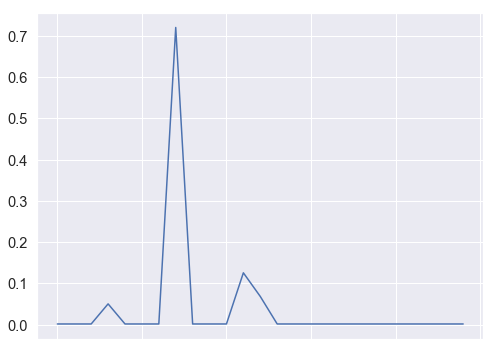

In [737]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source second due output javascript eventlistener first page   scene  m figuring web development n t lot knowledge hope could help out      concept page choose due clicking change second page      linked first page   store source chosen variable result        result          document getelementbyid      choice1       addeventlistener      click            elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice2       addeventlistener      click            elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice3       addeventlistener      click            elem  document getelementbyid      choice3        result   window getcomputedstyle   elem   null    getpropertyvalue      backg

[21, 19, 4]

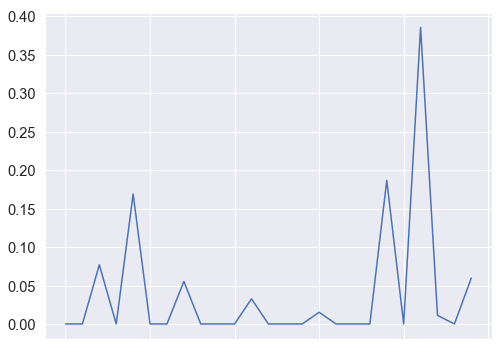

In [738]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
fabric wo n t let link firebase   firebase project  m trying link fabric      go fabric     firebase     integration select   says    already linked          go firebase console     project settings     integrations     fabric   n t see linked   see apps linked   one  m trying link right now      idea could happening   old firebase         fabric link   least see able remove    s nothing   fabric think already linked    s clearly    

Tags :  <firebase><google-fabric>

Index(['Topic_14', 'Topic_5', 'Topic_12', 'Topic_4', 'Topic_20'], dtype='object')
[14, 5, 12, 4, 20]
Topic 14 : end cell match rang sub remov replac next copi current
Topic 5 : compon map state event key react const angular export render
Topic 12 : item data link menu tab icon templat word href nav
Topic 4 : project node version generat window xml sourc net applic librari
Topic 20 : springframework releas spring core properti depend bean boot plugin web


[14, 5, 12, 4, 20]

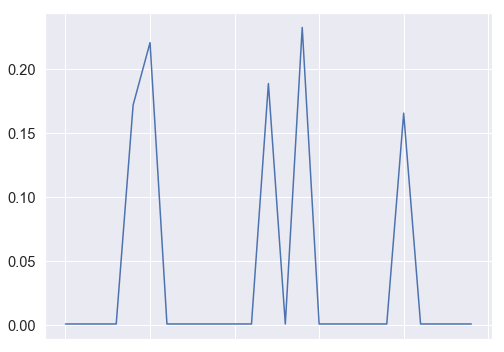

In [739]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Link Tags & Topics

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [740]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, 
                                  data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_tags_topics_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_tags_topics_1 = time.time()
print("timing total: {} s".format(t_tags_topics_1-t_tags_topics_0))


timing total: 189.41578817367554 s


In [741]:
df_topics_tags = df_topics_tags_raw.copy()

In [742]:
df_topics_tags.shape

(8765, 25)

In [743]:
df_topics_tags.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24
.app,0.064783,0.001026,0.001026,0.001026,0.152502,0.001026,0.001026,0.001026,0.032298,0.001026,0.101297,0.216141,0.079408,0.001026,0.178122,0.001026,0.001026,0.093241,0.001026,0.001026,0.034576,0.032248,0.001026,0.001026,0.001026
.htaccess,1.330148,0.185195,0.176659,1.528784,0.293410,0.215193,0.296191,0.790704,0.036806,1.173876,0.372193,1.351944,0.051121,0.828337,3.115249,1.599203,0.316060,3.198039,0.400534,0.600683,0.152534,1.147449,0.367033,0.109776,14.362880
.lib,0.000377,0.000377,0.000377,0.000377,0.118910,0.013602,0.059162,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.666157,0.124549,0.000377,0.010449,0.000377,0.000377,0.000377,0.000377,0.000377
.net,3.602862,1.133438,2.618831,8.006484,20.181267,3.140006,2.073712,5.048484,2.135131,4.175702,17.344988,14.495779,1.506916,4.347102,14.043037,10.698431,3.371504,5.074928,0.417674,2.134166,3.515936,6.823965,2.672975,0.870821,3.565862
.net-1.1,0.002222,0.002222,0.002222,0.002222,0.466358,0.068058,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.264118,0.154799,0.002222,0.002222,0.002222,0.002222


In [744]:
df_model_1_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24
3,0.001667,0.001667,0.001667,0.050379,0.001667,0.001667,0.001667,0.720540,0.001667,0.001667,0.001667,0.125687,0.068394,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667
4,0.000345,0.000345,0.000345,0.119505,0.545038,0.000345,0.000345,0.161414,0.000345,0.000345,0.000345,0.000345,0.000345,0.000345,0.027700,0.000345,0.000345,0.104171,0.000345,0.000345,0.000345,0.025383,0.000345,0.000345,0.010582
9,0.000348,0.000348,0.744151,0.000348,0.000348,0.000348,0.000348,0.046507,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.000348,0.075559,0.000348,0.126479
10,0.005714,0.005714,0.005714,0.194633,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.207047,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.005714,0.472606
12,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.613237,0.303127,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636,0.003636


##### Normalisation by Topics

In [745]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24
.app,4.820373e-05,8.753687e-07,4.952864e-07,4.155258e-07,0.000054,5.802494e-07,0.000001,4.273103e-07,1.488932e-05,8.144579e-07,5.370123e-05,4.612360e-05,8.352948e-05,7.336092e-07,3.973605e-05,3.687481e-07,7.003587e-07,3.478406e-05,1.187891e-06,4.072339e-07,3.822218e-05,1.783882e-05,7.738731e-07,7.448929e-07,4.147268e-07
.htaccess,9.897401e-04,1.580606e-04,8.530950e-05,6.193680e-04,0.000104,1.217439e-04,0.000312,3.294288e-04,1.696742e-05,9.321709e-04,1.973125e-04,2.884995e-04,5.377455e-05,5.924838e-04,6.949591e-04,5.749604e-04,2.158213e-04,1.193045e-03,4.638964e-04,2.385030e-04,1.686199e-04,6.347506e-04,2.769359e-04,7.972692e-05,5.807755e-03
.lib,2.807860e-07,3.220696e-07,1.822280e-07,1.528821e-07,0.000042,7.695510e-06,0.000062,1.572179e-07,1.739625e-07,2.996590e-07,2.000507e-07,8.052679e-08,3.969459e-07,2.699128e-07,8.418226e-08,1.356715e-07,4.548853e-04,4.646377e-05,4.370541e-07,4.148854e-06,4.171540e-07,2.087487e-07,2.847269e-07,2.740644e-07,1.525882e-07
.net,2.680828e-03,9.673721e-04,1.264645e-03,3.243728e-03,0.007182,1.776437e-03,0.002182,2.103337e-03,9.842971e-04,3.315910e-03,9.195174e-03,3.093341e-03,1.585135e-03,3.109347e-03,3.132763e-03,3.846401e-03,2.302230e-03,1.893228e-03,4.837476e-04,8.473772e-04,3.886720e-03,3.774908e-03,2.016830e-03,6.324514e-04,1.441887e-03
.net-1.1,1.653518e-06,1.896632e-06,1.073121e-06,9.003060e-07,0.000166,3.850339e-05,0.000002,9.258389e-07,1.024446e-06,1.764659e-06,1.178076e-06,4.742133e-07,2.337570e-06,1.589487e-06,4.957400e-07,7.989543e-07,1.517444e-06,8.290116e-07,2.573763e-06,1.048688e-04,1.711243e-04,1.229298e-06,1.676725e-06,1.613935e-06,8.985748e-07


In [746]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(8765, 25)

#### Evaluation Topics Distrib method



##### Create list of list with Predicted Tags for each Text Questions list

In [747]:
       
t_train_0 = time.time() 
list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_train_1 = time.time()

t_pred_0 = time.time() 
list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_pred_1 = time.time() # time to predict test
print("timing total: {} s".format(t_pred_1-t_train_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 279.52294874191284 s

For Train:
 [['sql', 'mysql', 'php', 'sql-server', 'javascript', 'python', 'c#', 'java', 'oracle', 'html'], ['c#', 'python', 'java', 'javascript', 'android', 'php', 'sql', 'mysql', 'sql-server', 'c++'], ['javascript', 'html', 'jquery', 'php', 'css', 'c#', 'python', 'angular', 'java', 'ajax'], ['php', 'javascript', 'python', 'java', 'c#', 'html', 'node.js', 'android', 'jquery', 'laravel'], ['sql', 'python', 'mysql', 'php', 'sql-server', 'r', 'javascript', 'pandas', 'java', 'c#'], ['python', 'javascript', 'php', 'java', 'android', 'node.js', 'c#', 'html', 'django', 'angular'], ['python', 'javascript', 'java', 'c#', 'node.js', 'python-3.x', 'php', 'android', 'git', 'r'], ['java', 'c#', 'python', 'javascript', 'android', 'php', 'c++', 'multithreading', 'sql', 'python-3.x'], ['javascript', 'python', 'php', 'java', 'c#', 'android', 'node.js', 'angular', 'sql', 'html'], ['python', 'javascript', 'java', 'php', 'c#', 'sql', 'c++', 'r', 'mysql', 'excel']]

For

##### Encode predictions

For : 
    - Train predicted
    - Test predicted

In [748]:
# predicted
enc_lda_ypred_train = mlb_lda.transform(list_tags_predicted_train)
print("Train real shape:", enc_lda_ypred_train.shape)
enc_lda_ypred_test = mlb_lda.transform(list_tags_predicted_test)
print("Test real shape:", enc_lda_ypred_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


##### Evaluate different scorings

In [749]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


In [750]:
df_results = add_score(df_results, series_scores, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     no_top_words))
df_results

add line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,29.683593,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags1,0.016798,0.016973,0.276907,0.273220,0.093939,0.092270,0.140287,0.137952,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags2,0.007073,0.007308,0.200666,0.192008,0.136150,0.129687,0.162229,0.154811,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags3,0.002417,0.002593,0.169339,0.159437,0.172342,0.161532,0.170827,0.160478,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags4,0.000648,0.000236,0.149829,0.143446,0.203315,0.193774,0.172522,0.164855,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags5,0.000000,0.000000,0.135801,0.132249,0.230349,0.223310,0.170868,0.166119,0.000000,0.000000,458.132445,61.726915
LDA_top50_tags6,0.000000,0.000000,0.123443,0.121091,0.251265,0.245363,0.165552,0.162155,0.000000,0.000000,458.132445,61.726915
LDA_top25_tags10,0.000000,0.000000,0.089043,0.087176,0.302074,0.294403,0.137542,0.134519,0.000000,0.000000,61.726915,53.785460


##### Evaluate for each nb Tags max

In [751]:
for nb_tags_max in [1, 2, 3, 4, 5, 6]:
    # select max tags
    list_tags_predicted_train_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_train]
    list_tags_predicted_test_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_test]
    # predict
    enc_lda_ypred_train_curr = mlb_lda.transform(list_tags_predicted_train_curr)
    enc_lda_ypred_test_curr = mlb_lda.transform(list_tags_predicted_test_curr)
    # score
    series_scores_curr = evaluate_mdl_scorings(enc_lda_y_train, 
                          enc_lda_ypred_train_curr,
                          enc_lda_y_test, 
                          enc_lda_ypred_test_curr, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0, 
                          t_pred_1-t_pred_0)
    df_results = add_score(df_results, series_scores_curr, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     nb_tags_max))
df_results

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,2.968359e+01,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags1,0.016798,0.016973,0.276907,0.273220,0.093939,0.092270,0.140287,0.137952,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags2,0.007073,0.007308,0.200666,0.192008,0.136150,0.129687,0.162229,0.154811,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags3,0.002417,0.002593,0.169339,0.159437,0.172342,0.161532,0.170827,0.160478,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags4,0.000648,0.000236,0.149829,0.143446,0.203315,0.193774,0.172522,0.164855,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags5,0.000000,0.000000,0.135801,0.132249,0.230349,0.223310,0.170868,0.166119,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags6,0.000000,0.000000,0.123443,0.121091,0.251265,0.245363,0.165552,0.162155,0.000000,0.000000,4.581324e+02,61.726915
LDA_top25_tags10,0.000000,0.000000,0.089043,0.087176,0.302074,0.294403,0.137542,0.134519,0.000000,0.000000,6.172691e+01,53.785460
LDA_top25_tags1,0.015207,0.016030,0.277732,0.274399,0.094219,0.092668,0.140705,0.138547,0.000000,0.000000,3.143305e+09,53.785460


### LDA 100 Topics

#### Optim Fit

Features same : max_df=0.11, min_df=10

Train set used only

In [752]:
# Define Search Param
search_params = {'n_components': [100], 
                 'learning_decay': [.7],
                 'max_iter': [5, 10, 20]}# Init the Model

In [753]:
lda_for_gcv_1 = LatentDirichletAllocation(learning_method='online', 
                                        learning_offset=50., random_state=0,
                                       n_jobs=-1)# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params)

# Do the Grid Search
t_lda_0 = time.time()
gcv_lda_1.fit(tf_1)
t_lda_1 = time.time()
print("timing total: {} s".format(t_lda_1-t_lda_0))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


timing total: 844.3184351921082 s


In [754]:
gcv_lda_1.best_params_

{'learning_decay': 0.7, 'max_iter': 20, 'n_components': 100}

In [755]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.7, 'max_iter': 20, 'n_components': 100}
Best Log Likelihood Score:  -2342966.119015316
Model Perplexity:  368.8572202498595


In [756]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0,1,2
mean_fit_time,35.3068,61.022,118.101
std_fit_time,5.10906,0.715228,2.54377
mean_score_time,1.14995,1.21683,1.13432
std_score_time,0.0110803,0.106221,0.0142219
param_learning_decay,0.7,0.7,0.7
param_max_iter,5,10,20
param_n_components,100,100,100
params,"{'learning_decay': 0.7, 'max_iter': 5, 'n_comp...","{'learning_decay': 0.7, 'max_iter': 10, 'n_com...","{'learning_decay': 0.7, 'max_iter': 20, 'n_com..."
split0_test_score,-2.43654e+06,-2.42431e+06,-2.41797e+06
split1_test_score,-2.34245e+06,-2.33414e+06,-2.33009e+06


Topics : 

In [757]:
# create & display topic dictionnary 

topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
effect store timeout hour wonder sheet domain great manual combin
Topic 1:
web resourc secur ssl agent certif constraint ident verifi allow
Topic 2:
label length photo min month arr edit set sender yet
Topic 3:
void view overrid this price model context activ oncreat click
Topic 4:
match rout mode hello contact pattern laravel world free exact
Topic 5:
key right player handler left migrat asset press move current
Topic 6:
this word attribut student channel languag subscrib next constructor foreach
Topic 7:
tabl databas sql echo mysql queri insert book conn record
Topic 8:
index color posit modal asp section red blue pos squar
Topic 9:
singl sourc email filter phone subscrib iter back achiev anoth
Topic 10:
bar plot score chart axi panda point seri mean zero
Topic 11:
row column col datafram datat nan age uniqu drop base
Topic 12:
item link menu href grid nav temp dropdown navbar toggl
Topic 13:
order product price join inner quantiti desc left queri descript
Topic 14:
nav devi

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [758]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [759]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [760]:
df_topics_pred_1.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_88,Topic_89,Topic_90,Topic_91,Topic_92,Topic_93,Topic_94,Topic_95,Topic_96,Topic_97,Topic_98,Topic_99
3,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.084731,0.394752,0.000417,0.000417,0.000417,0.000417,...,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417
4,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.117589,0.000086,0.000086,0.000086,0.000086,...,0.398352,0.094914,0.000086,0.011058,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086
9,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,...,0.000087,0.000087,0.000087,0.054886,0.000087,0.000087,0.000087,0.026213,0.000087,0.000087,0.000087,0.000087
10,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,...,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429
12,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.368838,0.000909,0.000909,0.000909,0.432387,...,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909


In [761]:
df_topics_pred_1.shape

(21208, 100)

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_7', 'Topic_18', 'Topic_34'], dtype='object')
[7, 18, 34]
Topic 7 : tabl databas sql echo mysql queri insert book conn record
Topic 18 : string folder copi docker driver remot exist selenium compos machin
Topic 34 : end sub entri dim begin card procedur next start topic


[7, 18, 34]

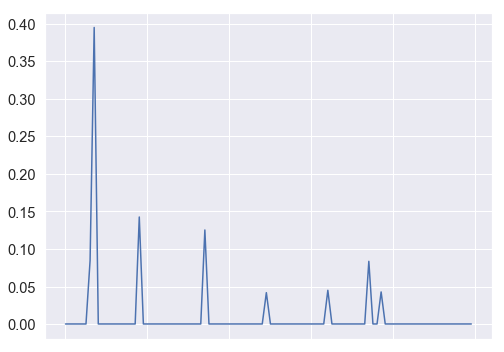

In [762]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source second due output javascript eventlistener first page   scene  m figuring web development n t lot knowledge hope could help out      concept page choose due clicking change second page      linked first page   store source chosen variable result        result          document getelementbyid      choice1       addeventlistener      click            elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice2       addeventlistener      click            elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice3       addeventlistener      click            elem  document getelementbyid      choice3        result   window getcomputedstyle   elem   null    getpropertyvalue      backg

[21]

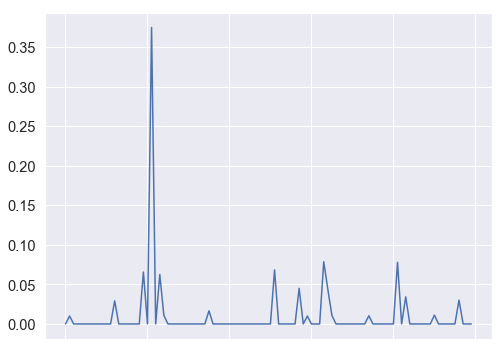

In [763]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
fabric wo n t let link firebase   firebase project  m trying link fabric      go fabric     firebase     integration select   says    already linked          go firebase console     project settings     integrations     fabric   n t see linked   see apps linked   one  m trying link right now      idea could happening   old firebase         fabric link   least see able remove    s nothing   fabric think already linked    s clearly    

Tags :  <firebase><google-fabric>

Index(['Topic_20', 'Topic_12', 'Topic_86', 'Topic_88', 'Topic_64'], dtype='object')
[20, 12, 86, 88, 64]
Topic 20 : command start process remov pdf exit exe termin output shell
Topic 12 : item link menu href grid nav temp dropdown navbar toggl
Topic 86 : android googl support gradl app play firebas tool implement sdk
Topic 88 : project microsoft framework refer librari visual studio develop cloud cmake
Topic 64 : question differ someth seem two possibl howev solut anoth answer


[20, 12, 86, 88, 64]

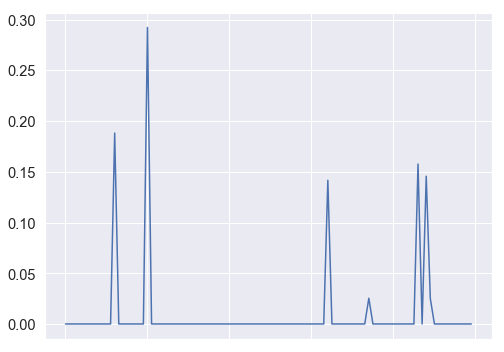

In [764]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Link Tags & Topics

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [765]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, 
                                  data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_tags_topics_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_tags_topics_1 = time.time()
print("timing total: {} s".format(t_tags_topics_1-t_tags_topics_0))


timing total: 231.8429090976715 s


In [766]:
df_topics_tags = df_topics_tags_raw.copy()

In [767]:
df_topics_tags.shape

(8765, 100)

In [768]:
df_topics_tags.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_88,Topic_89,Topic_90,Topic_91,Topic_92,Topic_93,Topic_94,Topic_95,Topic_96,Topic_97,Topic_98,Topic_99
.app,0.000256,0.026014,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,...,0.000256,0.077243,0.000256,0.000256,0.028869,0.000256,0.061172,0.000256,0.000256,0.000256,0.000256,0.000256
.htaccess,0.009201,0.239221,0.009201,0.009201,0.162547,0.056645,0.124464,0.190718,0.694184,0.009201,0.072988,0.085351,...,0.111114,0.418477,0.206084,0.519097,0.067957,0.009201,0.146101,2.062649,0.032980,0.105613,0.009201,0.009201
.lib,0.000094,0.000094,0.000094,0.000094,0.000094,0.009723,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,...,0.094438,0.041430,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.007633,0.000094
.net,0.034937,1.531847,0.034937,0.034937,0.625985,1.231911,0.886900,2.390397,0.944912,0.034937,0.165691,1.739440,...,7.440581,1.059800,1.869520,1.103791,3.689143,0.034937,0.906861,0.393307,1.835330,2.252455,1.833462,0.034937
.net-1.1,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,...,0.114726,0.055242,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.174847,0.000556


In [769]:
df_model_1_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_88,Topic_89,Topic_90,Topic_91,Topic_92,Topic_93,Topic_94,Topic_95,Topic_96,Topic_97,Topic_98,Topic_99
3,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.084731,0.394752,0.000417,0.000417,0.000417,0.000417,...,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417
4,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.117589,0.000086,0.000086,0.000086,0.000086,...,0.398352,0.094914,0.000086,0.011058,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086
9,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,...,0.000087,0.000087,0.000087,0.054886,0.000087,0.000087,0.000087,0.026213,0.000087,0.000087,0.000087,0.000087
10,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,...,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429
12,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.368838,0.000909,0.000909,0.000909,0.432387,...,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909,0.000909


##### Normalisation by Topics

In [770]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_88,Topic_89,Topic_90,Topic_91,Topic_92,Topic_93,Topic_94,Topic_95,Topic_96,Topic_97,Topic_98,Topic_99
.app,0.000019,7.811807e-05,0.000019,0.000019,6.797883e-07,7.025448e-07,5.718895e-07,2.328874e-07,5.214930e-07,0.000019,5.401081e-07,2.888791e-07,...,2.954593e-07,0.000144,2.531465e-07,4.406306e-07,4.259378e-05,0.000019,1.741385e-04,6.723837e-07,4.450957e-07,3.974212e-07,4.479983e-07,0.000019
.htaccess,0.000667,7.183641e-04,0.000667,0.000667,4.309414e-04,1.552040e-04,2.776001e-04,1.732212e-04,1.411847e-03,0.000667,1.537438e-04,9.615872e-05,...,1.280356e-04,0.000779,2.034607e-04,8.920471e-04,1.002653e-04,0.000667,4.159026e-04,5.408878e-03,5.724867e-05,1.636938e-04,1.607664e-05,0.000667
.lib,0.000007,2.832954e-07,0.000007,0.000007,2.501108e-07,2.663969e-05,2.104122e-07,8.568497e-08,1.918701e-07,0.000007,1.987190e-07,1.062857e-07,...,1.088206e-04,0.000077,9.313881e-08,1.621188e-07,1.391904e-07,0.000007,2.685551e-07,2.473865e-07,1.637616e-07,1.462210e-07,1.333560e-05,0.000007
.net,0.002531,4.600031e-03,0.002531,0.002531,1.659596e-03,3.375345e-03,1.978115e-03,2.171104e-03,1.921784e-03,0.002531,3.490152e-04,1.959702e-03,...,8.573718e-03,0.001972,1.845724e-03,1.896820e-03,5.443027e-03,0.002531,2.581547e-03,1.031366e-03,3.185901e-03,3.491176e-03,3.203413e-03,0.002531
.net-1.1,0.000040,1.668295e-06,0.000040,0.000040,1.472875e-06,1.522180e-06,1.239094e-06,5.045893e-07,1.129901e-06,0.000040,1.170234e-06,6.259047e-07,...,1.321982e-04,0.000103,5.484841e-07,9.546996e-07,8.196766e-07,0.000040,1.581491e-06,1.456831e-06,9.643740e-07,8.610793e-07,3.054915e-04,0.000040


In [771]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(8765, 100)

#### Evaluation Topics Distrib method



##### Create list of list with Predicted Tags for each Text Questions list

In [772]:
       
t_train_0 = time.time() 
list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_train_1 = time.time()

t_pred_0 = time.time() 
list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_pred_1 = time.time() # time to predict test
print("timing total: {} s".format(t_pred_1-t_train_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 384.95042300224304 s

For Train:
 [['sql', 'mysql', 'php', 'javascript', 'python', 'sql-server', 'java', 'c#', 'html', 'oracle'], ['c#', 'python', 'javascript', 'java', 'android', 'php', 'sql', 'mysql', 'c++', 'sql-server'], ['javascript', 'html', 'jquery', 'php', 'css', 'ajax', 'python', 'c#', 'angular', 'laravel'], ['javascript', 'python', 'php', 'html', 'java', 'android', 'c#', 'css', 'jquery', 'git'], ['sql', 'python', 'mysql', 'php', 'pandas', 'r', 'sql-server', 'javascript', 'c#', 'java'], ['php', 'python', 'javascript', 'java', 'android', 'c#', 'docker', 'node.js', 'html', 'ios'], ['python', 'javascript', 'java', 'android', 'c#', 'python-3.x', 'php', 'r', 'c++', 'ios'], ['java', 'c#', 'android', 'javascript', 'python', 'php', 'arrays', 'c++', 'angular', 'spring'], ['javascript', 'python', 'java', 'php', 'angular', 'c#', 'reactjs', 'json', 'android', 'html'], ['python', 'javascript', 'java', 'c#', 'r', 'android', 'php', 'c++', 'sql', 'python-3.x']]

For Test:
 [['py

##### Encode predictions

For : 
    - Train predicted
    - Test predicted

In [773]:
# predicted
enc_lda_ypred_train = mlb_lda.transform(list_tags_predicted_train)
print("Train real shape:", enc_lda_ypred_train.shape)
enc_lda_ypred_test = mlb_lda.transform(list_tags_predicted_test)
print("Test real shape:", enc_lda_ypred_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


##### Evaluate different scorings

In [774]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


In [775]:
df_results = add_score(df_results, series_scores, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     no_top_words))
df_results

add line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,2.968359e+01,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags1,0.016798,0.016973,0.276907,0.273220,0.093939,0.092270,0.140287,0.137952,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags2,0.007073,0.007308,0.200666,0.192008,0.136150,0.129687,0.162229,0.154811,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags3,0.002417,0.002593,0.169339,0.159437,0.172342,0.161532,0.170827,0.160478,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags4,0.000648,0.000236,0.149829,0.143446,0.203315,0.193774,0.172522,0.164855,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags5,0.000000,0.000000,0.135801,0.132249,0.230349,0.223310,0.170868,0.166119,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags6,0.000000,0.000000,0.123443,0.121091,0.251265,0.245363,0.165552,0.162155,0.000000,0.000000,4.581324e+02,61.726915
LDA_top25_tags10,0.000000,0.000000,0.089043,0.087176,0.302074,0.294403,0.137542,0.134519,0.000000,0.000000,6.172691e+01,53.785460
LDA_top25_tags1,0.015207,0.016030,0.277732,0.274399,0.094219,0.092668,0.140705,0.138547,0.000000,0.000000,3.143305e+09,53.785460


##### Evaluate for each nb Tags max

In [776]:
for nb_tags_max in [1, 2, 3, 4, 5, 6]:
    # select max tags
    list_tags_predicted_train_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_train]
    list_tags_predicted_test_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_test]
    # predict
    enc_lda_ypred_train_curr = mlb_lda.transform(list_tags_predicted_train_curr)
    enc_lda_ypred_test_curr = mlb_lda.transform(list_tags_predicted_test_curr)
    # score
    series_scores_curr = evaluate_mdl_scorings(enc_lda_y_train, 
                          enc_lda_ypred_train_curr,
                          enc_lda_y_test, 
                          enc_lda_ypred_test_curr, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0, 
                          t_pred_1-t_pred_0)
    df_results = add_score(df_results, series_scores_curr, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     nb_tags_max))
df_results

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line
Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]
add line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,2.968359e+01,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags1,0.016798,0.016973,0.276907,0.273220,0.093939,0.092270,0.140287,0.137952,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags2,0.007073,0.007308,0.200666,0.192008,0.136150,0.129687,0.162229,0.154811,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags3,0.002417,0.002593,0.169339,0.159437,0.172342,0.161532,0.170827,0.160478,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags4,0.000648,0.000236,0.149829,0.143446,0.203315,0.193774,0.172522,0.164855,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags5,0.000000,0.000000,0.135801,0.132249,0.230349,0.223310,0.170868,0.166119,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags6,0.000000,0.000000,0.123443,0.121091,0.251265,0.245363,0.165552,0.162155,0.000000,0.000000,4.581324e+02,61.726915
LDA_top25_tags10,0.000000,0.000000,0.089043,0.087176,0.302074,0.294403,0.137542,0.134519,0.000000,0.000000,6.172691e+01,53.785460
LDA_top25_tags1,0.015207,0.016030,0.277732,0.274399,0.094219,0.092668,0.140705,0.138547,0.000000,0.000000,3.143305e+09,53.785460


### LDA 200 Topics

#### Optim Fit

Features same : max_df=0.11, min_df=10

Train set used only

In [ ]:
# Define Search Param
search_params = {'n_components': [200], 
                 'learning_decay': [.7],
                 'max_iter': [5, 10, 20]}# Init the Model

In [154]:
lda_for_gcv_1 = LatentDirichletAllocation(learning_method='online', 
                                        learning_offset=50., random_state=0,
                                       n_jobs=-1)# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params)

# Do the Grid Search
t_lda_0 = time.time()
gcv_lda_1.fit(tf_1)
t_lda_1 = time.time()
print("timing total: {} s".format(t_lda_1-t_lda_0))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [45, 50, 55], 'learning_decay': [0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [158]:
gcv_lda_1.best_params_

{'learning_decay': 0.7, 'n_components': 50}

In [159]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 50}
Best Log Likelihood Score:  -2348414.9085928295
Model Perplexity:  370.6479546528253


In [160]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

,0,1,2
mean_fit_time,22.8832,22.2323,23.3985
std_fit_time,0.910353,0.15086,0.16919
mean_score_time,0.9896,0.982302,1.00343
std_score_time,0.00430084,0.0158827,0.00983929
param_learning_decay,0.7,0.7,0.7
param_n_components,45,50,55
params,"{'learning_decay': 0.7, 'n_components': 45}","{'learning_decay': 0.7, 'n_components': 50}","{'learning_decay': 0.7, 'n_components': 55}"
split0_test_score,-2.43101e+06,-2.41301e+06,-2.4286e+06
split1_test_score,-2.33221e+06,-2.34245e+06,-2.33999e+06
split2_test_score,-2.28444e+06,-2.28977e+06,-2.28985e+06


Topics : 

In [165]:
# create & display topic dictionnary 

topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
url page rout domain websit aw sign redirect web load
Topic 1:
let map state convert func nil kafka decod dictionari topic
Topic 2:
check video buffer char mat arr printf edg durat camera
Topic 3:
server connect client port host http resourc socket ssl servic
Topic 4:
system generat window applic net version microsoft project program framework
Topic 5:
compon this react angular locat const param export prop state
Topic 6:
variabl question paramet pass someth answer seem function case possibl
Topic 7:
php queri sql databas echo mysql connect nbsp conn mysqli
Topic 8:
parent child play root tree children weight curl audio distanc
Topic 9:
input field custom control valid enter requir contact firstnam placehold
Topic 10:
java org apach lang spark util invok worker scala reflect
Topic 11:
array access length token pdf region push author loop foreach
Topic 12:
item link menu action href grid nav temp toggl dropdown
Topic 13:
order product group price descript join role quantiti amo

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [168]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [169]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [170]:
df_topics_pred_1.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
3,0.000833,0.000833,0.000833,0.044116,0.000833,0.000833,0.000833,0.134839,0.000833,0.000833,0.000833,0.000833,...,0.000833,0.000833,0.042941,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,0.010715,0.000172,0.000172,0.085942,0.457969,0.000172,0.000172,0.153159,0.000172,0.000172,0.000172,0.000172,...,0.000172,0.000172,0.000172,0.000172,0.024667,0.000172,0.000172,0.000172,0.000172,0.012626,0.000172,0.000172
9,0.028361,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.063893,0.000174,0.000174,0.000174,0.000174,...,0.777587,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174
10,0.200384,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,...,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857
12,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.337870,0.001818,0.001818,0.001818,0.001818,...,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.092854,0.001818,0.001818,0.001818


In [171]:
df_topics_pred_1.shape

(21208, 50)

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_20', 'Topic_24', 'Topic_7'], dtype='object')
[20, 24, 7]
Topic 20 : option git master insert branch append merg commit featur exist
Topic 24 : tabl row column entiti datafram insert book panda datat nan
Topic 7 : php queri sql databas echo mysql connect nbsp conn mysqli


[20, 24, 7]

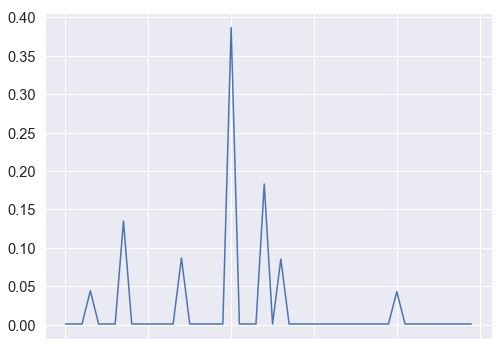

In [177]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source second due output javascript eventlistener first page   scene  m figuring web development n t lot knowledge hope could help out      concept page choose due clicking change second page      linked first page   store source chosen variable result        result          document getelementbyid      choice1       addeventlistener      click            elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice2       addeventlistener      click            elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        result       document getelementbyid      choice3       addeventlistener      click            elem  document getelementbyid      choice3        result   window getcomputedstyle   elem   null    getpropertyvalue      backg

[21, 45]

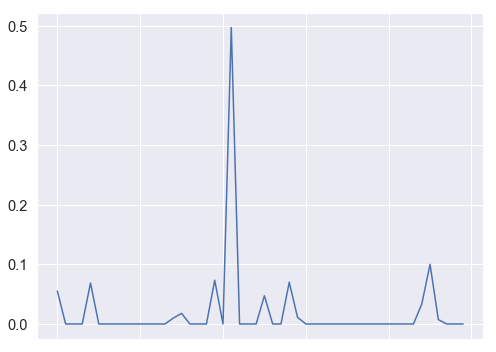

In [178]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
fabric wo n t let link firebase   firebase project  m trying link fabric      go fabric     firebase     integration select   says    already linked          go firebase console     project settings     integrations     fabric   n t see linked   see apps linked   one  m trying link right now      idea could happening   old firebase         fabric link   least see able remove    s nothing   fabric think already linked    s clearly    

Tags :  <firebase><google-fabric>

Index(['Topic_37', 'Topic_5', 'Topic_12', 'Topic_45', 'Topic_4'], dtype='object')
[37, 5, 12, 45, 4]
Topic 37 : implement bind set refer plot mode possibl place interfac yes
Topic 5 : compon this react angular locat const param export prop state
Topic 12 : item link menu action href grid nav temp toggl dropdown
Topic 45 : differ match output two comment anoth express current even ad
Topic 4 : system generat window applic net version microsoft project program framework


[37, 5, 12, 45, 4]

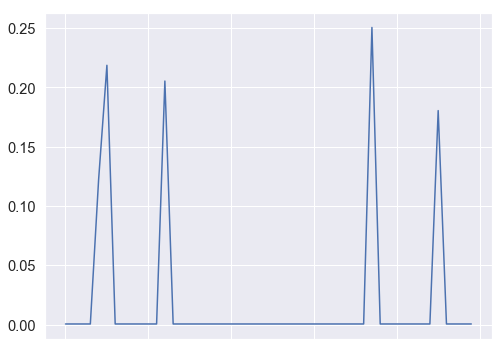

In [179]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Link Tags & Topics

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [182]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, 
                                  data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_tags_topics_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_tags_topics_1 = time.time()
print("timing total: {} s".format(t_tags_topics_1-t_tags_topics_0))


timing total: 201.60299706459045 s


In [183]:
df_topics_tags = df_topics_tags_raw.copy()

In [184]:
df_topics_tags.shape

(8765, 50)

In [185]:
df_topics_tags.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
.app,0.000513,0.000513,0.000513,0.000513,0.127949,0.000513,0.256578,0.000513,0.000513,0.000513,0.000513,0.000513,...,0.000513,0.000513,0.000513,0.000513,0.028941,0.126399,0.000513,0.184207,0.000513,0.000513,0.000513,0.000513
.htaccess,7.716764,0.393978,0.349434,1.727639,0.213272,0.079797,2.332526,2.537274,0.068585,0.178172,0.373027,0.562502,...,0.280921,0.105035,0.339281,0.117180,0.099388,0.542643,0.120392,1.536199,0.085437,0.270533,0.879846,0.056521
.lib,0.000189,0.000189,0.000189,0.000189,0.063971,0.027342,0.000189,0.000189,0.000189,0.000189,0.000189,0.000189,...,0.000189,0.000189,0.000189,0.000189,0.016752,0.000189,0.000189,0.000189,0.000189,0.000189,0.000189,0.040449
.net,1.717008,2.033194,1.190519,5.991421,17.072911,1.325764,15.413027,1.661244,0.318059,2.902198,0.290104,1.028116,...,1.391549,1.537736,1.197419,0.877826,2.304516,4.171756,3.588368,7.398278,0.582428,5.805526,1.717774,3.895626
.net-1.1,0.001111,0.001111,0.001111,0.001111,0.454990,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,...,0.001111,0.001111,0.001111,0.055604,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111


In [189]:
df_model_1_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
3,0.000833,0.000833,0.000833,0.044116,0.000833,0.000833,0.000833,0.134839,0.000833,0.000833,0.000833,0.000833,...,0.000833,0.000833,0.042941,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,0.010715,0.000172,0.000172,0.085942,0.457969,0.000172,0.000172,0.153159,0.000172,0.000172,0.000172,0.000172,...,0.000172,0.000172,0.000172,0.000172,0.024667,0.000172,0.000172,0.000172,0.000172,0.012626,0.000172,0.000172
9,0.028361,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.063893,0.000174,0.000174,0.000174,0.000174,...,0.777587,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174
10,0.200384,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,...,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857,0.002857
12,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.337870,0.001818,0.001818,0.001818,0.001818,...,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.092854,0.001818,0.001818,0.001818


##### Normalisation by Topics

In [192]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
.app,4.601377e-07,6.073851e-07,1.322070e-06,3.509194e-07,0.000076,3.998909e-07,6.838537e-05,4.917600e-07,1.512510e-06,5.884413e-07,8.404649e-07,6.942228e-07,...,5.162300e-07,6.457166e-07,8.826825e-07,1.070552e-06,0.000041,1.088382e-04,6.510034e-07,6.461088e-05,1.967843e-06,5.778755e-07,8.123180e-07,3.948936e-07
.htaccess,6.924009e-03,4.666285e-04,9.008548e-04,1.182211e-03,0.000127,6.222460e-05,6.216852e-04,2.433073e-03,2.022844e-04,2.044457e-04,6.113566e-04,7.614788e-04,...,2.827887e-04,1.322552e-04,5.839813e-04,2.446221e-04,0.000142,4.672523e-04,1.528321e-04,5.388232e-04,3.278469e-04,3.048523e-04,1.393693e-03,4.352365e-05
.lib,1.692960e-07,2.234719e-07,4.864221e-07,1.291118e-07,0.000038,2.132124e-05,5.028843e-08,1.809306e-07,5.564895e-07,2.165020e-07,3.092277e-07,2.554216e-07,...,1.899337e-07,2.375750e-07,3.247605e-07,3.938825e-07,0.000024,1.624655e-07,2.395201e-07,6.617941e-08,7.240177e-07,2.126146e-07,2.988717e-07,3.114772e-05
.net,1.540617e-03,2.408117e-03,3.069203e-03,4.099886e-03,0.010175,1.033813e-03,4.108014e-03,1.593020e-03,9.380820e-04,3.330158e-03,4.754535e-04,1.391796e-03,...,1.400800e-03,1.936237e-03,2.061034e-03,1.832530e-03,0.003296,3.592163e-03,4.555278e-03,2.594952e-03,2.234947e-03,6.541999e-03,2.720989e-03,2.999797e-03
.net-1.1,9.969651e-07,1.316001e-06,2.864486e-06,7.603253e-07,0.000271,8.664302e-07,2.961430e-07,1.065480e-06,3.277105e-06,1.274956e-06,1.821007e-06,1.504149e-06,...,1.118498e-06,1.399053e-06,1.912479e-06,1.160781e-04,0.000002,9.567415e-07,1.410507e-06,3.897232e-07,4.263660e-06,1.252064e-06,1.760022e-06,8.556027e-07


In [194]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(8765, 50)

#### Evaluation Topics Distrib method



##### Create list of list with Predicted Tags for each Text Questions list

In [286]:
       
t_train_0 = time.time() 
list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_train_1 = time.time()

t_pred_0 = time.time() 
list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_pred_1 = time.time() # time to predict test
print("timing total: {} s".format(t_pred_1-t_train_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 338.5889210700989 s

For Train:
 [['python', 'javascript', 'php', 'git', 'sql', 'mysql', 'java', 'c#', 'sql-server', 'html'], ['c#', 'python', 'php', 'java', 'javascript', 'android', 'mysql', 'sql', 'git', 'html'], ['javascript', 'html', 'jquery', 'php', 'css', 'python', 'c#', 'angular', 'java', 'ajax'], ['javascript', 'python', 'java', 'php', 'c#', 'android', 'angular', 'html', 'node.js', 'r'], ['php', 'sql', 'python', 'mysql', 'pandas', 'sql-server', 'javascript', 'c#', 'java', 'r'], ['python', 'javascript', 'php', 'java', 'node.js', 'c#', 'android', 'angular', 'mysql', 'html'], ['python', 'r', 'javascript', 'java', 'android', 'c#', 'php', 'python-3.x', 'sql', 'c++'], ['android', 'java', 'javascript', 'python', 'c#', 'php', 'angular', 'json', 'html', 'sql'], ['javascript', 'python', 'java', 'c#', 'php', 'html', 'jquery', 'android', 'angular', 'reactjs'], ['python', 'javascript', 'java', 'php', 'c#', 'android', 'html', 'c++', 'excel', 'vba']]

For Test:
 [['javascript', 

##### Encode predictions

For : 
    - Train predicted
    - Test predicted

In [296]:
# predicted
enc_lda_ypred_train = mlb_lda.transform(list_tags_predicted_train)
print("Train real shape:", enc_lda_ypred_train.shape)
enc_lda_ypred_test = mlb_lda.transform(list_tags_predicted_test)
print("Test real shape:", enc_lda_ypred_test.shape)

Train real shape: (16966, 8765)
Test real shape: (4242, 8765)
Train real shape: (16966, 8765)
Test real shape: (4242, 8765)


##### Evaluate different scorings

In [328]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_lda_ypred_train,
                          enc_lda_y_test, enc_lda_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 0 over 16966 rows [0.00%]
Nb. no Tags samples : 0 over 4242 rows [0.00%]


In [341]:
df_results = add_score(df_results, series_scores, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     no_top_words))
df_results

update line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
LDA_top50_tags10,0.0,0.0,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.0,0.0,0.0,0.0


##### Evaluate for each nb Tags max

In [ ]:
for nb_tags_max in [1, 2, 3, 4, 5, 6]:
    # select max tags
    list_tags_predicted_train_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_train]
    list_tags_predicted_test_curr = \
        [item[0:nb_tags_max] for item in list_tags_predicted_test]
    # predict
    enc_lda_ypred_train_curr = mlb_lda.transform(list_tags_predicted_train_curr)
    enc_lda_ypred_test_curr = mlb_lda.transform(list_tags_predicted_test_curr)
    # score
    series_scores_curr = evaluate_mdl_scorings(enc_lda_y_train, 
                          enc_lda_ypred_train_curr,
                          enc_lda_y_test, 
                          enc_lda_ypred_test_curr, 
                          t_lda_1 - t_lda_0 + t_tags_topics_1 + t_tags_topics_0, 
                          t_pred_1-t_pred_0)
    df_results = add_score(df_results, series_scores_curr, 
          "LDA_top{}_tags{}".format(gcv_lda_1.best_params_["n_components"],
                                     nb_tags_max))
df_results

### LDA Optim 2

#### Features

max_df=0.04, min_df=10

Train set used only

In [263]:
# init features
tf_vectorizer_2 = CountVectorizer(max_df=0.04, min_df=10, max_features=1000, 
                                tokenizer=myTokenizer)
tf_2 = tf_vectorizer_2.fit_transform(df_quest_cleaned[df_quest_cleaned.Train ==\
                                                 True]["token_text"])

# Define Search Param
search_params = {'n_components': [55, 60, 65], 
                 'learning_decay': [ .7]}# Init the Model
lda_for_gcv_2 = LatentDirichletAllocation(max_iter=5, learning_method='online', 
                                        learning_offset=50.,random_state=0,
                                       n_jobs=-1)# Init Grid Search Class
gcv_lda_2 = GridSearchCV(lda_for_gcv_2, param_grid=search_params)

# Do the Grid Search
gcv_lda_2.fit(tf_2)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [55, 60, 65], 'learning_decay': [0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [264]:
gcv_lda_2.best_params_

{'learning_decay': 0.7, 'n_components': 60}

In [265]:
# Best Model
best_lda_model_2 = gcv_lda_2.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_2.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_2.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_2.perplexity(tf_2))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 60}
Best Log Likelihood Score:  -1118541.0672432913
Model Perplexity:  351.4459298827758


In [266]:
df_res_2 = pd.DataFrame(data=gcv_lda_2.cv_results_)
df_res_2[df_res_2["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0,1,2
mean_fit_time,19.7157,18.7358,20.4582
std_fit_time,2.40745,1.90972,0.717182
mean_score_time,0.728038,0.702213,1.0499
std_score_time,0.0364867,0.00946077,0.239981
param_learning_decay,0.7,0.7,0.7
param_n_components,55,60,65
params,"{'learning_decay': 0.7, 'n_components': 55}","{'learning_decay': 0.7, 'n_components': 60}","{'learning_decay': 0.7, 'n_components': 65}"
split0_test_score,-1.16016e+06,-1.15327e+06,-1.15442e+06
split1_test_score,-1.10538e+06,-1.10892e+06,-1.10968e+06
split2_test_score,-1.09094e+06,-1.09342e+06,-1.09711e+06


Topics : 

In [267]:
# create & display topic dictionnary 

topic_dict_2 = display_topics(best_lda_model_2, 
                              tf_vectorizer_2.get_feature_names(), 
                              no_top_words)

Topic 0:
col tag btn django img submit ajax section phone bootstrap
Topic 1:
layout android intent parent tostr wrap fragment textview context toast
Topic 2:
springframework jar spring releas bean boot artifactid groupid annot scope
Topic 3:
product categori price modal oper mysqli real dialog trim id
Topic 4:
out println serial person side extract peopl arraylist todo ioexcept
Topic 5:
frame char integ printf fill mat structur camera edg ident
Topic 6:
amount quantiti registr sale histori convers payment invoic dont ticket
Topic 7:
android support firebas push notif transform io npm nativ jpg
Topic 8:
stream receiv async websit alert await queue azur wait bool
Topic 9:
level mode asp compani proxi runtim employe articl previous guid
Topic 10:
download sort chart tree channel axi curl choic relat selector
Topic 11:
templat func arg hello languag nil sender appear tableview swift
Topic 12:
condit assign confirm con bot rank associ footer elif troubl
Topic 13:
report non addit review dir

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [268]:
tf_2 = tf_vectorizer_2.transform(df_quest_cleaned["token_text"])

In [269]:
topics_pred_2 = best_lda_model_2.transform(tf)


In [270]:
topicNames_2 = []
for idx in range(0, gcv_lda_2.best_params_["n_components"]):
    topicNames_2.append("Topic_{}".format(idx))

df_topics_pred_2 = pd.DataFrame(data=topics_pred_2,
                                index=df_quest_cleaned.index,
                               columns=topicNames_2)
df_model_2 = df_quest_cleaned.join(
    df_topics_pred_2)

In [271]:
df_topics_pred_2.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
3,0.000694,0.000694,0.000694,0.000694,0.042361,0.042361,0.000694,0.226262,0.042361,0.000694,0.000694,0.000694,...,0.000694,0.000694,0.000694,0.096355,0.042361,0.042361,0.000694,0.000694,0.000694,0.000694,0.000694,0.084028
4,0.000141,0.064892,0.000141,0.000141,0.008616,0.000141,0.000141,0.000141,0.000141,0.042961,0.000141,0.008669,...,0.000141,0.084805,0.000141,0.000141,0.075068,0.017377,0.000141,0.065309,0.011095,0.000141,0.008843,0.008629
9,0.011102,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.082766,0.000170,0.053092,0.000170,0.030783,...,0.000170,0.000170,0.041008,0.000170,0.010765,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.085155
10,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,...,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.145238
12,0.101217,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.092424,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515


In [272]:
df_topics_pred_2.shape

(18768, 60)

In [273]:
df_quest_cleaned.shape

(18768, 36)

In [274]:
df_model_2.shape

(18768, 96)

In [275]:
df_model_2.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.000694,0.000694,0.000694,0.096355,0.042361,0.042361,0.000694,0.000694,0.000694,0.000694,0.000694,0.084028
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000141,0.084805,0.000141,0.000141,0.075068,0.017377,0.000141,0.065309,0.011095,0.000141,0.008843,0.008629
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.000170,0.000170,0.041008,0.000170,0.010765,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.085155
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.145238
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.001515,0.001515,0.001515,0.092424,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515


In [276]:
topic_dict_2

{0: 'col tag btn django img submit ajax section phone bootstrap',
 1: 'layout android intent parent tostr wrap fragment textview context toast',
 2: 'springframework jar spring releas bean boot artifactid groupid annot scope',
 3: 'product categori price modal oper mysqli real dialog trim id',
 4: 'out println serial person side extract peopl arraylist todo ioexcept',
 5: 'frame char integ printf fill mat structur camera edg ident',
 6: 'amount quantiti registr sale histori convers payment invoic dont ticket',
 7: 'android support firebas push notif transform io npm nativ jpg',
 8: 'stream receiv async websit alert await queue azur wait bool',
 9: 'level mode asp compani proxi runtim employe articl previous guid',
 10: 'download sort chart tree channel axi curl choic relat selector',
 11: 'templat func arg hello languag nil sender appear tableview swift',
 12: 'condit assign confirm con bot rank associ footer elif troubl',
 13: 'report non addit review direct github anyth virtual ask r

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_7', 'Topic_45'], dtype='object')
[7, 45]
Topic 7 : android support firebas push notif transform io npm nativ jpg
Topic 45 : train worker sampl job shape layer batch schedul weight conn


[7, 45]

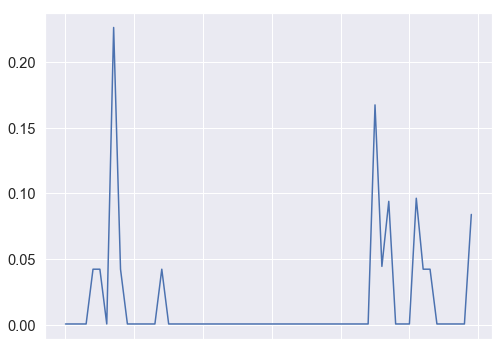

In [277]:
find_topics(0, df_topics_pred=df_topics_pred_2, topic_dict=topic_dict_2)

Cleaned question n°123:
sql partition columns listofcolumnnames   would number rows table according many times given row occured table   tried define table columns follows         select column name cl information schema columns table name    test        would run following query        select     row number       partition cols cl order   select     rn test       second query works nicely manually specify column names partition   otherwise fails   way   motivation behind table without   row duplicates rid   second query inspired answers     question   ms sql       sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa             aaaa                 sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa              

[40, 45, 0, 32]

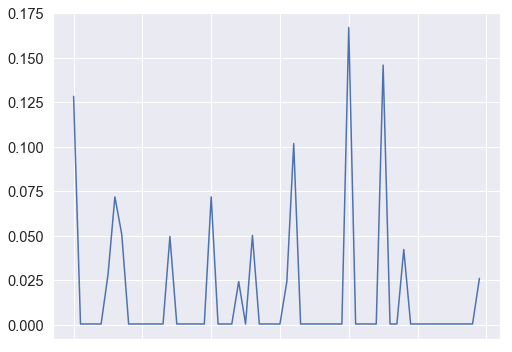

In [278]:
find_topics(123, df_topics_pred=df_topics_pred_2, topic_dict=topic_dict_2)

Cleaned question n°132:
google grpc powershell    m trying build simple grpc client powershell   find information   anybody pointers examples        ve tried loading grpc core dll   however throws         system reflection assembly      loadfile         grpc core dll      gac version location                             v4      users vagrant  nuget packages grpc core    lib netstandard1  grpc core dll       however   ca n t access methods                grpctest     reflection assembly      loadfile        grpc core dll        grpctest   get member  static    

Tags :  <powershell><grpc>

Index(['Topic_46', 'Topic_50', 'Topic_52'], dtype='object')
[46, 50, 52]
Topic 46 : core target master microsoft studio visual cpp x86 sys exe
Topic 50 : doc video rest abc develop author cooki meta publish separ
Topic 52 : charact encod dynam import contact yes dictionari decod utf consum


[46, 50, 52]

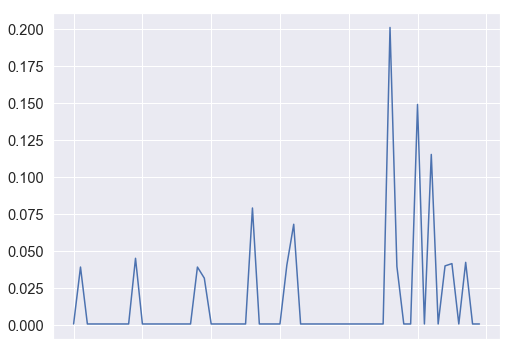

In [279]:
find_topics(132, df_topics_pred=df_topics_pred_2, topic_dict=topic_dict_2)

#### Predict tags

Extract unique train tags : Already done in first optimization

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [280]:
# init dataFrame
df_topics_tags_2 = pd.DataFrame(index=list_unique_tags, columns=topicNames_2, data=0)

df_model_2_topics = df_model_2[df_model_2["Train"] == True].filter(
    items=topicNames_2)

t_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_2_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_2[df_model_2["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_2.loc[tag_curr] += df_model_2_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))


timing total: 248.20429706573486 s


In [281]:
df_model_2[df_model_2["Train"] == True].shape

(15014, 96)

In [282]:
df_model_2.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.000694,0.000694,0.000694,0.096355,0.042361,0.042361,0.000694,0.000694,0.000694,0.000694,0.000694,0.084028
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000141,0.084805,0.000141,0.000141,0.075068,0.017377,0.000141,0.065309,0.011095,0.000141,0.008843,0.008629
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.000170,0.000170,0.041008,0.000170,0.010765,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.085155
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.145238
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.001515,0.001515,0.001515,0.092424,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515


In [283]:
df_model_2_topics.shape

(15014, 60)

In [284]:
df_model_2_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
3,0.000694,0.000694,0.000694,0.000694,0.042361,0.042361,0.000694,0.226262,0.042361,0.000694,0.000694,0.000694,...,0.000694,0.000694,0.000694,0.096355,0.042361,0.042361,0.000694,0.000694,0.000694,0.000694,0.000694,0.084028
4,0.000141,0.064892,0.000141,0.000141,0.008616,0.000141,0.000141,0.000141,0.000141,0.042961,0.000141,0.008669,...,0.000141,0.084805,0.000141,0.000141,0.075068,0.017377,0.000141,0.065309,0.011095,0.000141,0.008843,0.008629
9,0.011102,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.082766,0.000170,0.053092,0.000170,0.030783,...,0.000170,0.000170,0.041008,0.000170,0.010765,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.085155
12,0.101217,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.092424,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
13,0.000321,0.020780,0.077811,0.000321,0.000321,0.000321,0.000321,0.000321,0.000321,0.022036,0.000321,0.051071,...,0.040157,0.000321,0.000321,0.000321,0.023828,0.000321,0.000321,0.022427,0.000321,0.000321,0.000321,0.000321


In [285]:
df_topics_tags_2.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
.htaccess,0.938592,1.065163,0.286817,0.059124,0.274647,0.315856,0.106155,0.038274,0.274615,0.344096,0.572844,0.632492,...,1.147747,0.287664,0.345582,0.417427,0.546506,0.017458,0.429913,1.394502,0.190679,0.184568,0.310413,0.787838
.lib,0.000185,0.000185,0.033398,0.000185,0.000185,0.012111,0.000185,0.000185,0.361748,0.054605,0.000185,0.000185,...,0.011542,0.000185,0.000185,0.000185,0.000185,0.000185,0.084631,0.061037,0.000185,0.019337,0.000185,0.000185
.net,2.874317,6.553691,3.426816,0.243669,2.709945,3.815503,1.360014,1.638643,2.721558,3.397671,1.564199,1.049943,...,2.658563,2.583097,2.809530,2.280620,3.485674,0.639549,1.023664,8.376150,0.855091,2.445622,2.734933,2.153441
.net-1.1,0.000926,0.000926,0.000926,0.000926,0.072757,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,...,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.278704,0.000926,0.000926,0.000926,0.000926
.net-4.5,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,...,0.001190,0.001190,0.001190,0.001190,0.072619,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190


In [286]:
find_tags_from_topic(8, df_topics_tags=df_topics_tags_2)

['python',
 'c++',
 'javascript',
 'java',
 'c#',
 'android',
 'r',
 'php',
 'node.js',
 'ios']

In [287]:
# exemple : Topic 8 : url page link default icon www browser tab website chrome => .htaccess (5.17..)
topic_dict_2[8]

'stream receiv async websit alert await queue azur wait bool'

In [288]:
topic_dict_2[1]

'layout android intent parent tostr wrap fragment textview context toast'

In [289]:
find_tags_from_topic(1, df_topics_tags=df_topics_tags_2)

['python',
 'android',
 'java',
 'javascript',
 'c#',
 'php',
 'html',
 'ios',
 'swift',
 'node.js']

In [290]:
topic_dict_2[2]

'springframework jar spring releas bean boot artifactid groupid annot scope'

In [291]:
find_tags_from_topic(2, df_topics_tags=df_topics_tags_2)

['java',
 'android',
 'spring',
 'javascript',
 'spring-boot',
 'c#',
 'angular',
 'python',
 'html',
 'angularjs']

In [292]:
topic_dict_1[3]

'button click link page action url tab modal open browser'

In [293]:
find_tags_from_topic(3, df_topics_tags=df_topics_tags_2)

['java',
 'python',
 'javascript',
 'html',
 'css',
 'numpy',
 'android',
 'jquery',
 'c#',
 'python-3.x']

##### Find predicted Tags from questions : 
- Find Topics from Questions
- Find Tags from Topics

Example for question n° 0:


Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_7', 'Topic_45'], dtype='object')
[7, 45]
Topic 7 : android support firebas push notif transform io npm nativ jpg
Topic 45 : train worker sampl job shape layer batch schedul weight conn


['javascript',
 'java',
 'python',
 'php',
 'android',
 'c#',
 'sql',
 'mysql',
 'html',
 'jquery']

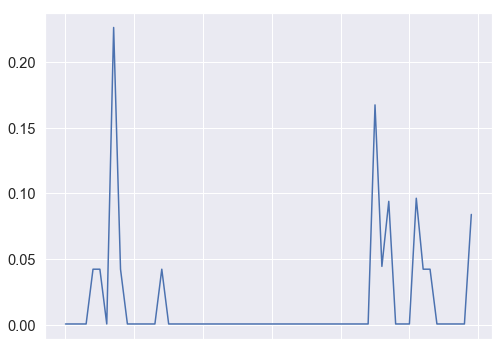

In [294]:
list_topic_id = find_topics(quest_iloc=0, freq_min=0.1, 
                            df_topics_pred=df_topics_pred_2,
                            topic_dict=topic_dict_2)

find_tags_from_topic(iloc_topic=list_topic_id[0], 
                     df_topics_tags=df_topics_tags_2)

Cleaned question n°1:
system dmv  s missing sql server  master dacpac ssdt    ola hallengren  s excellent maintenance solution scripts incorporated dba tools database project   maintained ssdt  target platform sql server    project includes references built in system databases master     msdb   project builds successfully      ola recently   updated   scripts include references sql server  dmv  s   incorporating updated scripts database project generated unresolved reference errors dmv  s         sql71502   procedure     dbo       databasebackup   unresolved reference object   sys       dm os host info   sql71502   procedure     dbo       databasebackup   unresolved reference object   sys       dm db log stats         although n t sql server  installed anywhere   tried updating target platform sql server  deleting recreating master database reference   i e   update master dacpac sql server  version     remove build errors       path referenced dacpac            program files   x86    m

['javascript',
 'java',
 'python',
 'c#',
 'android',
 'c++',
 'html',
 'php',
 'r',
 'eclipse']

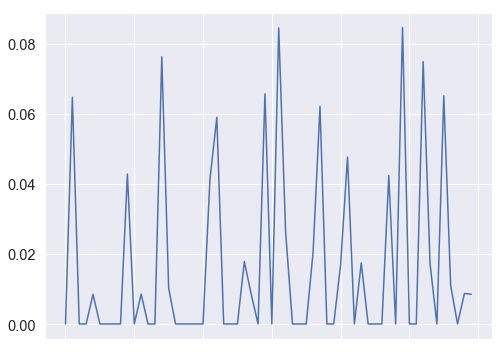

In [295]:
find_pred_tags_from_quest(quest_iloc=1, freq_min=0.08, 
                          df_topics_pred=df_topics_pred_2,
                          topic_dict=topic_dict_2,
                          df_topics_tags=df_topics_tags_2)


Cleaned question n°18:
display properties looping errors   spring bear       trying adjust display properties entity spring boot      form following inside display errors             ul         th   each     e         fields detailederrors          th   class         e global     globalerr   fielderr            span th   text         e global                e fieldname          field      span         span th   text         e message          message      span          li          ul           results following message upon invalid input         saving   please try lastname must empty   firstname size must    lastname size must    firstname must empty         tried adjusting property accommodate display avail           notempty   size   min     max        displayname      last      lastname                 display applicable field    

Tags :  <java><spring><spring-boot>

Index(['Topic_58', 'Topic_57'], dtype='object')
[58, 57]
Topic 58 : num str sum split random len matrix calcul cons

['python',
 'javascript',
 'java',
 'php',
 'node.js',
 'c#',
 'html',
 'r',
 'android',
 'css']

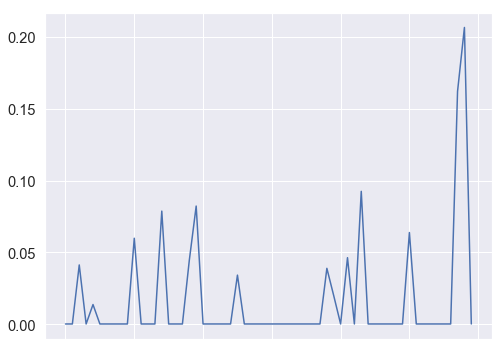

In [296]:
find_pred_tags_from_quest(quest_iloc=18, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_2,
                          topic_dict=topic_dict_2,
                          df_topics_tags=df_topics_tags_2)


Cleaned question n°123:
sql partition columns listofcolumnnames   would number rows table according many times given row occured table   tried define table columns follows         select column name cl information schema columns table name    test        would run following query        select     row number       partition cols cl order   select     rn test       second query works nicely manually specify column names partition   otherwise fails   way   motivation behind table without   row duplicates rid   second query inspired answers     question   ms sql       sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa             aaaa                 sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa              

['python',
 'javascript',
 'sql',
 'java',
 'php',
 'angular',
 'c#',
 'mysql',
 'html',
 'android']

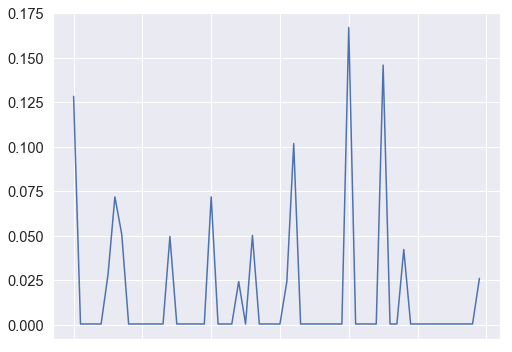

In [297]:
find_pred_tags_from_quest(quest_iloc=123, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_2,
                          topic_dict=topic_dict_2,
                          df_topics_tags=df_topics_tags_2)

##### Predict Tags from question Text :

- Text -> Features
- Features -> TF -> LDA.transfom -> topic ditrib

In [298]:
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_2,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text,token_text,Train
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,sql-server,NaN,NaN,True,True,True,False,False,True,How to insert an entry to a table only if it d...,insert entry table exist table looks sql ser...,True
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,NaN,NaN,NaN,True,False,False,False,False,True,System DMV's missing from SQL Server 2017 mast...,system dmv s missing sql server master dacpa...,True
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,ajax,NaN,NaN,True,True,True,False,False,True,how to insert data in databse without page rel...,insert databse without page reload insert ...,True
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,file-upload,multipart,NaN,True,True,False,False,False,True,How to upload image using multipart in Amazon ...,upload multipart amazon s3 upload amazon s3 ...,False
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,crosstab,NaN,NaN,True,False,False,False,False,True,DB2 SQL CROSSTAB <p>I would like to output a t...,db2 sql crosstab would output table transf...,True


In [299]:
# example 1st question
text_test = df_quest_cleaned.iloc[0]["Text"]
print(text_test)
# clean the text
text_cleaned = cleaning_text(text_test)

# calculate feature from text
feat_curr =  tf_vectorizer_2.transform([text_cleaned])

# calculate topic distrib
topic_distrib_pred = best_lda_model_2.transform(feat_curr)

# find best topic
find_tags_from_topic(topic_distrib_pred.argmax(), 
                     df_topics_tags=df_topics_tags_2, 
                     no_max=10)

How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>

<pre><code>wordId     word      
----------------
1214       pen           
1215       men    
1216       cat  
</code></pre>

<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>



['python',
 'javascript',
 'java',
 'c#',
 'html',
 'python-3.x',
 'android',
 'php',
 'swift',
 'jquery']

In [300]:
# example  question
text_test = df_quest_cleaned.iloc[1]["Text"]
print(text_test)
 
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_2,
                    lda_model = best_lda_model_2,
                    df_topics_tags=df_topics_tags_2,
                    no_max=10)

System DMV's missing from SQL Server 2017 master.dacpac in SSDT 2015 <p>I have Ola Hallengren's excellent Maintenance Solution scripts incorporated in to a DBA tools database project.  This is maintained using SSDT 2015 with a target platform of SQL Server 2012.  The project includes references to the built-in system databases master &amp; msdb.  The project builds successfully.</p>

<p>Ola has recently <a href="https://ola.hallengren.com/versions.html" rel="nofollow noreferrer">updated</a> his scripts and they now include references to new SQL Server 2017 DMV's, so incorporating the updated scripts into my database project generated unresolved reference errors for the new DMV's.  </p>

<pre><code>SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_os_host_info]
SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_db_log_stats]
</code></pre>

<p>Although I don't have SQL Server 2017 installed anywhere, I tri

['android',
 'javascript',
 'python',
 'java',
 'c#',
 'ios',
 'php',
 'swift',
 'html',
 'c++']

In [301]:
# example  question
text_test = df_quest_cleaned.iloc[18]["Text"]
print(text_test)

# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_2,
                    lda_model = best_lda_model_2,
                    df_topics_tags=df_topics_tags_2,
                    no_max=10)

Display name of properties when looping through errors <p>I am new to Spring so bear with me!</p>

<p>I am trying to adjust the display name of properties of an entity in Spring boot.</p>

<p>I have a form with the following inside to display all errors:</p>

<pre><code>&lt;ul&gt;
    &lt;li th:each="e : ${#fields.detailedErrors()}" th:class="${e.global}? globalerr : fielderr"&gt;
        &lt;span th:text="${e.global}? '*' : ${e.fieldName}"&gt;The field name&lt;/span&gt;
        &lt;span th:text="${e.message}"&gt;The error message&lt;/span&gt;
    &lt;/li&gt;
&lt;/ul&gt;
</code></pre>

<p>That results in the following message upon invalid input:</p>

<blockquote>
  <p>Error Saving New User - Please Try Again
  lastName must not be empty <br>
  firstName size must be between 1 and 30<br>
  lastName size must be between 1 and 30<br>
  firstName must not be empty<br></p>
</blockquote>

<p>I have tried adjusting the property to accommodate a display name to no avail:</p>

<pre><code>@NotEm

['javascript',
 'python',
 'java',
 'c#',
 'html',
 'php',
 'android',
 'angular',
 'regex',
 'css']

In [308]:
# example  question
text_test = df_quest_cleaned.iloc[123]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[123]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_2,
                    lda_model = best_lda_model_2,
                    df_topics_tags=df_topics_tags_2,
                    no_max=10)


SQL Partition by columns IN listOfColumnNames <p>I would like to number all rows of my table according to how many times a given row has occured in the table. I tried to define a table of my columns as follows:</p>

<pre><code>select COLUMN_NAME as cl from information_schema.columns where table_name = 'TEST'
</code></pre>

<p>Then I would like to run the following query.</p>

<pre><code>SELECT *,
ROW_NUMBER() OVER(PARTITION BY Cols IN cl ORDER BY (SELECT 0)) AS rn
FROM TEST 
</code></pre>

<p>The second query works nicely if I manually specify the column names for partition. But otherwise it fails. Is there a way of doing this? 
The motivation behind all this is that I have a table without an ID, where there can be row duplicates which I want to get rid of. 
The second query is inspired by answers to <a href="https://stackoverflow.com/questions/18932/how-can-i-remove-duplicate-rows">this</a> question.
I use MS SQL 2008.</p>

<p>Sample data before:</p>

<pre><code>| Column1 | Column2 | 

['javascript',
 'python',
 'java',
 'angular',
 'reactjs',
 'android',
 'c#',
 'php',
 'node.js',
 'html']

#### Evaluation
Method : Check if real Tags are into the 5 or 10 first predicted Tags

In [365]:
nb_tags_eval_max = 10

t_0 = time.time()

df_model_2["score_lda_2"] = 0

list_scores = []
for idx in range(0, df_model_2.shape[0]):
    
    # predicted tags
    text_test = df_model_2.iloc[idx]["Text"]
    tags_pred = find_tags_from_text(text=text_test, 
                                    tf_vectorizer=tf_vectorizer_2,
                                    lda_model = best_lda_model_2, 
                                    df_topics_tags=df_topics_tags_2,
                                    no_max=nb_tags_eval_max)
    
    tags_real = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_2.iloc[idx]["Tags"])
    #print("")
    #print(tags_pred)
    #print(tags_real)
    #print(score_eval_tags(tags_real,tags_pred))
    list_scores.append(score_eval_tags(tags_real, tags_pred))

t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

df_model_2["score_lda_2"] = list_scores  

timing total: 350.26113986968994 s


In [366]:
df_model_2["score_lda_2"].value_counts()

0.000000    8098
0.333333    2771
0.500000    2706
0.250000    1912
0.200000    1369
1.000000     982
0.666667     427
0.400000     344
0.600000      84
0.750000      70
0.800000       5
Name: score_lda_2, dtype: int64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


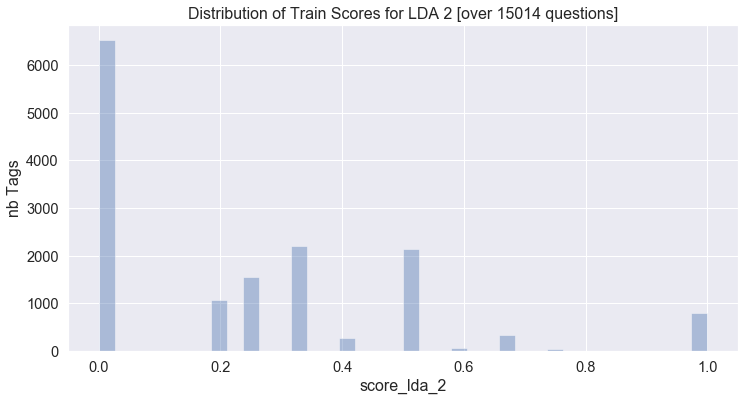

In [367]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Train Scores for LDA 2 [over {} questions]".format(
    df_model_2[df_model_2.Train == True].shape[0]))
ax = sns.distplot(df_model_2[df_model_2.Train == True]["score_lda_2"], 
                  kde=False)
ax.set_ylabel('nb Tags');

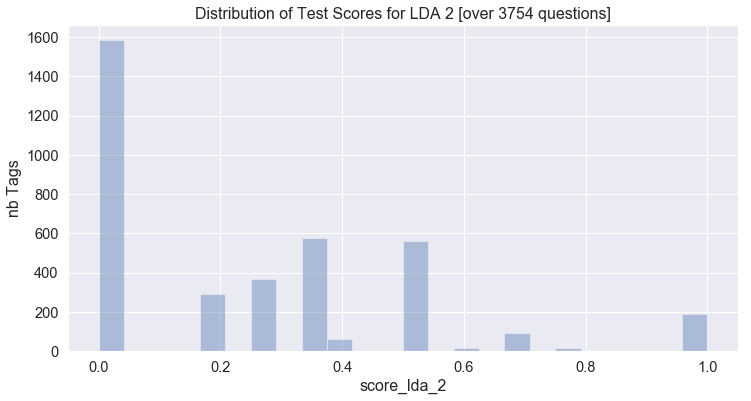

In [368]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Test Scores for LDA 2 [over {} questions]".format(
    df_model_2[df_model_2.Train == False].shape[0]))
ax = sns.distplot(df_model_2[df_model_1.Train == False]["score_lda_2"], 
                  kde=False)
ax.set_ylabel('nb Tags');

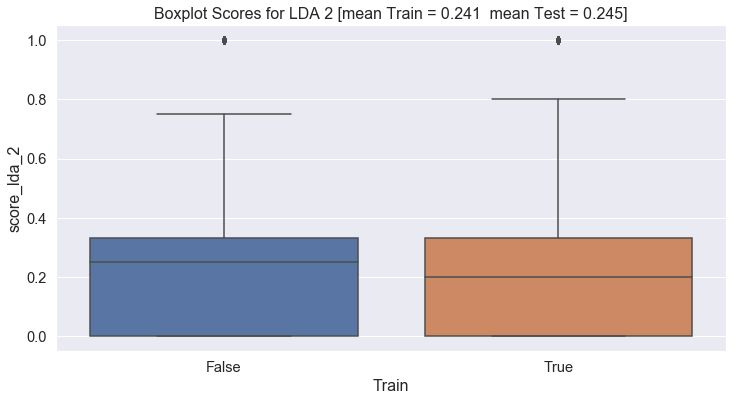

In [369]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot Scores for LDA 2 [mean Train = {:.3f}  mean Test = {:.3f}]".\
          format(df_model_2[df_model_2.Train == True]["score_lda_2"].mean(),
                df_model_2[df_model_2.Train == False]["score_lda_2"].mean()))
ax = sns.boxplot(y="score_lda_2", x='Train', data=df_model_2)


##### At least one Tag ok

In [370]:
df_model_2["score_OK_lda_2"] = df_model_2["score_lda_2"] > 0

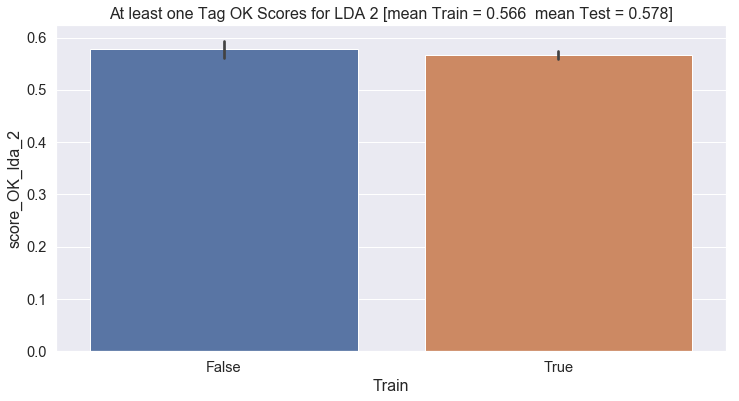

In [371]:
fig = plt.figure(figsize=(12, 6))
plt.title("At least one Tag OK Scores for LDA 2 [mean Train = {:.3f}  mean Test = {:.3f}]".\
          format(df_model_2[df_model_2.Train == True]["score_OK_lda_2"].mean(),
                df_model_2[df_model_2.Train == False]["score_OK_lda_2"].mean()))
ax = sns.barplot(y="score_OK_lda_2", x='Train', data=df_model_2)
#ax = sns.barplot(x="day", y="total_bill", data=tips)

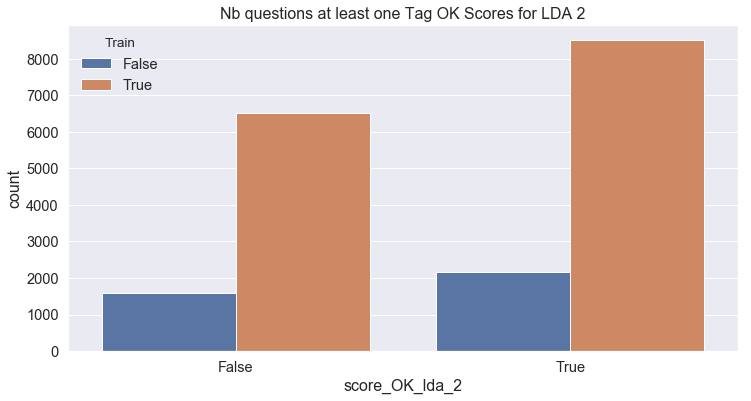

In [372]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb questions at least one Tag OK Scores for LDA 2")
ax = sns.countplot(x="score_OK_lda_2", hue="Train", data=df_model_2)

## Models Supervised

### Extract n-th first tags from data

In [342]:
df_mdl_sup_1 = df_quest_cleaned.copy()
df_mdl_sup_1["Tag_0"] = df_mdl_sup_1.Tags.apply(apply_extract_tag)
df_mdl_sup_1["Tag_1"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(1,))
df_mdl_sup_1["Tag_2"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(2,))
df_mdl_sup_1["Tag_3"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(3,))
df_mdl_sup_1["Tag_4"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(4,))

df_mdl_sup_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged_160,flag_most_Tagged_100,flag_most_Tagged_76,flag_most_Tagged_40,Text,token_text,Train
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,True,True,True,False,False,True,True,True,True,How to insert an entry to a table only if it d...,insert entry table exist table looks sql ser...,True
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,True,False,False,False,False,True,True,True,True,System DMV's missing from SQL Server 2017 mast...,system dmv s missing sql server master dacpa...,True
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,True,True,True,False,False,True,True,True,True,how to insert data in databse without page rel...,insert databse without page reload insert ...,True
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,True,True,False,False,False,True,True,True,True,How to upload image using multipart in Amazon ...,upload multipart amazon s3 upload amazon s3 ...,True
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,True,False,False,False,False,True,True,True,True,DB2 SQL CROSSTAB <p>I would like to output a t...,db2 sql crosstab would output table transf...,True


### Extracting features from text files

#### Clean text

already done

#### Tokenizing text with scikit-learn

already done

#### TF occurrences

In [343]:
# init features
tf_vectorizer_sup_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000,
                                      tokenizer=myTokenizer)

# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[\
                                   df_quest_cleaned.Train\
                                   == True]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(16966, 1000)

In [344]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[df_mdl_sup_1.Train == False]["token_text"])
X_test_counts_sup_1.shape

(4242, 1000)

#### From occurrences to frequencies

In [345]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [346]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(16966, 1000)

In [347]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(4242, 1000)

In [348]:
print("Nb unique tags in Train: ", df_mdl_sup_1[df_mdl_sup_1.Train == True].\
      Tag_0.nunique())

Nb unique tags in Train:  1236


In [349]:
print("Nb unique tags in Test: ", df_mdl_sup_1[df_mdl_sup_1.Train == False].\
      Tag_0.nunique())

Nb unique tags in Test:  557


### Dummy classifier 1st Tag

In [322]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=0)
clf_dummy.fit(X_train_tfidf_sup_1, 
              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)
print("Train Score : ",
      clf_dummy.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_dummy.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.0562874251497006
Test Score :  0.060016906170752324


In [323]:
predicted_train = clf_dummy.predict(X_train_tfidf_sup_1)
predicted_test  = clf_dummy.predict(X_test_tfidf_sup_1)

In [324]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_dummy_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_dummy_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_dummy_1"]).head()

,token_text,Tags,Tag_0_dummy_1
3,insert entry table exist table looks sql ser...,<c#><sql><sql-server>,ios
4,system dmv s missing sql server master dacpa...,<sql-server><sql-server-data-tools>,javascript
9,insert databse without page reload insert ...,<javascript><php><ajax>,ios
10,upload multipart amazon s3 upload amazon s3 ...,<android><amazon-s3><file-upload><multipart>,javascript
12,db2 sql crosstab would output table transf...,<sql><db2><crosstab>,python


### MultinomialNB classifier 1st Tag

In [325]:
clf_mnb_1 = MultinomialNB().fit(X_train_tfidf_sup_1, 
                              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)

In [326]:
print("Train Score : ",
      clf_mnb_1.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_mnb_1.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.5150405072208524
Test Score :  0.46689208227669765


In [327]:
predicted_train = clf_mnb_1.predict(X_train_tfidf_sup_1)
predicted_test  = clf_mnb_1.predict(X_test_tfidf_sup_1)

In [328]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_mnb_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_mnb_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_mnb_1"]).head()

,token_text,Tags,Tag_0_mnb_1
3,insert entry table exist table looks sql ser...,<c#><sql><sql-server>,sql
4,system dmv s missing sql server master dacpa...,<sql-server><sql-server-data-tools>,c#
9,insert databse without page reload insert ...,<javascript><php><ajax>,javascript
10,upload multipart amazon s3 upload amazon s3 ...,<android><amazon-s3><file-upload><multipart>,javascript
12,db2 sql crosstab would output table transf...,<sql><db2><crosstab>,sql


### SGDClassifier 

#### 1st Tag : Tag_0

In [690]:
print("For Tag_0:")
print('- Nb Tags in Test but not in Train :',
      len(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["Tag_0"].\
                 unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_0"].unique())))))

For Tag_0:
- Nb Tags in Test but not in Train : 19


In [597]:
# list of tags in Test set but not in Train set :
list_tags_test_no_train = set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] \
        == False]["Tag_0"].unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_0"].unique())))
# creation of dataframe with these special tags
df_count = pd.DataFrame(data=list(list_tags_test_no_train), columns=["Tag_0"])
# add columns of count of every special tags into Test:
df_count["nb_tags"] = 0
def apply_fun_nb(tag_curr):
    return df_mdl_sup_1[(df_mdl_sup_1["Train"] == False) & \
                 (df_mdl_sup_1["Tag_0"] == tag_curr)].shape[0]
df_count["nb_tags"] = df_count["Tag_0"].apply(apply_fun_nb)
df_count

,Tag_0,nb_tags
0,jsp,1
1,intellij-idea,1
2,generics,1
3,twitter-bootstrap-3,1
4,asynchronous,1
5,pagination,1
6,iphone,1


Text(0, 0.5, 'nb Tags 1 [-]')

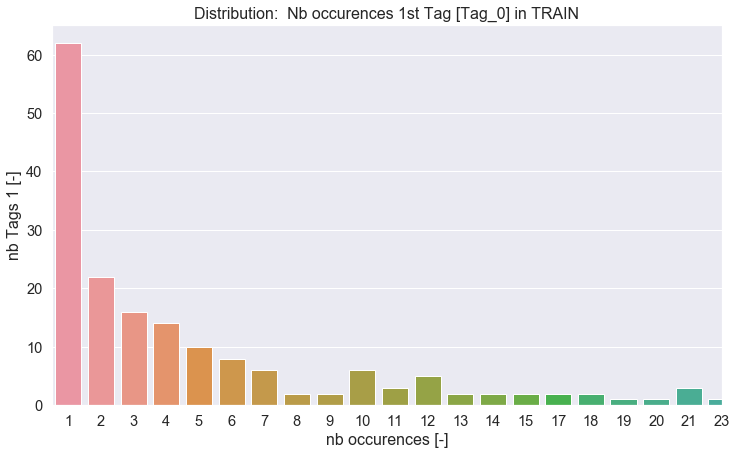

In [725]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TRAIN")
ax = sns.countplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]
                  ["Tag_0"].value_counts())
ax.set_xlim(right=20)
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

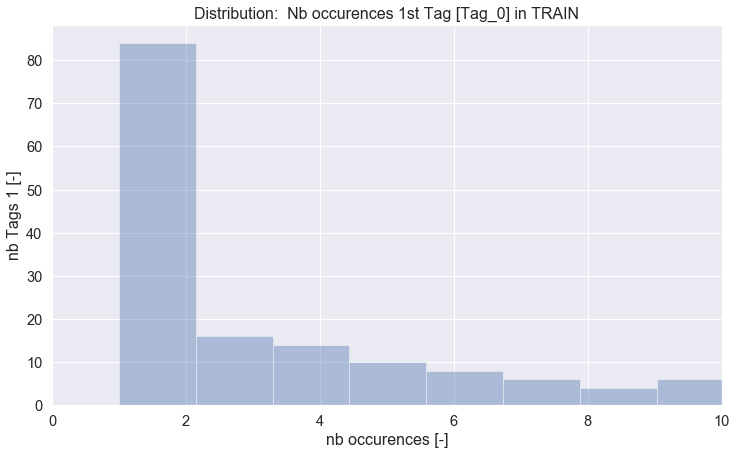

In [715]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TRAIN")
ax = sns.distplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]
                  ["Tag_0"].value_counts(), bins=400, kde=False)
ax.set_xlim([0, 10])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0.5, 0, 'count of 1st Tag  [-]')

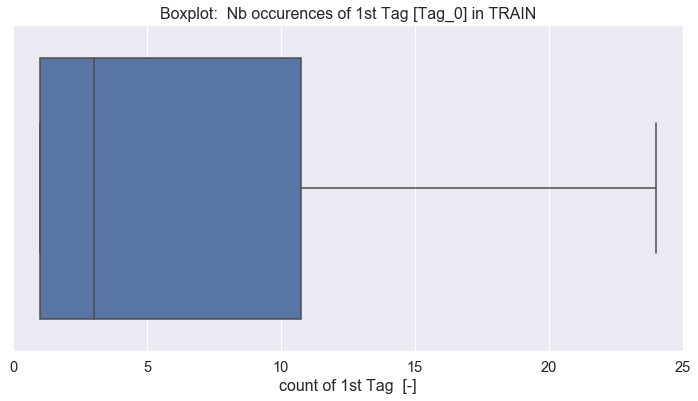

In [701]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 1st Tag [Tag_0] in TRAIN")
ax = sns.boxplot(df_mdl_sup_1[df_mdl_sup_1["Train"]
                              == False]["Tag_0"].value_counts())
ax.set_xlim([0, 25])
ax.set_xlabel("count of 1st Tag  [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

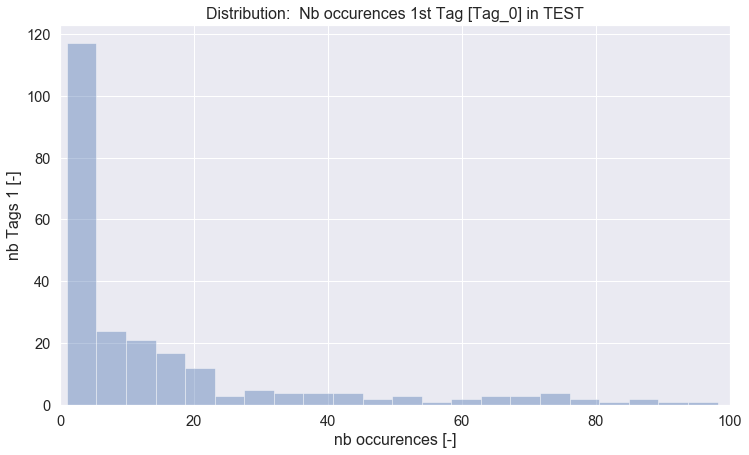

In [704]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TEST")
ax = sns.distplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]
                  ["Tag_0"].value_counts(), bins=400, kde=False)
ax.set_xlim([0, 100])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0.5, 0, 'count of 1st Tag  [-]')

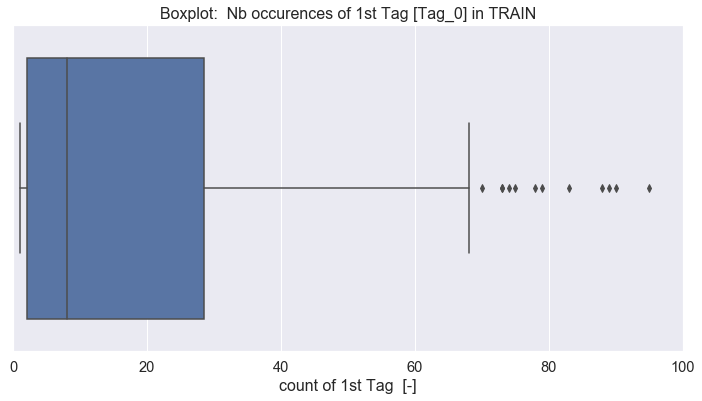

In [707]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 1st Tag [Tag_0] in TRAIN")
ax = sns.boxplot(df_mdl_sup_1[df_mdl_sup_1["Train"]
                              == True]["Tag_0"].value_counts())
ax.set_xlim([0, 100])
ax.set_xlabel("count of 1st Tag  [-]")

In [616]:
df_mdl_sup_1.Tag_0.nunique()

279

In [518]:
clf_sgc_1 = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=0,
                        max_iter=5, tol=None)

clf_sgc_1.fit(X_train_tfidf_sup_1, 
              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [519]:
print("Train Score : ",
      clf_sgc_1.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_sgc_1.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.6654455794293765
Test Score :  0.5359256128486898


In [520]:
predicted_train = clf_sgc_1.predict(X_train_tfidf_sup_1) 
predicted_test = clf_sgc_1.predict(X_test_tfidf_sup_1)

In [521]:
find_nb_no_uniquetag(predicted_train)
find_nb_no_uniquetag(predicted_test)

Nb. no Tags samples : 0 over 14195 rows [0.00%]
Nb. no Tags samples : 0 over 3549 rows [0.00%]


0

In [522]:
precision_score(df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0, predicted_train, average='micro')

0.6654455794293765

In [526]:
recall_score(df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0, predicted_train,
                average='micro')

0.6654455794293765

In [523]:
precision_score(df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0, predicted_test, average='micro')

0.5359256128486898

In [514]:
predicted_train

array(['sql', 'sql-server', 'javascript', ..., 'javascript', 'python',
       'vb.net'], dtype='<U21')

In [517]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_sgc_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_sgc_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_sgc_1"]).head()

,token_text,Tags,Tag_0_sgc_1
3,insert entry table exist table looks sql ser...,<c#><sql><sql-server>,sql
4,system dmv s missing sql server master dacpa...,<sql-server><sql-server-data-tools>,sql-server
9,insert databse without page reload insert ...,<javascript><php><ajax>,javascript
10,upload multipart amazon s3 upload amazon s3 ...,<android><amazon-s3><file-upload><multipart>,ios
12,db2 sql crosstab would output table transf...,<sql><db2><crosstab>,sql


In [518]:
df_mdl_sup_1[df_mdl_sup_1["Tag_0_sgc_1"].isna()]

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text,token_text,Train,Tag_0_dummy_1,Tag_0_sgc_1


#### 2nd Tag : Tag_1

In [687]:
print("For Tag_1:")
print('- Nb Tags in Test but not in Train :',
      len(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["Tag_1"].\
                 unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_1"].unique())))))

For Tag_1:
- Nb Tags in Test but not in Train : 309


##### 2nd Tag  : Train part

In [657]:
df_train = df_mdl_sup_1[df_mdl_sup_1.Train == True].filter(items=["Tag_1"])
df_train = df_train.reset_index()
print(df_train.shape)
df_train.head()

(15014, 2)


,index,Tag_1
0,3,sql
1,4,sql-server-data-tools
2,9,php
3,12,db2
4,13,laravel


In [658]:
df_train = df_train[df_train["Tag_1"].notna()]
df_train.head() 

,index,Tag_1
0,3,sql
1,4,sql-server-data-tools
2,9,php
3,12,db2
4,13,laravel


In [659]:
df_train.shape

(13644, 2)

In [660]:
list_idx_xtrain = df_train.index.tolist()
print(list_idx_xtrain[:10])
print("...")
print(list_idx_xtrain[-10:])

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
...
[15002, 15003, 15004, 15005, 15007, 15009, 15010, 15011, 15012, 15013]


In [661]:
X_train_tfidf_sup_1.shape

(15014, 1000)

In [662]:
len(list_idx_xtrain)

13644

In [671]:
X_train_tfidf_sup_tag_1 = X_train_tfidf_sup_1[list_idx_xtrain,:]
X_train_tfidf_sup_tag_1.shape

(13644, 1000)

##### 2nd Tag:  Test part

In [664]:
df_test = df_mdl_sup_1[df_mdl_sup_1.Train == False].filter(items=["Tag_1"])
df_test = df_test.reset_index()
print(df_test.shape)
df_test.head()

(3754, 2)


,index,Tag_1
0,10,amazon-s3
1,21,objective-c
2,31,swift
3,54,qt
4,75,wordpress


In [665]:
df_test = df_test[df_test["Tag_1"].notna()]
df_test.head() 

,index,Tag_1
0,10,amazon-s3
1,21,objective-c
2,31,swift
3,54,qt
4,75,wordpress


In [666]:
df_test.shape

(3417, 2)

In [667]:
list_idx_xtest = df_test.index.tolist()
print(list_idx_xtest[:10])
print("...")
print(list_idx_xtest[-10:])

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
...
[3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753]


In [668]:
X_test_tfidf_sup_1.shape

(3754, 1000)

In [669]:
len(list_idx_xtest)

3417

In [670]:
X_test_tfidf_sup_tag_1 = X_test_tfidf_sup_1[list_idx_xtest,:]
X_test_tfidf_sup_tag_1.shape

(3417, 1000)

##### Fitting

In [674]:
clf_sgc_2 = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=0,
                        max_iter=5, tol=None)

clf_sgc_2.fit(X_train_tfidf_sup_tag_1, df_train["Tag_1"])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

##### Scores

In [675]:
print("Train Score : ",
      clf_sgc_2.score(X_train_tfidf_sup_tag_1, df_train["Tag_1"]))
print("Test Score : ",
      clf_sgc_2.score(X_test_tfidf_sup_tag_1, df_test["Tag_1"]))

Train Score :  0.8054089709762533
Test Score :  0.2221246707638279


In [676]:
df_train["Tag_1"].nunique()

2437

In [677]:
df_train.shape

(13644, 2)

Text(0.5, 0, 'count of 2nd Tag  [-]')

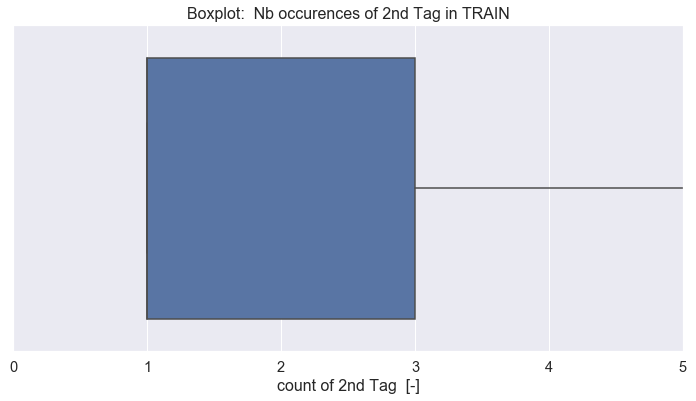

In [688]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 2nd Tag in TRAIN")
ax = sns.boxplot(df_train["Tag_1"].value_counts())
ax.set_xlim([0,5])
ax.set_xlabel("count of 2nd Tag  [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

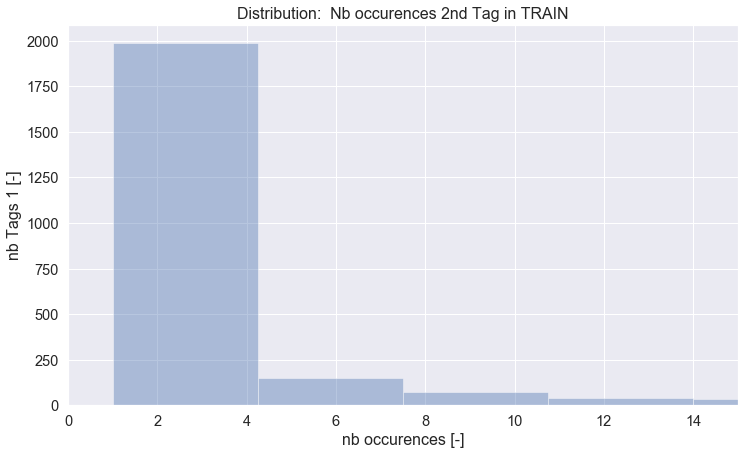

In [689]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 2nd Tag in TRAIN")
ax = sns.distplot(df_train["Tag_1"].value_counts(), bins=100, kde=False)
ax.set_xlim([0,15])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

###  RandomForest Multi-Tags : 51 Most Used Tags

#### Splits for Optim

In [424]:
# Split parameters
random_state = 0
n_splits = 3
test_size=0.2

# preparation des splits : choix de splits aléatoires de meme taille
cv = model_selection.ShuffleSplit(n_splits=n_splits, test_size=test_size, 
                                  random_state=random_state)

In [777]:
df_most

,nb_min_used,nb_most_used_tags,pc_of_unique_tags,pc_of_quest
0,160,51,0.581860,76.914372
1,100,73,0.832858,80.879857
2,76,100,1.140901,83.666541
3,40,201,2.293212,88.494908


#### Choose Most Used Tags

In [788]:
idx_most = 0

In [789]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_160


51

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [378]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs'], ['android']]

For test set...
[['ios'], ['ios', 'swift'], ['c++'], ['excel', 'vba', 'excel-vba'], ['android'], ['sql-server'], ['c#', 'asp.net'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [379]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [380]:
encoded_y_train.shape

(13024, 51)

In [381]:
encoded_y_test.shape

(3288, 51)

In [382]:
encoded_y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##### Check if enough sample for each most used Tags (important for Training) :

In [383]:
#for idx in range(0, encoded_y_train.shape[1]):
print('For less used tag:')
print("- For train: ")
nb_used_tags_train = np.sum(encoded_y_train, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_train))
print("\n- For test : ")
nb_used_tags_test = np.sum(encoded_y_test, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_test))

For less used tag:
- For train: 
  - Number of use:  122

- For test : 
  - Number of use:  31


In [384]:
# for idx in range(0, encoded_y_train.shape[1]):
print('For each sample:')
print("- For train: ")
nb_tags_per_sample_train = np.sum(encoded_y_train, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_train))
print("\n- For test : ")
nb_tags_per_sample_test = np.sum(encoded_y_test, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_test))

For each sample:
- For train: 
  - Minimum Number of Tags:  1

- For test : 
  - Minimum Number of Tags:  1


In [385]:
find_nb_no_tags(encoded_y_train)
find_nb_no_tags(encoded_y_test)

Nb. no Tags samples : 0 over 13024 rows [0.00%]
Nb. no Tags samples : 0 over 3288 rows [0.00%]


0

In [386]:
df_mdl_sup_1[df_mdl_sup_1.Train == False].iloc[8]["Tags"]

'<python><django>'

In [387]:
mlb.classes_

array(['.net', 'ajax', 'amazon-web-services', 'android', 'angular',
       'angularjs', 'apache-spark', 'arrays', 'asp.net', 'c', 'c#', 'c++',
       'css', 'database', 'django', 'docker', 'excel', 'excel-vba',
       'firebase', 'html', 'ios', 'java', 'javascript', 'jquery', 'json',
       'laravel', 'linux', 'mongodb', 'mysql', 'node.js', 'oracle',
       'pandas', 'php', 'postgresql', 'python', 'python-3.x', 'r',
       'react-native', 'reactjs', 'regex', 'ruby-on-rails', 'spring',
       'spring-boot', 'sql', 'sql-server', 'swift', 'tensorflow',
       'typescript', 'vba', 'wordpress', 'xml'], dtype=object)

#### Distribution of Tags

(0, 1000)

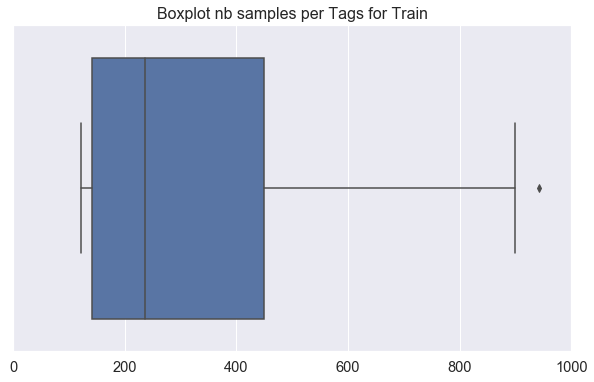

In [392]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb samples per Tags for Train")
ax = sns.boxplot(encoded_y_train.sum(axis=0))
ax.set_xlim([0,1000])

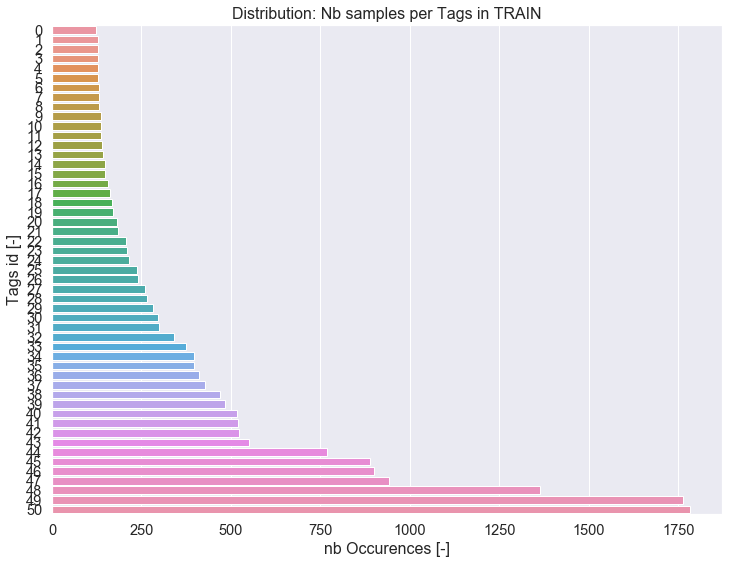

In [395]:
fig = plt.figure(figsize=(12, 9))
plt.title("Distribution: Nb samples per Tags in TRAIN")
df_count = pd.DataFrame(data=encoded_y_train.sum(axis=0), columns=['nb_samples'])
ax = sns.barplot(y=df_count.index, x=sorted(df_count["nb_samples"]), orient='h')
#ax.set_xlim(right=90)
#ax.set_ylim([0, 20])
ax.set_xlabel("nb Occurences [-]")
ax.set_ylabel("Tags id [-]");

In [790]:
df_count[df_count["nb_samples"] < df_most.iloc[idx_most]["nb_min_used"]]

,nb_samples
0,143
1,149
2,131
5,130
6,128
8,156
13,131
15,130
17,140
26,132


Text(0, 0.5, 'nb [-]')

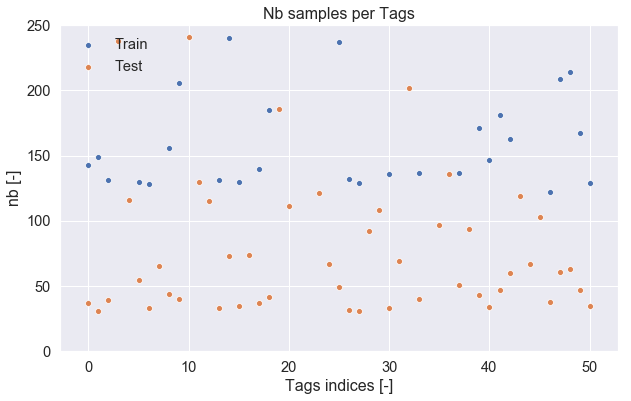

In [402]:
fig = plt.figure(figsize=(10, 6))
plt.title("Nb samples per Tags")
ax = sns.scatterplot(data=encoded_y_train.sum(axis=0), label='Train')
ax1 = sns.scatterplot(data=encoded_y_test.sum(axis=0), label='Test')
#ax1.set_xlim([0,250])
ax.set_xlabel('Tags indices [-]')
ax1.set_ylim([0,250])
ax.set_ylabel('nb [-]')

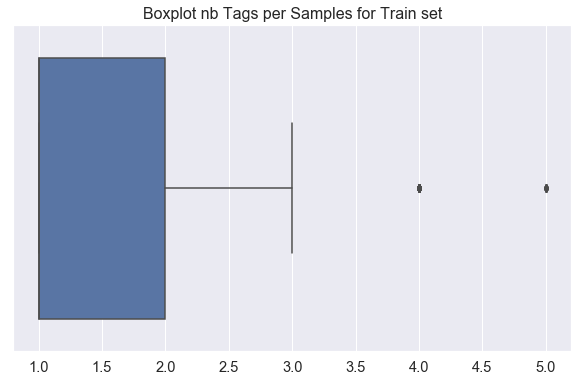

In [403]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Train set")
ax = sns.boxplot(encoded_y_train.sum(axis=1))
#ax.set_xlim([0,250])

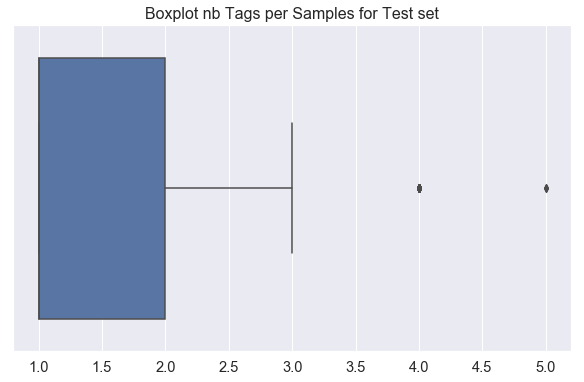

In [404]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Test set")
ax = sns.boxplot(encoded_y_test.sum(axis=1))

#### Features preparation

In [407]:
# init features
tf_vectorizer_sup_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000,
                                      tokenizer=myTokenizer)
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(13024, 1000)

In [408]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_test_counts_sup_1.shape

(3288, 1000)

In [409]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [410]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(13024, 1000)

In [411]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3288, 1000)

#### Fit

In [414]:
X_train_tfidf_sup_1.shape

(13024, 1000)

In [415]:
encoded_y_train.shape

(13024, 51)

In [416]:
encoded_y_train[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0

In [417]:
encoded_y_test[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [418]:
for idx in range(0, encoded_y_train.shape[0]):
    if sum(encoded_y_train[idx,:]) == 0:
        print('Error : row n°{} is empty!'.format(idx))

In [419]:
for idx in range(0, encoded_y_test.shape[0]):
    if sum(encoded_y_test[idx,:]) == 0:
        print('Error : row n°{} is empty!'.format(idx))
    

In [420]:
#n_estimators=100 Train Score :  0.9991341414679632 Test Score :  0.17448055407565263
#

clf_rfc_multi_1 = RandomForestClassifier(n_estimators=10, random_state=0, 
                                         n_jobs=-1)

# fitting
t_0 = time.time()
clf_rfc_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print(clf_rfc_multi_1)
print("timing total: {} s".format(t_1-t_0))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
timing total: 3.0787811279296875 s


In [421]:
print("Train Score : ", 
      clf_rfc_multi_1.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      clf_rfc_multi_1.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score :  0.8958845208845209
Test Score :  0.2840632603406326


Hamming loss : for one tag not well predicted, add  1 / (number of labels * n samples) to total losses

In [422]:
predicted_train = clf_rfc_multi_1.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = clf_rfc_multi_1.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

#predicted_train = clf_rfc_multi_1.predict(X_train_tfidf_sup_1)
#predicted_test = clf_rfc_multi_1.predict(X_test_tfidf_sup_1)
predicted_train
#df_mdl_sup_1["Tag_0_sgc_1"] = np.nan

#df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_sgc_1"] = predicted_train
#df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_sgc_1"] = predicted_test
#df_mdl_sup_1.head()

Train hamming loss : 0.0024585079732138554
Test hamming loss : 0.020675301750870664


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [423]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 675 over 13024 rows [5.18%]
Nb. no Tags samples : 1324 over 3288 rows [40.27%]


1324

#### Optim

In [425]:
clf_rf_multi_cv = RandomForestClassifier(random_state=0, n_jobs=-1)

In [469]:
# Fixer les valeurs des hyperparamètres à tester
# 5th try OVR
# {'estimator__n_estimators': [25], 'estimator__max_features': [155]} 0.192585
# Train Score : 0.961302784068203
# Test Score :  0.20671283963771978
# Nb. no Tags samples : 232 over 15014 rows [1.55%]
# Nb. no Tags samples : 1158 over 3754 rows [30.85%]

# 1st try {'n_estimators': [10, 20, 30], 'max_features': [24, 31, 37]}
# - best : {'max_features': 37, 'n_estimators': 30}
#   Train Score : 0.9697780908770693
#   Test Score :  0.24260355029585798
#   Nb. no Tags samples : 173 over 14195 rows [1.22%]
#   Nb. no Tags samples : 1486 over 3549 rows [41.87%] 

#2nd Try : {'n_estimators': [30, 40], 'max_features': [37, 43, 49]}
#{'max_features': 49, 'n_estimators': 40}
#Train Score : 0.9844311377245509
#Test Score :  0.25725556494787266
#Nb. no Tags samples : 87 over 14195 rows [0.61%]
#Nb. no Tags samples : 1342 over 3549 rows [37.81%]

#{'n_estimators': [50, 60], 'max_features': [55, 62, 68]}
#{'max_features': 68, 'n_estimators': 60}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [60, 70], 'max_features': [68, 93, 124]} 0.266408
#{'max_features': 124, 'n_estimators': 70}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [80], 'max_features': [124, 155, 186]}    
# {'max_features': 186, 'n_estimators': 80}
#Train Score : 0.9970412116942585
#Test Score :  0.2879684418145957
#Nb. no Tags samples : 13 over 14195 rows [0.09%]
#Nb. no Tags samples : 1008 over 3549 rows [28.40%]

max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [25]
max_features_range = [max_features_ideal]
min_samples_split_range = [3]
score = 'f1_micro'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range}
param_grid

{'n_estimators': [25], 'max_features': [31], 'min_samples_split': [3]}

In [470]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score) # score à optimiser

# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

timing total: 29.683592796325684 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_features': 31, 'min_samples_split': 3, 'n_estimators': 25}


In [471]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
df_res_rf_multi_cv[df_res_rf_multi_cv["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0
mean_fit_time,6.34079
std_fit_time,1.60187
mean_score_time,0.322527
std_score_time,0.00351099
param_max_features,31
param_min_samples_split,3
param_n_estimators,25
params,"{'max_features': 31, 'min_samples_split': 3, '..."
split0_test_score,0.543986
split1_test_score,0.561949


In [472]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Eval best estimator :

In [473]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.9302825552825553
Test Score :  0.3223844282238443


In [474]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.001544659632894927
Test hamming loss : 0.019261962692619625


In [475]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 414 over 13024 rows [3.18%]
Nb. no Tags samples : 1195 over 3288 rows [36.34%]


1195

#### Evaluation

In [476]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9985968699406368

In [477]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.8338658146964856

In [478]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.9487284659557014

In [479]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.4259485924112607

In [480]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.9730241362991009

In [481]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.5638671347556037

##### Get the list of list predicted

In [483]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [531]:
len(list_tuple_ypred_train)

13024

In [532]:
predicted_train.shape

(13024, 51)

In [533]:
len(list_tuple_ypred_test)

3288

In [534]:
predicted_test.shape

(3288, 51)

##### Re-encode y pred lists

In [497]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [535]:
enc_sup_ypred_train.shape

(13024, 8765)

In [551]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(13024, 40)

In [554]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)
df_enc_sup_ypred_train.head()

(13024, 8765)


,0,1,2,3,4,5,6,7,8,9,10,11,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [536]:
enc_sup_ypred_test.shape

(3288, 8765)

In [552]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3288, 40)

In [555]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)
df_enc_sup_ypred_test.head()

(3288, 8765)


,0,1,2,3,4,5,6,7,8,9,10,11,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
21,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
54,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
68,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [567]:
# extraction example : 
df_enc_sup_ypred_test.loc[:,range(0,5)].head()

,0,1,2,3,4
21,0,0,0,0,0
31,0,0,0,0,0
54,0,0,0,0,0
68,0,0,0,0,0
94,0,0,0,0,0


##### Extract only flag most used & Train columns 

In [544]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)
df_test.head()

(21208, 2)


,flag_most_Tagged_160,Train
3,True,True
4,True,True
9,True,True
10,True,True
12,True,True


##### Add y pred Train encoded data

In [593]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)
df_test2.head(15)

(21208, 8767)


,flag_most_Tagged_160,Train,0,1,2,3,4,5,6,7,8,9,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
3,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Add y pred Test data

In [594]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)
df_test2.head(15)

(21208, 8767)


,flag_most_Tagged_160,Train,0,1,2,3,4,5,6,7,8,9,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
3,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,True,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Assign no Tags to samples/rows without most used tags

In [597]:
df_test2.isnull().sum().sum()

42913440

In [598]:
df_test2[df_test2.isna()] = 0

In [599]:
df_test2.isnull().sum().sum()

0

In [590]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [601]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [602]:
enc_lda_y_train.shape

(16966, 8765)

In [603]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [604]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [621]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
                          enc_lda_y_test, enc_sup_all_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 4356 over 16966 rows [25.67%]
Nb. no Tags samples : 2149 over 4242 rows [50.66%]


In [622]:
df_results = add_score(df_results, series_scores, 
          "RF_tags{}".format(nb_most_used_tags))
df_results

update line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,0.000000,0.000000
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,29.683593,0.532939


###  RandomForest Multi-Tags : 73 Most Used Tags

#### Choose Most Used Tags

In [791]:
idx_most = 1

In [792]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_100


73

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [793]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs'], ['android']]

For test set...
[['ios'], ['ios', 'swift'], ['c++'], ['excel', 'vba', 'excel-vba'], ['android'], ['sql-server'], ['c#', 'asp.net'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [794]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [795]:
encoded_y_train.shape

(13710, 73)

In [796]:
encoded_y_test.shape

(3443, 73)

##### Check if enough sample for each most used Tags (important for Training) :

In [797]:
#for idx in range(0, encoded_y_train.shape[1]):
print('For less used tag:')
print("- For train: ")
nb_used_tags_train = np.sum(encoded_y_train, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_train))
print("\n- For test : ")
nb_used_tags_test = np.sum(encoded_y_test, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_test))

For less used tag:
- For train: 
  - Number of use:  82

- For test : 
  - Number of use:  18


In [798]:
# for idx in range(0, encoded_y_train.shape[1]):
print('For each sample:')
print("- For train: ")
nb_tags_per_sample_train = np.sum(encoded_y_train, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_train))
print("\n- For test : ")
nb_tags_per_sample_test = np.sum(encoded_y_test, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_test))

For each sample:
- For train: 
  - Minimum Number of Tags:  1

- For test : 
  - Minimum Number of Tags:  1


In [799]:
find_nb_no_tags(encoded_y_train)
find_nb_no_tags(encoded_y_test)

Nb. no Tags samples : 0 over 13710 rows [0.00%]
Nb. no Tags samples : 0 over 3443 rows [0.00%]


0

#### Distribution of Tags

(0, 1000)

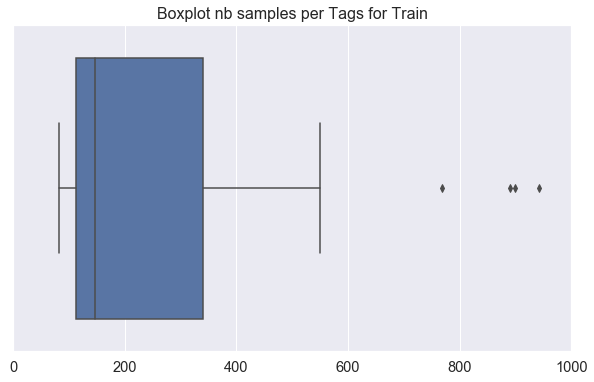

In [800]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb samples per Tags for Train")
ax = sns.boxplot(encoded_y_train.sum(axis=0))
ax.set_xlim([0,1000])

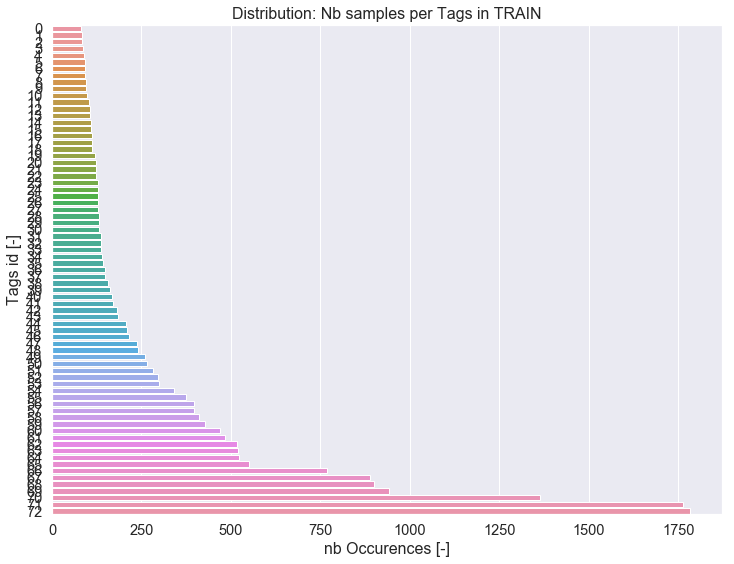

In [801]:
fig = plt.figure(figsize=(12, 9))
plt.title("Distribution: Nb samples per Tags in TRAIN")
df_count = pd.DataFrame(data=encoded_y_train.sum(axis=0), 
                        columns=['nb_samples'])
ax = sns.barplot(y=df_count.index, x=sorted(df_count["nb_samples"]), orient='h')
#ax.set_xlim(right=90)
#ax.set_ylim([0, 20])
ax.set_xlabel("nb Occurences [-]")
ax.set_ylabel("Tags id [-]");

In [803]:
print("Table of Tag id with min used of Tags")
df_count[df_count["nb_samples"] < df_most.iloc[idx_most]["nb_min_used"]]

Table of Tag id with min used of Tags


,nb_samples
4,89
6,92
25,85
28,93
34,83
37,97
54,92
57,88
67,82
70,95


Text(0, 0.5, 'nb [-]')

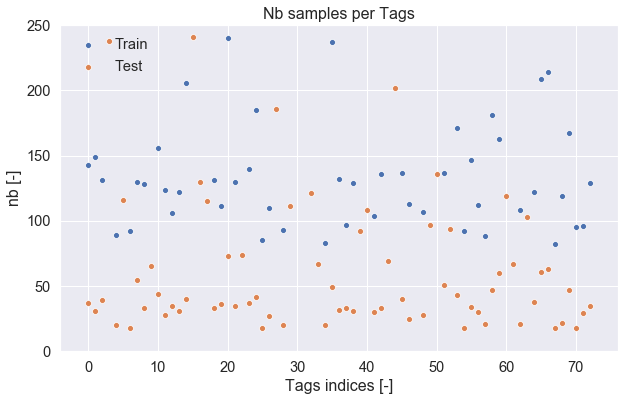

In [804]:
fig = plt.figure(figsize=(10, 6))
plt.title("Nb samples per Tags")
ax = sns.scatterplot(data=encoded_y_train.sum(axis=0), label='Train')
ax1 = sns.scatterplot(data=encoded_y_test.sum(axis=0), label='Test')
#ax1.set_xlim([0,250])
ax.set_xlabel('Tags indices [-]')
ax1.set_ylim([0,250])
ax.set_ylabel('nb [-]')

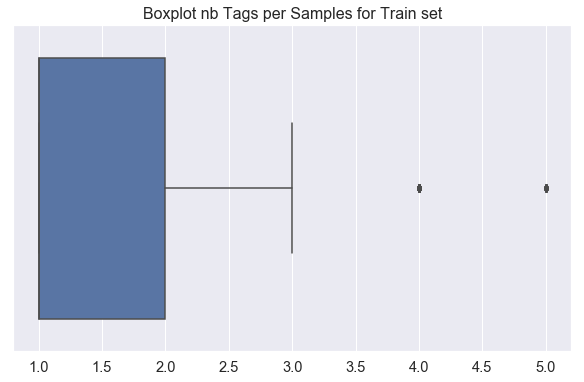

In [805]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Train set")
ax = sns.boxplot(encoded_y_train.sum(axis=1))
#ax.set_xlim([0,250])

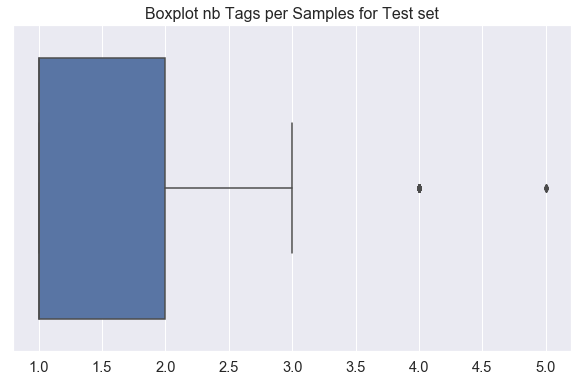

In [806]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Test set")
ax = sns.boxplot(encoded_y_test.sum(axis=1))

#### Features preparation

In [807]:
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(13710, 1000)

In [808]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_test_counts_sup_1.shape

(3443, 1000)

In [809]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [810]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(13710, 1000)

In [811]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3443, 1000)

#### Optim

In [817]:
clf_rf_multi_cv = RandomForestClassifier(random_state=0, n_jobs=-1)

In [879]:
# Fixer les valeurs des hyperparamètres à tester
# 5th try OVR
# {'estimator__n_estimators': [25], 'estimator__max_features': [155]} 0.192585
# Train Score : 0.961302784068203
# Test Score :  0.20671283963771978
# Nb. no Tags samples : 232 over 15014 rows [1.55%]
# Nb. no Tags samples : 1158 over 3754 rows [30.85%]

# 1st try {'n_estimators': [10, 20, 30], 'max_features': [24, 31, 37]}
# - best : {'max_features': 37, 'n_estimators': 30}
#   Train Score : 0.9697780908770693
#   Test Score :  0.24260355029585798
#   Nb. no Tags samples : 173 over 14195 rows [1.22%]
#   Nb. no Tags samples : 1486 over 3549 rows [41.87%] 

#2nd Try : {'n_estimators': [30, 40], 'max_features': [37, 43, 49]}
#{'max_features': 49, 'n_estimators': 40}
#Train Score : 0.9844311377245509
#Test Score :  0.25725556494787266
#Nb. no Tags samples : 87 over 14195 rows [0.61%]
#Nb. no Tags samples : 1342 over 3549 rows [37.81%]

#{'n_estimators': [50, 60], 'max_features': [55, 62, 68]}
#{'max_features': 68, 'n_estimators': 60}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [60, 70], 'max_features': [68, 93, 124]} 0.266408
#{'max_features': 124, 'n_estimators': 70}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [80], 'max_features': [124, 155, 186]}    
# {'max_features': 186, 'n_estimators': 80}
#Train Score : 0.9970412116942585
#Test Score :  0.2879684418145957
#Nb. no Tags samples : 13 over 14195 rows [0.09%]
#Nb. no Tags samples : 1008 over 3549 rows [28.40%]
#{'max_features': 31, 'min_samples_split': 3, 'n_estimators': 50}
max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [50]
max_features_range = [max_features_ideal]
min_samples_split_range = [3]
score = 'f1_micro'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range}
param_grid

{'n_estimators': [50], 'max_features': [31], 'min_samples_split': [3]}

In [880]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score) # score à optimiser

# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

timing total: 79.4407012462616 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_features': 31, 'min_samples_split': 3, 'n_estimators': 50}


In [881]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
df_res_rf_multi_cv[df_res_rf_multi_cv["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0
mean_fit_time,16.1444
std_fit_time,2.06633
mean_score_time,0.975811
std_score_time,0.0481546
param_max_features,31
param_min_samples_split,3
param_n_estimators,50
params,"{'max_features': 31, 'min_samples_split': 3, '..."
split0_test_score,0.517498
split1_test_score,0.520552


In [882]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Eval best estimator :

In [883]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.9480671043034281
Test Score :  0.25907638687191403


In [884]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.0007743572834547326
Test hamming loss : 0.015421402965715626


In [885]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 299 over 13710 rows [2.18%]
Nb. no Tags samples : 1411 over 3443 rows [40.98%]


1411

#### Evaluation

In [886]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9997138633220468

In [887]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.8277731442869057

In [888]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.9646143935210749

In [889]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.36435389133627016

In [890]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.9818505421418702

In [891]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.5059903135355595

##### Get the list of list predicted

In [892]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [893]:
len(list_tuple_ypred_train)

13710

In [894]:
predicted_train.shape

(13710, 73)

In [895]:
len(list_tuple_ypred_test)

3443

In [896]:
predicted_test.shape

(3443, 73)

##### Re-encode y pred lists

In [897]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [898]:
enc_sup_ypred_train.shape

(13710, 8765)

In [899]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(13710, 40)

In [900]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)
df_enc_sup_ypred_train.head()

(13710, 8765)


,0,1,2,3,4,5,6,7,8,9,10,11,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [901]:
enc_sup_ypred_test.shape

(3443, 8765)

In [902]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3443, 40)

In [903]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)
df_enc_sup_ypred_test.head()

(3443, 8765)


,0,1,2,3,4,5,6,7,8,9,10,11,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
21,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
54,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
68,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [904]:
# extraction example : 
df_enc_sup_ypred_test.loc[:,range(0,5)].head()

,0,1,2,3,4
21,0,0,0,0,0
31,0,0,0,0,0
54,0,0,0,0,0
68,0,0,0,0,0
94,0,0,0,0,0


##### Extract only flag most used & Train columns 

In [905]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)
df_test.head()

(21208, 2)


,flag_most_Tagged_100,Train
3,True,True
4,True,True
9,True,True
10,True,True
12,True,True


##### Add y pred Train encoded data

In [906]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)

(21208, 8767)


##### Add y pred Test data

In [907]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)

(21208, 8767)


##### Assign no Tags to samples/rows without most used tags

In [908]:
df_test2.isnull().sum().sum()

35542075

In [909]:
df_test2[df_test2.isna()] = 0

In [910]:
df_test2.isnull().sum().sum()

0

In [911]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [912]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [913]:
enc_lda_y_train.shape

(16966, 8765)

In [914]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [915]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [916]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
                          enc_lda_y_test, enc_sup_all_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 3555 over 16966 rows [20.95%]
Nb. no Tags samples : 2210 over 4242 rows [52.10%]


In [917]:
df_results = add_score(df_results, series_scores, 
          "RF_tags{}".format(nb_most_used_tags))
df_results

update line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,2.968359e+01,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags1,0.016798,0.016973,0.276907,0.273220,0.093939,0.092270,0.140287,0.137952,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags2,0.007073,0.007308,0.200666,0.192008,0.136150,0.129687,0.162229,0.154811,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags3,0.002417,0.002593,0.169339,0.159437,0.172342,0.161532,0.170827,0.160478,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags4,0.000648,0.000236,0.149829,0.143446,0.203315,0.193774,0.172522,0.164855,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags5,0.000000,0.000000,0.135801,0.132249,0.230349,0.223310,0.170868,0.166119,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags6,0.000000,0.000000,0.123443,0.121091,0.251265,0.245363,0.165552,0.162155,0.000000,0.000000,4.581324e+02,61.726915
LDA_top25_tags10,0.000000,0.000000,0.089043,0.087176,0.302074,0.294403,0.137542,0.134519,0.000000,0.000000,6.172691e+01,53.785460
LDA_top25_tags1,0.015207,0.016030,0.277732,0.274399,0.094219,0.092668,0.140705,0.138547,0.000000,0.000000,3.143305e+09,53.785460


###  RandomForest Multi-Tags : 100 Most Used Tags

#### Choose Most Used Tags

In [920]:
idx_most = 2

In [921]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_76


100

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [922]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs'], ['android']]

For test set...
[['ios'], ['ios', 'swift'], ['c++'], ['excel', 'vba', 'excel-vba'], ['android', 'gradle'], ['sql-server'], ['c#', 'asp.net', 'bootstrap-4'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [923]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [924]:
encoded_y_train.shape

(14195, 100)

In [925]:
encoded_y_test.shape

(3549, 100)

##### Check if enough sample for each most used Tags (important for Training) :

In [926]:
#for idx in range(0, encoded_y_train.shape[1]):
print('For less used tag:')
print("- For train: ")
nb_used_tags_train = np.sum(encoded_y_train, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_train))
print("\n- For test : ")
nb_used_tags_test = np.sum(encoded_y_test, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_test))

For less used tag:
- For train: 
  - Number of use:  56

- For test : 
  - Number of use:  11


In [927]:
# for idx in range(0, encoded_y_train.shape[1]):
print('For each sample:')
print("- For train: ")
nb_tags_per_sample_train = np.sum(encoded_y_train, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_train))
print("\n- For test : ")
nb_tags_per_sample_test = np.sum(encoded_y_test, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_test))

For each sample:
- For train: 
  - Minimum Number of Tags:  1

- For test : 
  - Minimum Number of Tags:  1


In [928]:
find_nb_no_tags(encoded_y_train)
find_nb_no_tags(encoded_y_test)

Nb. no Tags samples : 0 over 14195 rows [0.00%]
Nb. no Tags samples : 0 over 3549 rows [0.00%]


0

#### Distribution of Tags

(0, 1000)

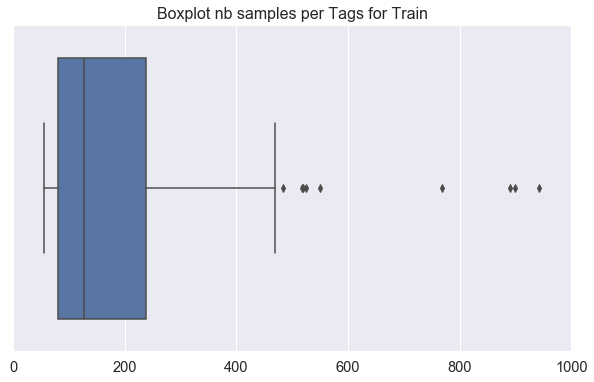

In [929]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb samples per Tags for Train")
ax = sns.boxplot(encoded_y_train.sum(axis=0))
ax.set_xlim([0,1000])

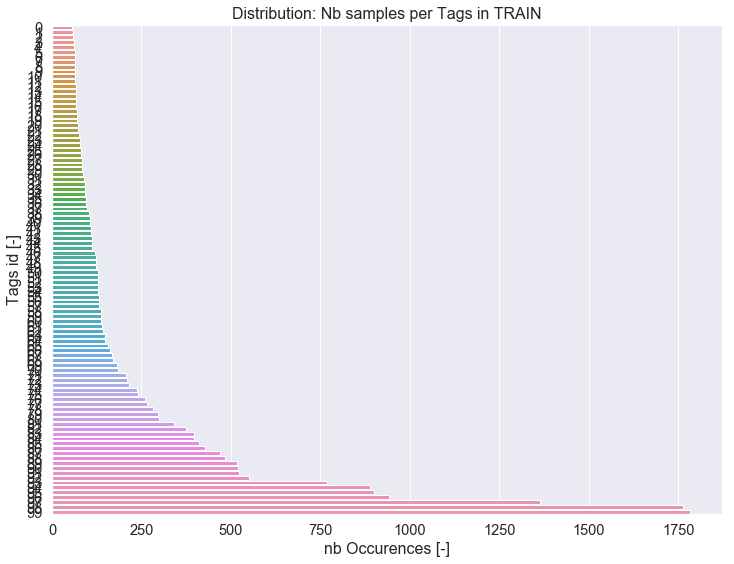

In [930]:
fig = plt.figure(figsize=(12, 9))
plt.title("Distribution: Nb samples per Tags in TRAIN")
df_count = pd.DataFrame(data=encoded_y_train.sum(axis=0), 
                        columns=['nb_samples'])
ax = sns.barplot(y=df_count.index, x=sorted(df_count["nb_samples"]), orient='h')
#ax.set_xlim(right=90)
#ax.set_ylim([0, 20])
ax.set_xlabel("nb Occurences [-]")
ax.set_ylabel("Tags id [-]");

In [931]:
print("Table of Tag id with min used of Tags")
df_count[df_count["nb_samples"] < df_most.iloc[idx_most]["nb_min_used"]]

Table of Tag id with min used of Tags


,nb_samples
12,64
16,67
26,61
29,64
31,61
33,67
35,65
36,68
37,70
40,56


Text(0, 0.5, 'nb [-]')

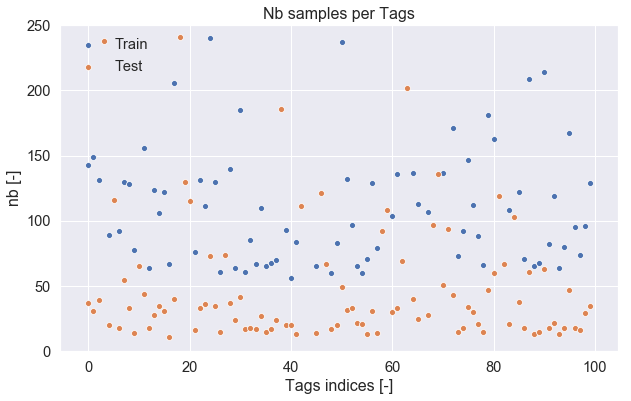

In [932]:
fig = plt.figure(figsize=(10, 6))
plt.title("Nb samples per Tags")
ax = sns.scatterplot(data=encoded_y_train.sum(axis=0), label='Train')
ax1 = sns.scatterplot(data=encoded_y_test.sum(axis=0), label='Test')
#ax1.set_xlim([0,250])
ax.set_xlabel('Tags indices [-]')
ax1.set_ylim([0,250])
ax.set_ylabel('nb [-]')

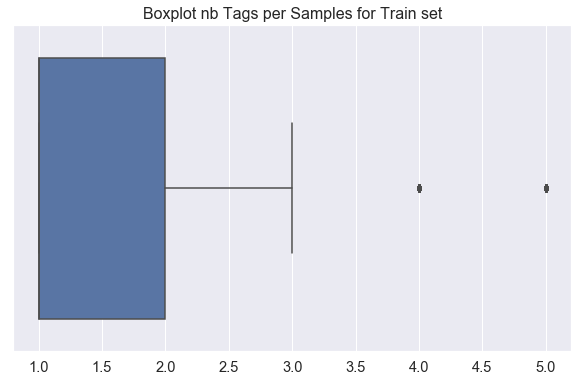

In [933]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Train set")
ax = sns.boxplot(encoded_y_train.sum(axis=1))
#ax.set_xlim([0,250])

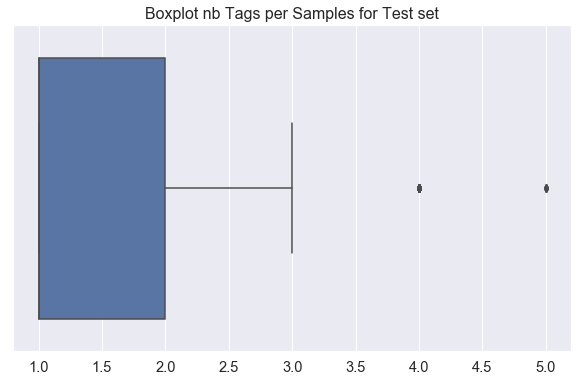

In [934]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Test set")
ax = sns.boxplot(encoded_y_test.sum(axis=1))

#### Features preparation

In [935]:
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(14195, 1000)

In [936]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_test_counts_sup_1.shape

(3549, 1000)

In [937]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [938]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(14195, 1000)

In [939]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3549, 1000)

#### Optim

In [940]:
clf_rf_multi_cv = RandomForestClassifier(random_state=0, n_jobs=-1)

In [950]:
# Fixer les valeurs des hyperparamètres à tester
# 5th try OVR
# {'estimator__n_estimators': [25], 'estimator__max_features': [155]} 0.192585
# Train Score : 0.961302784068203
# Test Score :  0.20671283963771978
# Nb. no Tags samples : 232 over 15014 rows [1.55%]
# Nb. no Tags samples : 1158 over 3754 rows [30.85%]

# 1st try {'n_estimators': [10, 20, 30], 'max_features': [24, 31, 37]}
# - best : {'max_features': 37, 'n_estimators': 30}
#   Train Score : 0.9697780908770693
#   Test Score :  0.24260355029585798
#   Nb. no Tags samples : 173 over 14195 rows [1.22%]
#   Nb. no Tags samples : 1486 over 3549 rows [41.87%] 

#2nd Try : {'n_estimators': [30, 40], 'max_features': [37, 43, 49]}
#{'max_features': 49, 'n_estimators': 40}
#Train Score : 0.9844311377245509
#Test Score :  0.25725556494787266
#Nb. no Tags samples : 87 over 14195 rows [0.61%]
#Nb. no Tags samples : 1342 over 3549 rows [37.81%]

#{'n_estimators': [50, 60], 'max_features': [55, 62, 68]}
#{'max_features': 68, 'n_estimators': 60}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [60, 70], 'max_features': [68, 93, 124]} 0.266408
#{'max_features': 124, 'n_estimators': 70}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [80], 'max_features': [124, 155, 186]}    
# {'max_features': 186, 'n_estimators': 80}
#Train Score : 0.9970412116942585
#Test Score :  0.2879684418145957
#Nb. no Tags samples : 13 over 14195 rows [0.09%]
#Nb. no Tags samples : 1008 over 3549 rows [28.40%]
#{'max_features': 31, 'min_samples_split': 3, 'n_estimators': 50}
max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [50]
max_features_range = [max_features_ideal]
min_samples_split_range = [3]
score = 'f1_micro'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
             'min_samples_split': min_samples_split_range}
param_grid

{'n_estimators': [50], 'max_features': [31], 'min_samples_split': [3]}

In [951]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score) # score à optimiser

# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

timing total: 109.95119881629944 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_features': 31, 'min_samples_split': 3, 'n_estimators': 50}


In [952]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
df_res_rf_multi_cv[df_res_rf_multi_cv["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0
mean_fit_time,21.667
std_fit_time,1.96466
mean_score_time,1.57405
std_score_time,0.246723
param_max_features,31
param_min_samples_split,3
param_n_estimators,50
params,"{'max_features': 31, 'min_samples_split': 3, '..."
split0_test_score,0.48688
split1_test_score,0.481526


In [953]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Eval best estimator :

In [954]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.9355406833392039
Test Score :  0.2361228515074669


In [955]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.0007178584008453681
Test hamming loss : 0.012183713722175261


In [956]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 366 over 14195 rows [2.58%]
Nb. no Tags samples : 1524 over 3549 rows [42.94%]


1524

#### Evaluation

In [957]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9996012935808266

In [958]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.8275574112734865

In [959]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.9571561890218037

In [960]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.33633124045477686

In [961]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.977918391228032

In [962]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.47828185328185324

##### Get the list of list predicted

In [963]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [964]:
len(list_tuple_ypred_train)

14195

In [965]:
predicted_train.shape

(14195, 100)

In [966]:
len(list_tuple_ypred_test)

3549

In [967]:
predicted_test.shape

(3549, 100)

##### Re-encode y pred lists

In [968]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [969]:
enc_sup_ypred_train.shape

(14195, 8765)

In [970]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(14195, 40)

In [971]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)
df_enc_sup_ypred_train.head()

(14195, 8765)


,0,1,2,3,4,5,6,7,8,9,10,11,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [972]:
enc_sup_ypred_test.shape

(3549, 8765)

In [973]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3549, 40)

In [974]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)
df_enc_sup_ypred_test.head()

(3549, 8765)


,0,1,2,3,4,5,6,7,8,9,10,11,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
21,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
54,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
68,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [975]:
# extraction example : 
df_enc_sup_ypred_test.loc[:,range(0,5)].head()

,0,1,2,3,4
21,0,0,0,0,0
31,0,0,0,0,0
54,0,0,0,0,0
68,0,0,0,0,0
94,0,0,0,0,0


##### Extract only flag most used & Train columns 

In [976]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)
df_test.head()

(21208, 2)


,flag_most_Tagged_76,Train
3,True,True
4,True,True
9,True,True
10,True,True
12,True,True


##### Add y pred Train encoded data

In [977]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)

(21208, 8767)


##### Add y pred Test data

In [978]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)

(21208, 8767)


##### Assign no Tags to samples/rows without most used tags

In [979]:
df_test2.isnull().sum().sum()

30361960

In [980]:
df_test2[df_test2.isna()] = 0

In [981]:
df_test2.isnull().sum().sum()

0

In [982]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [983]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [984]:
enc_lda_y_train.shape

(16966, 8765)

In [985]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [986]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [987]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
                          enc_lda_y_test, enc_sup_all_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 3137 over 16966 rows [18.49%]
Nb. no Tags samples : 2217 over 4242 rows [52.26%]


In [988]:
df_results = add_score(df_results, series_scores, 
          "RF_tags{}".format(nb_most_used_tags))
df_results

add line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,2.968359e+01,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags1,0.016798,0.016973,0.276907,0.273220,0.093939,0.092270,0.140287,0.137952,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags2,0.007073,0.007308,0.200666,0.192008,0.136150,0.129687,0.162229,0.154811,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags3,0.002417,0.002593,0.169339,0.159437,0.172342,0.161532,0.170827,0.160478,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags4,0.000648,0.000236,0.149829,0.143446,0.203315,0.193774,0.172522,0.164855,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags5,0.000000,0.000000,0.135801,0.132249,0.230349,0.223310,0.170868,0.166119,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags6,0.000000,0.000000,0.123443,0.121091,0.251265,0.245363,0.165552,0.162155,0.000000,0.000000,4.581324e+02,61.726915
LDA_top25_tags10,0.000000,0.000000,0.089043,0.087176,0.302074,0.294403,0.137542,0.134519,0.000000,0.000000,6.172691e+01,53.785460
LDA_top25_tags1,0.015207,0.016030,0.277732,0.274399,0.094219,0.092668,0.140705,0.138547,0.000000,0.000000,3.143305e+09,53.785460


###  KNN Multi-Tags : 51 Most Used Tags

#### Choose Most Used Tags

In [990]:
idx_most = 0

In [991]:
list_tags_most_used = list_list_most_used[idx_most]
col_flag = "flag_most_Tagged_{:.0f}".format(df_most.iloc[idx_most]["nb_min_used"])
print(col_flag)
nb_most_used_tags = df_most.iloc[idx_most]["nb_most_used_tags"]
len(list_tags_most_used)

flag_most_Tagged_160


51

#### Multi-label encoding

##### For output to predict, extract only most used Tags

In [992]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == True) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
        df_mdl_sup_1[col_flag] == True]\
        ["Tags"], list_tags_most_used=list_tags_most_used)

print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['javascript', 'php', 'ajax'], ['android'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs'], ['android']]

For test set...
[['ios'], ['ios', 'swift'], ['c++'], ['excel', 'vba', 'excel-vba'], ['android'], ['sql-server'], ['c#', 'asp.net'], ['javascript', 'reactjs'], ['python', 'django'], ['javascript', 'angular', 'typescript']]


##### Encoding output to predict

In [993]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [994]:
encoded_y_train.shape

(13024, 51)

In [995]:
encoded_y_test.shape

(3288, 51)

#### Features preparation

In [996]:
# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[(df_quest_cleaned.Train== True) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(13024, 1000)

In [997]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[(df_mdl_sup_1.Train == False) & \
    (df_mdl_sup_1[col_flag] == True)]["token_text"])
X_test_counts_sup_1.shape

(3288, 1000)

In [998]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [999]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(13024, 1000)

In [1000]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3288, 1000)

#### Optim

In [1002]:
clf_knn_multi_cv = KNeighborsClassifier(n_jobs=-1)

In [1006]:
# Fixer les valeurs des hyperparamètres à tester
n_neighbors_range = [3, 5, 13, 15]
score = 'f1_micro'
# grille de paramètres
param_grid = {'n_neighbors': n_neighbors_range}
param_grid

{'n_neighbors': [3, 5, 13, 15]}

In [1007]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_knn_multi_cv = model_selection.GridSearchCV(clf_knn_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv,# nombre de folds de validation croisée
scoring=score) # score à optimiser

# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_knn_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_knn_multi_cv.best_params_)

timing total: 184.480073928833 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 5}


In [1005]:
df_res_knn_multi_cv = pd.DataFrame(data=g_clf_knn_multi_cv.cv_results_)
df_res_knn_multi_cv[df_res_knn_multi_cv["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0,2,4,6
mean_fit_time,0.0600433,0.0518623,0.181676,0.0446111
std_fit_time,0.0182871,0.0106055,0.202065,0.0118245
mean_score_time,3.51101,2.59585,3.21286,2.96503
std_score_time,1.99092,0.47127,1.8138,1.49898
param_n_neighbors,5,7,9,11
params,{'n_neighbors': 5},{'n_neighbors': 7},{'n_neighbors': 9},{'n_neighbors': 11}
split0_test_score,0.361618,0.35906,0.355236,0.354074
split1_test_score,0.371806,0.373028,0.364611,0.358905
split2_test_score,0.364956,0.362294,0.346542,0.33966
mean_test_score,0.366127,0.364794,0.355463,0.35088


In [953]:
g_clf_knn_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 31,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Eval best estimator :

In [954]:
print("Train Score :", 
      g_clf_knn_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_knn_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.9355406833392039
Test Score :  0.2361228515074669


In [955]:
predicted_train = g_clf_knn_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
t_pred_0 = time.time()
predicted_test = g_clf_knn_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
t_pred_1 = time.time()
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.0007178584008453681
Test hamming loss : 0.012183713722175261


In [956]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 366 over 14195 rows [2.58%]
Nb. no Tags samples : 1524 over 3549 rows [42.94%]


1524

#### Evaluation

In [957]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.9996012935808266

In [958]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.8275574112734865

In [959]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.9571561890218037

In [960]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.33633124045477686

In [961]:
f1_score(encoded_y_train, predicted_train, average='micro')

0.977918391228032

In [962]:
f1_score(encoded_y_test, predicted_test, average='micro')

0.47828185328185324

##### Get the list of list predicted

In [963]:
list_tuple_ypred_train = mlb.inverse_transform(predicted_train)
list_tuple_ypred_test = mlb.inverse_transform(predicted_test)

In [964]:
len(list_tuple_ypred_train)

14195

In [965]:
predicted_train.shape

(14195, 100)

In [966]:
len(list_tuple_ypred_test)

3549

In [967]:
predicted_test.shape

(3549, 100)

##### Re-encode y pred lists

In [968]:
enc_sup_ypred_train = mlb_lda.transform(list_tuple_ypred_train)
enc_sup_ypred_test = mlb_lda.transform(list_tuple_ypred_test)

##### Create DafaFrames Train and Test using encoded y pred data using index of big dataFrame

Same index reference : 
    df_quest_cleaned.INDEX -> 2 encoded data y pred Dataframes.INDEX


In [969]:
enc_sup_ypred_train.shape

(14195, 8765)

In [970]:
df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(14195, 40)

In [971]:
df_enc_sup_ypred_train = pd.DataFrame(data=enc_sup_ypred_train,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == True) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_train.shape)

(14195, 8765)


,0,1,2,3,4,5,6,7,8,9,10,11,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [972]:
enc_sup_ypred_test.shape

(3549, 8765)

In [973]:
df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].shape

(3549, 40)

In [974]:
df_enc_sup_ypred_test = pd.DataFrame(data=enc_sup_ypred_test,
    index=df_quest_cleaned[(df_quest_cleaned["Train"] == False) & \
                 (df_quest_cleaned[col_flag] == True)].index)
print(df_enc_sup_ypred_test.shape)

(3549, 8765)


,0,1,2,3,4,5,6,7,8,9,10,11,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764
21,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
54,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
68,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


##### Extract only flag most used & Train columns 

In [976]:
df_test = df_quest_cleaned.filter(items=[col_flag, "Train"])
print(df_test.shape)

(21208, 2)


,flag_most_Tagged_76,Train
3,True,True
4,True,True
9,True,True
10,True,True
12,True,True


##### Add y pred Train encoded data

In [977]:
df_test2 = df_test.join(df_enc_sup_ypred_train)
print(df_test2.shape)

(21208, 8767)


##### Add y pred Test data

In [978]:
df_test2.update(df_enc_sup_ypred_test)
print(df_test2.shape)

(21208, 8767)


##### Assign no Tags to samples/rows without most used tags

In [979]:
df_test2.isnull().sum().sum()

30361960

In [980]:
df_test2[df_test2.isna()] = 0

In [981]:
df_test2.isnull().sum().sum()

0

In [982]:
df_test2[df_test2[0].isna()].shape[0]

0

##### Extract encoded binarized array for y pred Train & Test to be evaluated

In [983]:
enc_sup_all_ypred_train = df_test2.loc[df_quest_cleaned["Train"] == True,
             range(0, enc_sup_ypred_train.shape[1])].values
enc_sup_all_ypred_train.shape

(16966, 8765)

In [984]:
enc_lda_y_train.shape

(16966, 8765)

In [985]:
enc_sup_all_ypred_test = df_test2.loc[df_quest_cleaned["Train"] == False,
             range(0, enc_sup_ypred_test.shape[1])].values
enc_sup_all_ypred_test.shape

(4242, 8765)

In [986]:
enc_lda_y_test.shape

(4242, 8765)

##### Evaluate on all data

In [987]:
series_scores = evaluate_mdl_scorings(enc_lda_y_train, enc_sup_all_ypred_train,
                          enc_lda_y_test, enc_sup_all_ypred_test, 
                          t_1-t_0, t_pred_1-t_pred_0)

Nb. no Tags samples : 3137 over 16966 rows [18.49%]
Nb. no Tags samples : 2217 over 4242 rows [52.26%]


In [988]:
df_results = add_score(df_results, series_scores, 
          "KNN_tags{}".format(nb_most_used_tags))
df_results

add line


,acc_train,acc_test,pre_train,pre_test,rec_train,rec_test,f1_train,f1_test,notags_train,notags_test,t_fit_train,t_pred_test
RF_tags51,0.134445,0.045497,0.998597,0.833866,0.369999,0.166229,0.539940,0.277199,0.256749,0.506601,2.968359e+01,0.532939
LDA_top50_tags10,0.000000,0.000000,0.091412,0.089156,0.310112,0.301091,0.141202,0.137575,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags1,0.016798,0.016973,0.276907,0.273220,0.093939,0.092270,0.140287,0.137952,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags2,0.007073,0.007308,0.200666,0.192008,0.136150,0.129687,0.162229,0.154811,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags3,0.002417,0.002593,0.169339,0.159437,0.172342,0.161532,0.170827,0.160478,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags4,0.000648,0.000236,0.149829,0.143446,0.203315,0.193774,0.172522,0.164855,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags5,0.000000,0.000000,0.135801,0.132249,0.230349,0.223310,0.170868,0.166119,0.000000,0.000000,4.581324e+02,61.726915
LDA_top50_tags6,0.000000,0.000000,0.123443,0.121091,0.251265,0.245363,0.165552,0.162155,0.000000,0.000000,4.581324e+02,61.726915
LDA_top25_tags10,0.000000,0.000000,0.089043,0.087176,0.302074,0.294403,0.137542,0.134519,0.000000,0.000000,6.172691e+01,53.785460
LDA_top25_tags1,0.015207,0.016030,0.277732,0.274399,0.094219,0.092668,0.140705,0.138547,0.000000,0.000000,3.143305e+09,53.785460


### SGDClassifier OneVsRestClassifier

In [480]:
#clf_sgd_multi_1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2',
#                        alpha=1e-3, random_state=0,
#                        max_iter=5, tol=None), n_jobs=-1)
#clf_sgd_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)

In [481]:
#10.0**-np.arange(1,7)

#### First try

In [417]:
#Train Score :  0.6276808312241907 Test Score :  0.17474693660095897
clf_sgd_multi_1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2',
                    alpha=1e-6, 
                    max_iter = np.ceil(10**6 / X_train_tfidf_sup_1.shape[0]),
                    random_state=0, n_jobs=-1), n_jobs=-1)
t_0 = time.time()
clf_sgd_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

timing total: 11.967247009277344 s


In [418]:
print("Train Score :", 
      clf_sgd_multi_1.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      clf_sgd_multi_1.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.655371609721733
Test Score :  0.2355593124823894


In [419]:
predicted_train = clf_sgd_multi_1.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = clf_sgd_multi_1.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.004159915463191264
Test hamming loss : 0.01326007326007326


In [420]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 1227 over 14195 rows [8.64%]
Nb. no Tags samples : 808 over 3549 rows [22.77%]


808

In [421]:
np.nonzero(predicted_test.sum(axis=1))[0].shape[0] / predicted_test.shape[0]

0.7723302338686954

#### Optim OneVsRestClassifier(SGDClassifier)

In [455]:
# Choisir un score à optimiser
#score = 'r2'
#score ='neg_mean_squared_error'
# Choisir des jeux train/test fixe
random_state = 0
n_splits = 3
test_size=0.2

# preparation des splits : choix de splits aléatoires de meme taille
cv = model_selection.ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)


In [456]:
clf_sgd_multi_cv = OneVsRestClassifier(SGDClassifier(random_state=0, n_jobs=-1),
                                       n_jobs=-1)

In [457]:
# Fixer les valeurs des hyperparamètres à tester


'''
nb_iter_ideal = np.ceil(10**6 / X_train_tfidf_sup_1.shape[0])
max_iter_range = [np.ceil(nb_iter_ideal/3), nb_iter_ideal, nb_iter_ideal*3]
alpha_range = 10.0**-np.arange(1,7)
loss_range = ['hinge','log']
penalty_range = ['l2', 'l1', 'elasticnet']
'''
#test 0.245973
#{'estimator__alpha': 1e-05, 'estimator__loss': 'log', 'estimator__max_iter': 23.0, 'estimator__penalty': 'l1'}
#Train Score : 0.4661500528355055
#Test Score :  0.25387433079740773
#Nb. no Tags samples : 2740 over 14195 rows [19.30%]
#Nb. no Tags samples : 982 over 3549 rows [27.67%]

#0.251145
#Train Score : 0.4661500528355055 
#Test Score :  0.25387433079740773
#Nb. no Tags samples : 2740 over 14195 rows [19.30%]
#Nb. no Tags samples : 982 over 3549 rows [27.67%]
    
max_iter_range = [23]
alpha_range = [1e-05]
loss_range = ['log']
penalty_range = ['l1']


# grille de paramètres
param_grid = {'estimator__max_iter': max_iter_range, 
              'estimator__loss': loss_range, 
              'estimator__alpha': alpha_range, 
              'estimator__penalty': penalty_range}
param_grid

{'estimator__max_iter': [23],
 'estimator__loss': ['log'],
 'estimator__alpha': [1e-05],
 'estimator__penalty': ['l1']}

In [458]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_sgd_multi_cv = model_selection.GridSearchCV(clf_sgd_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv) # nombre de folds de validation croisée
#scoring=score # score à optimiser)


# Optimiser ce classifieur sur le jeu d'entraînement
# clf.fit(X_train, y_train)
t_0 = time.time()
g_clf_sgd_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_sgd_multi_cv.best_params_)

timing total: 28.123115062713623 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__alpha': 1e-05, 'estimator__loss': 'log', 'estimator__max_iter': 23, 'estimator__penalty': 'l1'}


In [459]:
df_res_sgd_multi_cv = pd.DataFrame(data=g_clf_sgd_multi_cv.cv_results_)
df_res_sgd_multi_cv[df_res_sgd_multi_cv["rank_test_score"]<10].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0
mean_fit_time,6.42186
std_fit_time,0.154966
mean_score_time,0.0397471
std_score_time,0.00391976
param_estimator__alpha,1e-05
param_estimator__loss,log
param_estimator__max_iter,23
param_estimator__penalty,l1
params,"{'estimator__alpha': 1e-05, 'estimator__loss':..."
split0_test_score,0.238816


In [460]:
g_clf_sgd_multi_cv.best_estimator_.get_params()

{'estimator__alpha': 1e-05,
 'estimator__average': False,
 'estimator__class_weight': None,
 'estimator__early_stopping': False,
 'estimator__epsilon': 0.1,
 'estimator__eta0': 0.0,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.15,
 'estimator__learning_rate': 'optimal',
 'estimator__loss': 'log',
 'estimator__max_iter': 23,
 'estimator__n_iter': None,
 'estimator__n_iter_no_change': 5,
 'estimator__n_jobs': -1,
 'estimator__penalty': 'l1',
 'estimator__power_t': 0.5,
 'estimator__random_state': 0,
 'estimator__shuffle': True,
 'estimator__tol': None,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': SGDClassifier(alpha=1e-05, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=23,
        n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l1',
        power_t=0.5, random_state=0, shuf

##### Eval best estimator :

In [461]:
print("Train Score :", 
      g_clf_sgd_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_sgd_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.4661500528355055
Test Score :  0.25387433079740773


In [462]:
predicted_train = g_clf_sgd_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = g_clf_sgd_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.007337794998238816
Test hamming loss : 0.012034375880529727


In [463]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 2740 over 14195 rows [19.30%]
Nb. no Tags samples : 982 over 3549 rows [27.67%]


982

#### Evaluation
Method : Check if real Tags are into predicted Tags

In [466]:
encoded_y_train[0,:] & predicted_train[0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [508]:
encoded_y_train[:3,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [509]:
predicted_train[:3,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [515]:
precision_score(encoded_y_train[:3,:], predicted_train[:3,:], average='micro')

0.8

In [511]:
4/5

0.8

In [ ]:
precision_score(encoded_y_train[0,:], predicted_train[0,:], average='micro')

In [495]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.8958270789552687

In [497]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.70752016653656

In [498]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.6321766026863268

In [516]:
df_mdl_sup_1[df_mdl_sup_1["Train"] == True]["score_sgd_multi_1"].mean()

0.6548103792415159

In [499]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.4635185816570065

In [517]:
df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["score_sgd_multi_1"].mean()

0.4840847187001031

In [474]:
t_0 = time.time()

df_mdl_sup_1["score_sgd_multi_1"] = 0

# train part
list_scores_train = []
for i_row in range(0, encoded_y_train.shape[0]):
    nb_tags_curr = np.sum(encoded_y_train[i_row,:])
    nb_good = np.sum(encoded_y_train[i_row,:] & predicted_train[i_row,:])
    list_scores_train.append(nb_good / nb_tags_curr)    

# test part
list_scores_test = []
for i_row in range(0, encoded_y_test.shape[0]):
    nb_tags_curr = np.sum(encoded_y_test[i_row,:])
    nb_good = np.sum(encoded_y_test[i_row,:] & predicted_test[i_row,:])
    list_scores_test.append(nb_good / nb_tags_curr) 
    
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

df_mdl_sup_1.loc[df_mdl_sup_1["Train"] == True, "score_sgd_multi_1"] =\
    list_scores_train
df_mdl_sup_1.loc[df_mdl_sup_1["Train"] == False, "score_sgd_multi_1"] =\
    list_scores_test

timing total: 0.28374314308166504 s


In [476]:
#fig = plt.figure(figsize=(8, 8))
#plt.title("title")
df_mdl_sup_1["score_sgd_multi_1"].value_counts()

1.000000    8783
0.000000    4516
0.500000    2842
0.666667     702
0.333333     651
0.750000     106
0.250000      95
0.200000      17
0.600000      17
0.400000      12
0.800000       3
Name: score_sgd_multi_1, dtype: int64

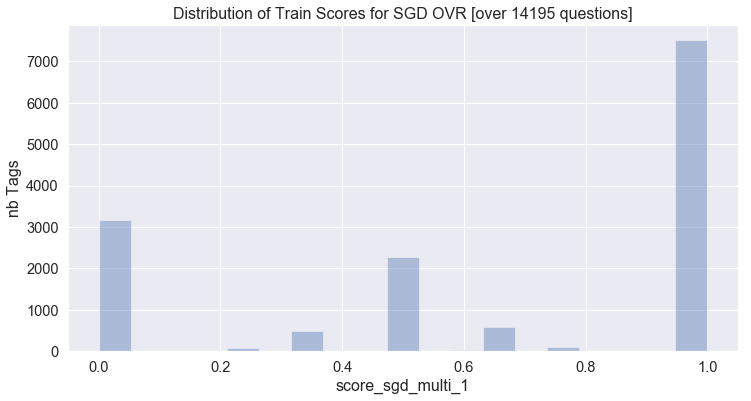

In [478]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Train Scores for SGD OVR [over {} questions]".format(
    df_mdl_sup_1[df_mdl_sup_1.Train == True].shape[0]))
ax = sns.distplot(df_mdl_sup_1[df_model_1.Train == True]["score_sgd_multi_1"], 
                  kde=False)
ax.set_ylabel('nb Tags');

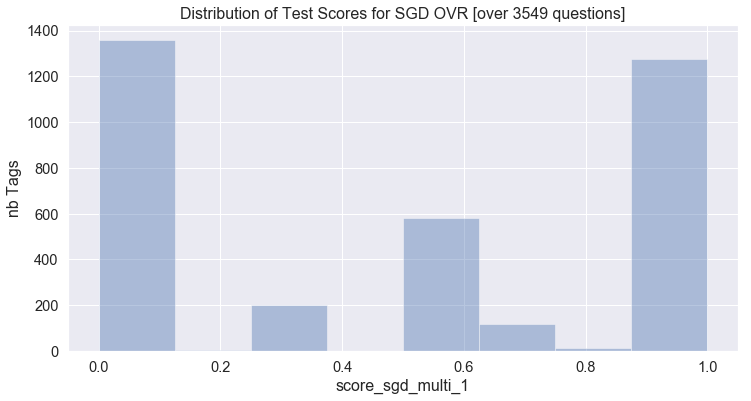

In [479]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Test Scores for SGD OVR [over {} questions]".format(
    df_mdl_sup_1[df_mdl_sup_1.Train == False].shape[0]))
ax = sns.distplot(df_mdl_sup_1[df_model_1.Train == False]["score_sgd_multi_1"], 
                  kde=False)
ax.set_ylabel('nb Tags');

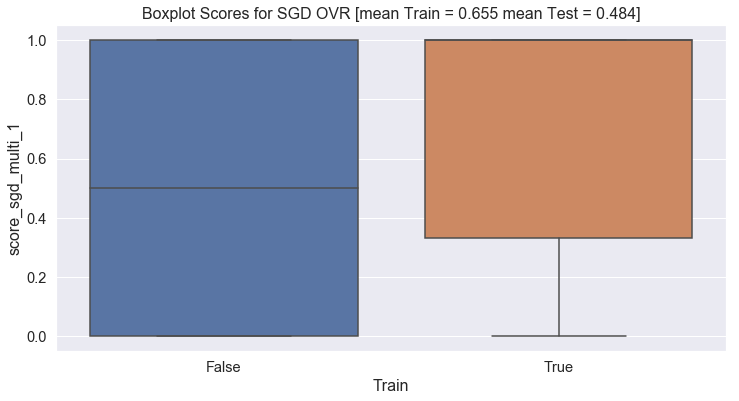

In [481]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot Scores for SGD OVR [mean Train = {:.3f} mean Test = {:.3f}]".
          format(df_mdl_sup_1[df_mdl_sup_1.Train == True]\
                 ["score_sgd_multi_1"].mean(),
                 df_mdl_sup_1[df_mdl_sup_1.Train == False]\
                 ["score_sgd_multi_1"].mean()))
ax = sns.boxplot(y="score_sgd_multi_1", x='Train', data=df_mdl_sup_1)

##### At least one Tag ok

In [483]:
df_mdl_sup_1["score_OK_sgd_1"] = df_mdl_sup_1["score_sgd_multi_1"] > 0

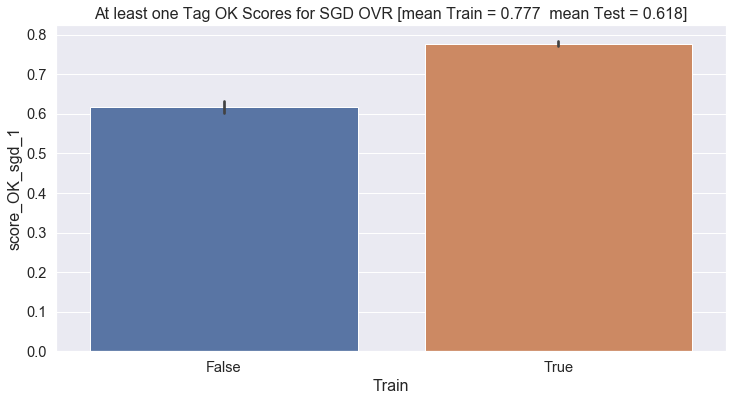

In [485]:
fig = plt.figure(figsize=(12, 6))
plt.title("At least one Tag OK Scores for SGD OVR [mean Train = {:.3f}  mean Test = {:.3f}]".
          format(df_mdl_sup_1[df_mdl_sup_1.Train == True]\
                 ["score_OK_sgd_1"].mean(),
                 df_mdl_sup_1[df_mdl_sup_1.Train == False]\
                 ["score_OK_sgd_1"].mean()))
ax = sns.barplot(y="score_OK_sgd_1", x='Train', data=df_mdl_sup_1)
#ax = sns.barplot(x="day", y="total_bill", data=tips)

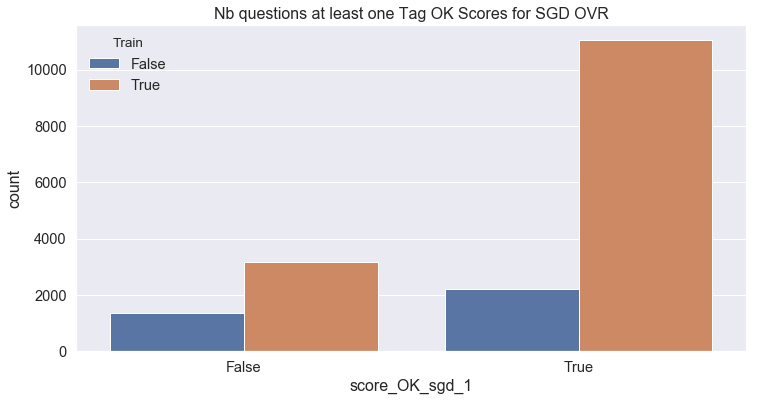

In [486]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb questions at least one Tag OK Scores for SGD OVR")
ax = sns.countplot(x="score_OK_sgd_1", hue="Train", data=df_mdl_sup_1)